In [1]:
import json
import math
import scipy
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics 
import seaborn as sns
from numpy.random import randn
from random import *
from statistics import mode
from scipy import stats
%matplotlib inline

In [2]:
scipy.__version__

'1.4.1'

# Get Data

In [3]:
classrooms = json.load(open('classrooms.json', 'r'))
pupils = json.load(open('pupils.json', 'r'))

In [4]:
df = pd.read_pickle('df.pkl') #, index_col=0
pupil_performance_df = pd.read_pickle('pupil_performance.pkl')
pupil_performance_df.drop(["5GPMWTgF29JDyeXoG"], inplace=True) #5GPMWTgF29JDyeXoG droppen, vermutlich nur lehrer, der hochspielt
pupil_performance_df1 = pd.read_csv('pupil_performance_copy.csv') # Das ist der DF, in dem ich manuell die Freitextaufgaben bewertet habe
pupil_performance_df1 = pupil_performance_df1.set_index('pupilId')
pupil_performance_df1.drop(["5GPMWTgF29JDyeXoG"], inplace=True) #5GPMWTgF29JDyeXoG droppen, vermutlich nur lehrer, der hochspielt
chat_df = pd.read_pickle("chat.pkl")
surveysliders = pd.read_pickle('surveySlider.pkl')
inputfields = pd.read_pickle('inputFields.pkl')
multipleChoice = pd.read_pickle('multipleChoice.pkl')
freetext = pd.read_pickle('freetext.pkl')
task_df = pd.read_pickle('task_df.pkl')

In [5]:
df['duration'] = pd.to_numeric(df['duration'])
surveysliders['duration'] = pd.to_numeric(surveysliders['duration'])
inputfields['duration'] = pd.to_numeric(inputfields['duration'])
multipleChoice['duration'] = pd.to_numeric(multipleChoice['duration'])
freetext['duration'] = pd.to_numeric(freetext['duration'])

In [6]:
pupil_performance_df.head()

,nr_tasks_per_pupil,total_duration in minutes,average duration per task in minutes,AI-1-v2-1-1,AI-4-v2-1-4,EvalML-1-1,ML-2-1-1,EvalML-1-5,AI-4-v2-1-5,EvalML-1-2,...,AIClosing-1-6,AIClosing-1-7,AIClosing-1-8,AIClosing-1-8_rating_content,AIClosing-1-8_rating_format,AIClosing-1-8_rating_creativity,AIClosing-1-8_correct_points,AIClosing-1-8_incorrect_points,AIClosing-1-8_irrelevant_points,classId
pupilId,,,,,,,,,,,,,,,,,,,,,
bniRycMi5bwrXjvGy,66,70.233333,1.064141,92.0,95.0,95.0,66.0,81.0,100.0,100.0,...,55.0,73.0,War alles gut.,5.0,5.0,5.0,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
sqBXKssFvS8pFYAMv,66,66.650000,1.009848,89.0,99.0,96.0,79.0,93.0,100.0,98.0,...,74.0,89.0,Ich fand es gut das Videos eingebunden wurden ...,5.0,5.0,5.0,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
Kd6FuRsrq6QvPrkKp,6,37.383333,6.230556,78.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
6bBwnX2mwAp2NAwNR,35,114.550000,3.272857,77.0,68.0,NaN,52.0,NaN,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qFEyvypMn4sAwLwtc
ZTvPk2i77LDC8pFmu,66,59.400000,0.900000,59.0,73.0,40.0,53.0,56.0,34.0,33.0,...,61.0,64.0,"Die Aufgaben waren zu schwer, und ab und zu ga...",5.0,5.0,5.0,NaN,NaN,NaN,qFEyvypMn4sAwLwtc


# Prepare Helper functions

In [7]:
def surveySliderStatistics(column):
    print(column.name)
    q3, q1 = np.percentile(column.dropna().values, [75 ,25])
    print("Q1: " + str(q1) + " and Q3: " + str(q3))
    print("median: " + str(column.dropna().median()))
    print("mean: " + str(column.dropna().mean()))
    print("std: " +str(round(column.dropna().std(), 2)))
    print("min: " + str(np.min(column.dropna())) + " und max: " + str(np.max(column.dropna())))
    print("")
    

In [8]:
def calculateDifferences(df):
    differences= []
    for pupilId in df.dropna().index:
        differences.append(df.loc[pupilId, df.columns[0]]-df.loc[pupilId, df.columns[1]])
    return differences

In [9]:
def print_boolean_percentages(series):
    nr_cases = series.value_counts()[True]+series.value_counts()[False]
    percentage_per_case = 100/nr_cases
    true_percentage = series.value_counts()[True]*percentage_per_case
    false_percentage = series.value_counts()[False]*percentage_per_case
    print(series.name + " has: " + str(true_percentage) + "% True null answers: " + str(false_percentage)+ "% right answers")
    #return true_percentage, false_percentage
    

In [10]:
def print_mc(taskIdArray):
    for taskID in task_df.index:
        if taskID in taskIdArray:
            print(str(taskID))
            print('\033[1m' + task_df.loc[taskID]["question"] + '\033[0m')
            for i in range(len(task_df.loc[taskID]["answers"])):
                print("*" + task_df.loc[taskID]["answers"][i]["de"] + " - " + str(task_df.loc[taskID]["sampleSolution"][i]))
            print(task_df.loc[taskID]["sampleSolution"])
            print()

In [96]:
def mc_analysis (taskIds):
    number_errors = []
    for pupilId in pupil_performance_df.index:
        errors = [0 for taskId in taskIds]
        for index, taskId in enumerate(taskIds):
            if(len(pupil_performance_df.loc[pupilId, taskId]) != 0):
                for i in range(len(task_df.loc[taskId, "sampleSolution"])):
                    #print(pupil_performance_df.loc[pupilId, taskId], task_df.loc[taskId, "sampleSolution"])
                    if pupil_performance_df.loc[pupilId, taskId][i] != task_df.loc[taskId, "sampleSolution"][i]:
                        #print(pupil_performance_df.loc[pupilId, taskId][i], task_df.loc[taskId, "sampleSolution"][i])
                        errors[index] += 1
            elif(len(pupil_performance_df.loc[pupilId, taskId]) == 0):
                errors[index] = np.nan
        number_errors.append(errors)
    
    #print(number_errors)
    #print()
    
    errors_sum =  [sum(list) for list in number_errors]
    errors_per_student = [entry for entry in [sum(list) for list in number_errors] if entry==entry]
    print(errors_per_student)
    errors_per_student_series = pd.Series(errors_per_student)
    
    print("number errors per student value counts")
    print(errors_per_student_series.value_counts())
    #plt.hist(errors_per_student)
    #plt.show()
    print("mean number of errors: " + str(np.mean(errors_per_student)))

In [12]:
def number_errors_mc (taskIds):
    number_errors = []
    for pupilId in pupil_performance_df.index:
        errors = [0 for taskId in taskIds]
        for index, taskId in enumerate(taskIds):
            if(len(pupil_performance_df.loc[pupilId, taskId]) != 0):
                for i in range(len(task_df.loc[taskId, "sampleSolution"])):
                    if pupil_performance_df.loc[pupilId, taskId][i] != task_df.loc[taskId, "sampleSolution"][i]:
                        errors[index] += 1
            elif(len(pupil_performance_df.loc[pupilId, taskId]) == 0):
                errors[index] = np.nan
        number_errors.append(errors)

    errors_sum =  [sum(list) for list in number_errors]
    errors_per_student = [entry for entry in [sum(list) for list in number_errors] if entry==entry]
    return errors_per_student

In [13]:
def random_mcs(numberStudents, numberAnswers):
    expected_nr_errors = []
    for i in range(numberStudents):
        nr_errors_per_student = 0
        for i in range(numberAnswers):
            #print(random())
            if random() >= 0.5:
                nr_errors_per_student+=1
        expected_nr_errors.append(nr_errors_per_student)
    return expected_nr_errors

In [14]:
def mannwhitney(taskArray, numberIndependentAnswers, numberRuns=100):
    p_array = []
    for i in range(numberRuns):
        p_array.append(stats.mannwhitneyu(number_errors_mc(taskArray), random_mcs(len(number_errors_mc(taskArray)), numberIndependentAnswers))[1])
    #print(p_array)
    average_p_value = np.mean(p_array)
    return average_p_value

In [98]:
def analyse_mc(taskIds, numberIndependentQuestions):
    print_mc(taskIds)
    mc_analysis(taskIds)
    print(stats.mannwhitneyu(number_errors_mc(taskIds), random_mcs(len(number_errors_mc(taskIds)), numberIndependentQuestions)))
    print()
    print("Average p-value over 100 tries: " + str(mannwhitney(taskIds, numberIndependentQuestions)))
    

In [122]:
def analyse_partial_mc(taskId, startindex, stopindex):
    # startindex ist die nummer der ersten antwort, die analysiert werden soll, stopindex die der letzten
    sampleSolution = task_df.loc[taskId, "sampleSolution"][startindex-1:stopindex]
    errors = []
    
    for entry in pupil_performance_df[taskId]:
        error_student = 0
        if len(entry)>0:
            for index, solution in enumerate(sampleSolution):
                if entry[startindex-1:stopindex][index] != solution:
                    error_student +=1
    
            errors.append(error_student)

    print(errors)
    average_number_errors = np.mean(errors)
    expected_number_errors = len(sampleSolution)/2
    print("Average number errors:",taskId, average_number_errors)
    print("Expected number errors:",taskId, expected_number_errors)
    return errors

In [71]:
def mannwhitneymanual(errorArray, numberIndependentAnswers, numberRuns=100):
    p_array = []
    for i in range(numberRuns):
        p_array.append(stats.mannwhitneyu(errorArray, random_mcs(len(errorArray), numberIndependentAnswers))[1])
    average_p_value = np.mean(p_array)
    return average_p_value

In [119]:
def analyse_combined_mcs(taskId1, taskId2, start1, stop1, start2, stop2):
    print_mc(taskId1)
    print_mc(taskId2)
    numberIndependentQuestions = stop1-start1+1+stop2-stop1+1
    errorList1 = analyse_partial_mc(taskId1, start1, stop1)
    print()
    errorList2 = analyse_partial_mc(taskId2, start2, stop2)
    error_list = [a+b for (a,b) in zip(errorList1,errorList2)]
    print(error_list)
    print()
    print("Average p-value Mann whitney U over 100 tries:", mannwhitneymanual(error_list, numberIndependentQuestions))
    #print(stats.mannwhitneyu(number_errors_mc(taskIds), random_mcs(len(number_errors_mc(taskIds)), numberIndependentQuestions)))
    #print("Average p-value over 100 tries: " + str(mannwhitney(taskIds, numberIndependentQuestions)))

# Evaluation Lernfortschritt


* Was ist KI?
  * Wie gut weißt du, was KI ist? Slider
    * [x] T0: AI-1-v2-1-1
    * [x] T1-1 'AI-4-v2-1-4', 'Wie gut hast du jetzt verstanden, was KI ist?'
    * [x] T1-2 'EvalML-1-1' Wie gut hast du verstanden, was KI ist?
  * Was ist KI? freitext
    * [x] T0: AI-1-v2-1-2
    * [x] T1: ('AI-4-v2-1-3', 'Jetzt weißt du schon mehr über KI. Sag nochmal in eigenen Worten, was KI ist. Denk dabei an die Eigenschaften, durch die sich KI-Anwendungen auszeichnen und die verschiedenen Arten von KIs.')
  * Unterschied spezifisch und allgemeine KI
    * [x] slider: ('AI-4-v2-1-5', 'Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?')
    * [x] slider: 'EvalML-1-2'

* Was ist ML?
  * Wie gut weißt du, was ML ist? Slider
    * [x] T0: 'ML-2-1-1' 'Wie gut weißt du schon, was Maschinelles Lernen ist?'
    * [x] T1: 'EvalML-1-5' Wie gut hast du verstanden, was maschinelles Lernen ist?
  * Was ist ML? Freetext
    * [x] T0:  'ML-2-1-2' - Weißt du vielleicht schon etwas über das maschinelle Lernen?
    * [x] T1: 'EvalML-1-7' - Was ist ML in eigenen Worten
  * unterschied überwachtes und unüberwachtes?
    * [x] slider 'EvalML-1-6' Wie sehr hast du das Gefühl, verstanden zu haben, was der Unterschied zwischen überwachtem und unüberwachtem Lernen ist?

* Gefühle zu KI
  * [x] slider ('AIClosing-1-1', 'Die Vorteile durch die Entwicklung von KI überwiegen die Risiken.')
  * [x] freetext: ('AIClosing-1-2', 'Du siehst also, dass die Erwartungen der Menschen sehr unterschiedlich ausfallen, was KI betrifft. Die Gefühle reichen von Dankbarkeit für Arbeitserleichterung über Skepsis bis Angst. Mit allem, was du jetzt über KI weißt, was würdest du jemandem sagen, der besorgt über eine Zukunft mit KI ist?')

* Verbesserungen
  * [x] slider ('AIClosing-1-3', 'Hattest du Spaß?')
  * [x] slider ('AIClosing-1-4', 'Hast du etwas gelernt?')
  * [x] freetext ('AIClosing-1-5', 'Wir wollen diesen Kurs natürlich noch verbessern, damit zukünftige Schülerinnen und Schüler noch mehr Spaß haben. Möchtest du uns zum Abschied noch etwas mitteilen? Was fandest du besonders gut, war irgendeine Stelle doof oder schwer verständlich oder sollen wir irgendwas ändern?')

* Trainingsdaten (unten nochmal) freetext: 'LimitsML-1-2'


* restliches KI
  * wo ist KI drinne:
    * MC: "AI-2-v2-1-1"
    * MC: 'EvalML-1-4' Welche der folgenden Anwendungen enthalten KI-Methoden?
  * Unterschied allgemeine und Spezifische KI:
    * MC: ('AI-4-v2-1-1', 'Was bedeuten diese Unterscheidung zwischen spezifischer und allgemeiner KI jetzt für die Intelligenz von KI-Anwendungen?')
  * Misskonzepte
    * MC: ('AI-4-v2-1-2', 'Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?')
    * MC: ('AI-3-v2-1-2', 'Welche der Aussagen über KI-Anwendungen stimmen?')
    * MC: 'EvalML-1-3' - welche aussagen (über ki) stimmen?

* restliches ML
  * Def überwachtes Lernen
    * MC: 'Classification-1-1-1', 'Was war unüberwachtes Lernen noch gleich?'
  * Def unüberwachtes Lernen
    * MC: "Clustering-1-1-1" 'Was war unüberwachtes Lernen noch gleich?'
  * Unterschiede überwacht - unüberwacht
    * MC: 'ML-3-1-2', 'ML-3-1-3','ML-3-1-4' welche art ist das jeweils?
    * MC: 'EvalML-1-9' Welche Art des Lernens sind folgende Aufgaben?
  * Trainingsdaten
    * MC: ('Classification-2-1-8', 'Was könnte passieren, wenn wir bei den Hundebildern nur Bilder von einer Hunderasse nutzen würden?')
    * [x] freetext: ('LimitsML-1-2', 'Was würde passieren, wenn wir alle Bilder von Hunden durch Bilder von Seehunden ersetzen würden, diese aber als Hunde labeln?')
    * MC: 'Was glaubst du, warum das Gesicht der dunkelhäutigen Frau nicht erkannt wurde?')
  * Misskonzepte:
    * MC: 'EvalML-1-8' Welche der Aussagen über maschinelles Lernen stimmen?



  
* durations könnte ich auch noch anschauen, um zu gucken, wie leicht die antwort viel

## 1. Was ist KI
### 1.1 Selbsteinschätzung
* T0: AI-1-v2-1-1
* T1-1 'AI-4-v2-1-4', 'Wie gut hast du jetzt verstanden, was KI ist?'
* T1-2 'EvalML-1-1' Wie gut hast du verstanden, was KI ist?

AI-1-v2-1-1
Q1: 58.0 and Q3: 78.5
median: 71.0
mean: 68.2051282051282
std: 20.9
min: 5.0 und max: 100.0

AI-4-v2-1-4
Q1: 63.0 and Q3: 93.5
median: 84.0
mean: 78.51612903225806
std: 18.75
min: 40.0 und max: 100.0

EvalML-1-1
Q1: 50.0 and Q3: 90.5
median: 76.0
mean: 70.46666666666667
std: 23.79
min: 31.0 und max: 100.0



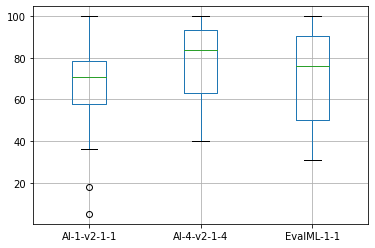


Nach Klasse bei T0


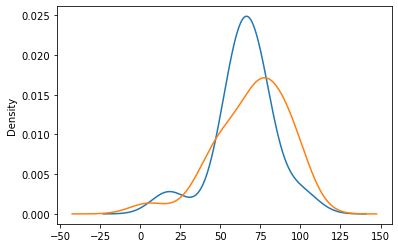

In [196]:
surveySliderStatistics(pupil_performance_df["AI-1-v2-1-1"])
surveySliderStatistics(pupil_performance_df["AI-4-v2-1-4"])
surveySliderStatistics(pupil_performance_df["EvalML-1-1"])

pupil_performance_df.boxplot(column=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])
plt.show()
print()
print("Nach Klasse bei T0")
pupil_performance_df.groupby("classId")["AI-1-v2-1-1"].plot.kde()
plt.show()

#### Signifikanztest
* wenn Daten normalverteilt sind --> gepaarte t-Test ist ein t-Test für 2 Stichproben, die voneinander abhängig sind
  * Voraussetzung für die Anwendung des gepaarten t-Tests ist, dass die Differenzen der gepaarten Daten – normalverteilt sind (samplesize must be at least 20 for one normality test in python)
* wenn daten nicht normalverteilt: Wilcoxon signed rank test

#### Paarweise differenzen berechnen

In [132]:
differences_0_05 = calculateDifferences(pupil_performance_df[["AI-4-v2-1-4", "AI-1-v2-1-1"]])
differences_05_1 = calculateDifferences(pupil_performance_df[["EvalML-1-1", "AI-4-v2-1-4"]])
differences_0_1 = calculateDifferences(pupil_performance_df[["EvalML-1-1", "AI-1-v2-1-1"]])

#### Sind die differenzen normalverteilt? --> Normality Tests

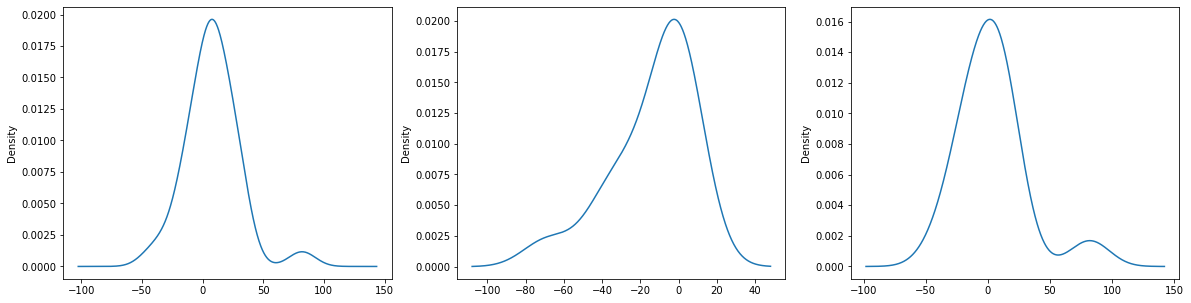

In [133]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20,5))
plt.subplot(131)
pd.Series(differences_0_05).plot.kde()
plt.subplot(132)
pd.Series(differences_05_1).plot.kde()
plt.subplot(133)
pd.Series(differences_0_1).plot.kde()
plt.show()

In [19]:
print(stats.normaltest(differences_0_05))
print(stats.normaltest(differences_05_1))
print(stats.normaltest(differences_0_1))
# returns: statstics = s^2 + k^2, where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest.
# returns: A 2-sided chi squared probability for the hypothesis test

NormaltestResult(statistic=11.878032158553061, pvalue=0.0026346206339835083)
NormaltestResult(statistic=8.88893871626958, pvalue=0.011743335883543012)
NormaltestResult(statistic=15.35861127693463, pvalue=0.0004622957877740249)


/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


If the p value is less than our alpha (significance value), we can reject the hypothesis that this sample data is normally distributed. If greater, we cannot reject the null hypothesis and must conclude the data is normally distributed. 

pvalues 0.002, 0.01, 0.0004 are less than 0.05 --> data ist not normally distributed

In [20]:
#stat, p = stats.shapiro(differences)
print(stats.shapiro(differences_0_05))
print(stats.shapiro(differences_05_1))
print(stats.shapiro(differences_0_1))

(0.9247536063194275, 0.02803279645740986)
(0.821892499923706, 0.005400447640568018)
(0.8488003611564636, 0.013082301244139671)


Differenzen sind nicht normalverteilt! --> Wilcoxon signed rank test (designed for paired comparisons on non-normal data)

In [22]:
(wilcoxon0_05, p0_05) = stats.wilcoxon(differences_0_05)
(wilcoxon05_1, p05_1) = stats.wilcoxon(differences_05_1)
(wilcoxon0_1, p0_1) = stats.wilcoxon(differences_0_1)
print(wilcoxon0_05, p0_05)
print(wilcoxon05_1, p05_1)
print(wilcoxon0_1, p0_1)

#returns:
# statistics and pvalue
# statistics: If alternative is “two-sided”, the sum of the ranks of the differences above or below zero, whichever is smaller. Otherwise the sum of the ranks of the differences above zero.

132.5 0.03960803372609029
7.0 0.02079521585359911
50.5 0.9000122752351998


##### Results:
* von 0 nach 05:
  * sehr kleines p (0.03) --> your data are unlikely with a true null --> null, dass sie von der gleichen population kommen also unwahrscheinlich --> signifikantes ergebnis, dass es einen effekt gab
  * effektstärke? scheint nicht sehr hoch zu sein
* von 05 nach 1:
  * kleines p (0.02) --> daten sind unwahrscheinlich mit null hypothese, dass sie von gleicher population kommen --> signifikantes ergebnis. Beweise für einen effekt gefunden
  * effektstärke: 7.0 Gering?
* von 0 nach 1:
  * großes p 0.9 --> können null hypothese nicht verwerfen --> keine beweise für effekt


### 1.2 Freitext zu "Was ist KI"
#### 1.2.1 Teacher Rating

* T0: AI-1-v2-1-2
* T1: 'AI-4-v2-1-3'

In [33]:
surveySliderStatistics(pupil_performance_df["AI-1-v2-1-2_rating_content"])
surveySliderStatistics(pupil_performance_df["AI-4-v2-1-3_rating_content"])

AI-1-v2-1-2_rating_content
Q1: 4.0 and Q3: 5.0
median: 5.0
mean: 4.4
std: 0.74
min: 2.0 und max: 5.0

AI-4-v2-1-3_rating_content
Q1: 4.0 and Q3: 5.0
median: 5.0
mean: 4.333333333333333
std: 0.96
min: 2.0 und max: 5.0



In [28]:
differences_content = calculateDifferences(pupil_performance_df[["AI-4-v2-1-3_rating_content", "AI-1-v2-1-2_rating_content"]])
print(stats.normaltest(differences_content))
print(stats.wilcoxon(differences_content))

NormaltestResult(statistic=2.766192388561953, pvalue=0.25080082160769834)
WilcoxonResult(statistic=50.5, pvalue=0.8967427520264305)


results:
* daten nicht normalverteilt
* pvalue ist sehr groß (=0.90) --> your data are likely with a true null --> null war: observed difference in the sample does not reflect a true difference between populations --> keine beweise dafür, dass das Paket einen Effekt auf die content ratings hatten

#### 1.2.2 Analyse nach eigenen Kriterien
##### 1.2.2.1 wie haben sich die null answers verändert
* #AI-1-v2-1-2_null_answer, AI-4-v2-1-3_null_answer, ML-2-1-2_null_answer, EvalML-1-7_null_answer

Nullanswers sind True, wenn:
* Die SuS sagen, dass sie es nicht wissen
* sie nichts abgeben (bzw nur . etc)
* sie nicht auf die frage antworten ("lul" etc)
Wenn sie versuchen zu antworten, ist nullanswer False, sogar wenn die antwort kurz und falsch ist.

False    38
True      2
Name: AI-1-v2-1-2_null_answer, dtype: int64

False    27
True      3
Name: AI-4-v2-1-3_null_answer, dtype: int64

AI-1-v2-1-2_null_answer has: 5.0% True null answers: 95.0% right answers
AI-4-v2-1-3_null_answer has: 10.0% True null answers: 90.0% right answers


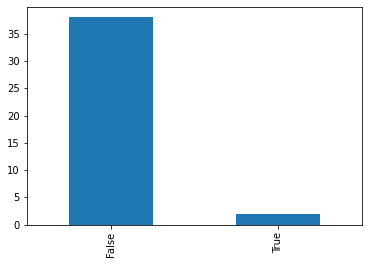

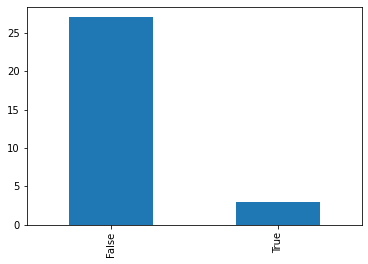

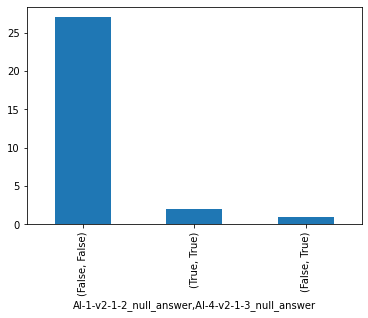

In [53]:
print(pupil_performance_df1["AI-1-v2-1-2_null_answer"].value_counts())
print("")
print(pupil_performance_df1["AI-4-v2-1-3_null_answer"].value_counts())
print("")

print_boolean_percentages(pupil_performance_df1["AI-1-v2-1-2_null_answer"])
print_boolean_percentages(pupil_performance_df1["AI-4-v2-1-3_null_answer"])

pupil_performance_df1["AI-1-v2-1-2_null_answer"].value_counts().plot(kind="bar")
plt.show()
pupil_performance_df1["AI-4-v2-1-3_null_answer"].value_counts().plot(kind="bar")
plt.show()
pupil_performance_df1[["AI-1-v2-1-2_null_answer", "AI-4-v2-1-3_null_answer"]].value_counts().plot(kind="bar")
plt.show()

##### Results:
* insgesamt weniger antworten geworden
* insgesamt wenige nullanswers
* ratio hat sich minimal verschlechtert, weil ein SuS davor eine richtige antwort gegeben hat, danach keine.2 davor, 3 danach. in prozent: 5 --> 10

##### 1.2.2.2 Bei richtigen antworten

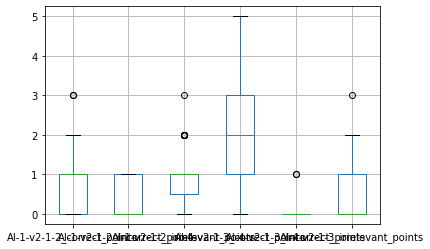

In [220]:
pupil_performance_df1.boxplot(column=["AI-1-v2-1-2_correct_points", 'AI-1-v2-1-2_incorrect_points', 'AI-1-v2-1-2_irrelevant_points', "AI-4-v2-1-3_correct_points", "AI-4-v2-1-3_incorrect_points", "AI-4-v2-1-3_irrelevant_points"])
plt.show()

##### Results:
* lernzuwwachs bei correcten (1 und 4)
* weniger misskonzepte (2 und 5)
* gleich viele bis leicht mehr irrelevante

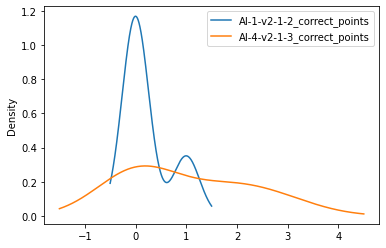

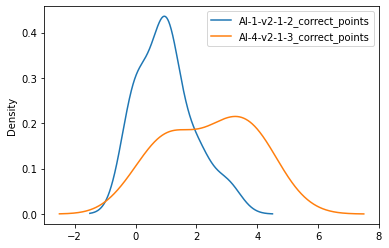

In [219]:
#"AI-1-v2-1-2_correct_points", 'AI-1-v2-1-2_incorrect_points', 'AI-1-v2-1-2_irrelevant_points', "AI-4-v2-1-3_correct_points", "AI-4-v2-1-3_incorrect_points", "AI-4-v2-1-3_irrelevant_points"
pupil_performance_df1.groupby("classId")[["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"]].plot.kde()
plt.show()

##### Results:
* große unterschiede bei den klassen: eine klasse wusste davor teilweise schon viel. danach trotzdem mehr
* andere klasse hat danach auch noch schlechte ergebnisse. vllt hatten die zu wenig zeit. haben allgemein sehr wenig geschrieben da

In [58]:
for columnName in ["AI-1-v2-1-2_correct_points", 'AI-1-v2-1-2_incorrect_points', 'AI-1-v2-1-2_irrelevant_points', "AI-4-v2-1-3_correct_points", "AI-4-v2-1-3_incorrect_points", "AI-4-v2-1-3_irrelevant_points"]+["ML-2-1-2_correct_points", 'ML-2-1-2_incorrect_points', 'ML-2-1-2_irrelevant_points', "EvalML-1-7_correct_points", "EvalML-1-7_incorrect_points", "EvalML-1-7_irrelevant_points"]:
    surveySliderStatistics(pupil_performance_df1[columnName])

AI-1-v2-1-2_correct_points
Q1: 0.0 and Q3: 1.0
median: 1.0
mean: 0.725
std: 0.85
min: 0 und max: 3

AI-1-v2-1-2_incorrect_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.4
std: 0.5
min: 0 und max: 1

AI-1-v2-1-2_irrelevant_points
Q1: 0.0 and Q3: 1.0
median: 1.0
mean: 0.975
std: 0.77
min: 0 und max: 3

AI-4-v2-1-3_correct_points
Q1: 1.0 and Q3: 3.0
median: 2.0
mean: 1.9666666666666666
std: 1.54
min: 0.0 und max: 5.0

AI-4-v2-1-3_incorrect_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.06666666666666667
std: 0.25
min: 0.0 und max: 1.0

AI-4-v2-1-3_irrelevant_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.5333333333333333
std: 0.82
min: 0.0 und max: 3.0

ML-2-1-2_correct_points
Q1: 0.0 and Q3: 1.0
median: 0.5
mean: 0.6538461538461539
std: 0.8
min: 0.0 und max: 3.0

ML-2-1-2_incorrect_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.34615384615384615
std: 0.56
min: 0.0 und max: 2.0

ML-2-1-2_irrelevant_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.38461538461538464
std: 0.64
min: 0.0 und max

In [19]:
# AI-1-v2-1-2, AI-4-v2-1-3
KIdifferences_correct = calculateDifferences(pupil_performance_df1[["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"]])
KIdifferences_incorrect = calculateDifferences(pupil_performance_df1[["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"]])
KIdifferences_irrelevant = calculateDifferences(pupil_performance_df1[["AI-4-v2-1-3_irrelevant_points", "AI-1-v2-1-2_irrelevant_points"]])

print(stats.normaltest(KIdifferences_correct))
print(stats.normaltest(KIdifferences_incorrect))
print(stats.normaltest(KIdifferences_irrelevant))

NormaltestResult(statistic=3.874293801757422, pvalue=0.14411453683480452)
NormaltestResult(statistic=1.3872594737579118, pvalue=0.49975878004628216)
NormaltestResult(statistic=7.025391128379736, pvalue=0.029816433903935343)


* Hier ist durch zufall einmal eine Differenz (KIdifferences_irrelevant) normalverteilt. Verwende trotzdem Wilcoxon, weil nicht parametrische tests auch dafür verwendet werden können und so die vergleichbarkeit zwischen den test gegeben bleibt

In [21]:
print(stats.wilcoxon(KIdifferences_correct))
print(stats.wilcoxon(KIdifferences_incorrect))
print(stats.wilcoxon(KIdifferences_irrelevant))

WilcoxonResult(statistic=0.0, pvalue=8.648862220370397e-05)
WilcoxonResult(statistic=7.0, pvalue=0.0022819372533154484)
WilcoxonResult(statistic=40.5, pvalue=0.03774344318222747)


##### Results:
  * sehr signifikantes ergebnis für korrekte: nehmen zu
  * sehr signifikantes für inkorrekte: müssten abnehmen, aber das sieht man hier nicht gut
  * sogar knapp signifikant für irrelevante
  
##### Generelle Beobachtungen:
* Eine Klasse scheint schon etwas zu KI gemacht zu haben. Es viel zB oft der Begriff Deep Learning und Maschinelles Lernen. 
* Einige Beiträge scheinen kopiert zu sein. Haben immer korrekte Rechtschreibung, sind z.T. noch formatiert und inhaltlich entweder nicht ganz passend oder gehen zu weit, zB was aktuell Stand der Forschung ist.
* Die SuS überschätzen außerdem ihr anfängliches Wissen.

### 1.3 Was ist KI - MC
#### 1.3.1 Was ist KI - MC - Wo ist KI drinne?
* AI-2-v2-1-1
* "EvalML-1-4"
* AI-4-v2-1-2 antworten 1-2
* EvalML-1-3 antworten 1-3: was ist KI

In [123]:
analyse_mc(["AI-2-v2-1-1"], 4)

AI-2-v2-1-1
Kannst du erkennen, wo KI überall drin steckt? Denke dabei an die Eigenschaften, die alle KI-Anwendungen verbindet. Bei Multiple-Choice Aufgaben, neben denen “Mehrfachauswahl” steht, können mehrere Antworten richtig sein. Wähle alle richtigen Antworten aus. Wenn du mal nicht weiter weißt, kannst du dir auch einen Tipp holen.
*Der Newsfeed eines Social Network nutzt KI - True
*Die Personalisierung einer Google-Anfrage nutzt KI - True
*Die Startseite einer Webseite, die jedem Besucher die gleichen Inhalte anzeigt nutzt KI - False
*Gesichtserkennung nutzt KI - True
[True, True, False, True]

[0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 2, 0, 1, 3, 2, 1, 2, 1, 2, 2, 0, 1, 1, 0, 3]
number errors per student value counts
0    19
1     9
2     7
3     2
dtype: int64
mean number of errors: 0.7837837837837838
MannwhitneyuResult(statistic=292.5, pvalue=5.019909180400319e-06)

Average p-value over 100 tries: 7.066255314998775e-05


##### results:
* 0.78 statt erwarteter 2 errors. p-value 1.56e-05 --> signifikanz

In [124]:
print_mc(["AI-4-v2-1-2"])
print("Average p-value mannwhitneyu: ", mannwhitneymanual(analyse_partial_mc("AI-4-v2-1-2", 1, 2), 2))

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True
*Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen - True
*Ein Spam-Filter ist eine allgemeinen KI - False
*Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht - True
[True, True, False, True, True, False, True]

[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]
Average number errors: AI-4-v2-1-2 0.6129032258064516
Expected number errors: AI-4-v2-1-2 1.0
Average p-value mannwhitneyu:  0.0498183422062804


In [125]:
analyse_combined_mcs("EvalML-1-3", "EvalML-1-4", 1, 3, 1, 4)

EvalML-1-3
Welche der Aussagen stimmen?
*KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen - True
*Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren - False
*Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist - False
*Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich - True
*Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI - False
*Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI - True
*Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören - False
*KI kann irgendwann alles besser als der Mensch - False
*Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen - True
[True, False, False, True, False, True, False, False, True]

EvalML-1-4
Welche der folgenden Anwendung

#### Results:
* 0.8+0.73=1.5 fehler statt 1.5+2=3.5 expected raten also nicht nur --> erkennen, wo ki drin ist
* small p-value 0.02 --> probability of obtaining test results under the assumption that the null hypothesis is correct are small --> alternative hypothesis more likely --> different populations --> Lernzuwachs
* TODO: wo sind die meisten misskonzepte? bei welcher antwort gab es die meisten probleme? Was wurde am wenigsten verstanden?

### 1.4 Was ist KI - Korrelationen
* Selbsteinschätzung: T0, T0.5, T1
  * T0 "AI-1-v2-1-1"
  * T0.5 "AI-4-v2-1-4"
  * T1 "EvalML-1-1"
* Freitext: content rating teacher
  * T0 "AI-1-v2-1-2_rating_content"
  * T1 "AI-4-v2-1-3_rating_content"
* eigene ratings: correcte, incorrecte, neutrale
  * T0 "AI-1-v2-1-2_correct_points", 'AI-1-v2-1-2_incorrect_points', 'AI-1-v2-1-2_irrelevant_points'
  * T1 "AI-4-v2-1-3_correct_points", "AI-4-v2-1-3_incorrect_points", "AI-4-v2-1-3_irrelevant_points"
* MC: anzahl fehler?

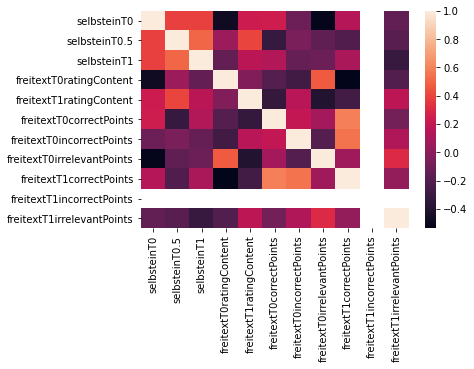

,selbsteinT0,selbsteinT0.5,selbsteinT1,freitextT0ratingContent,freitextT1ratingContent,freitextT0correctPoints,freitextT0incorrectPoints,freitextT0irrelevantPoints,freitextT1correctPoints,freitextT1incorrectPoints,freitextT1irrelevantPoints
selbsteinT0,1.000000,0.383593,0.385211,-0.472836,0.236410,0.243716,-0.111308,-0.520003,0.147209,NaN,-0.151327
selbsteinT0.5,0.383593,1.000000,0.502217,0.059546,0.405577,-0.316237,-0.055777,-0.152794,-0.217362,NaN,-0.177812
selbsteinT1,0.385211,0.502217,1.000000,-0.143267,0.172060,0.140973,-0.129573,-0.112026,0.107641,NaN,-0.312400
freitextT0ratingContent,-0.472836,0.059546,-0.143267,1.000000,-0.037346,-0.198933,-0.269856,0.466814,-0.535660,NaN,-0.208742
freitextT1ratingContent,0.236410,0.405577,0.172060,-0.037346,1.000000,-0.319709,0.163252,-0.393718,-0.265588,NaN,0.182041
freitextT0correctPoints,0.243716,-0.316237,0.140973,-0.198933,-0.319709,1.000000,0.197450,0.088051,0.592041,NaN,-0.080532
freitextT0incorrectPoints,-0.111308,-0.055777,-0.129573,-0.269856,0.163252,0.197450,1.000000,-0.198196,0.546517,NaN,0.131266
freitextT0irrelevantPoints,-0.520003,-0.152794,-0.112026,0.466814,-0.393718,0.088051,-0.198196,1.000000,0.069633,NaN,0.306622
freitextT1correctPoints,0.147209,-0.217362,0.107641,-0.535660,-0.265588,0.592041,0.546517,0.069633,1.000000,NaN,0.030480
freitextT1incorrectPoints,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
correlation_df_ki = pupil_performance_df1[["AI-1-v2-1-1","AI-4-v2-1-4", "EvalML-1-1", "AI-1-v2-1-2_rating_content", "AI-4-v2-1-3_rating_content", "AI-1-v2-1-2_correct_points", 'AI-1-v2-1-2_incorrect_points', 'AI-1-v2-1-2_irrelevant_points', "AI-4-v2-1-3_correct_points", "AI-4-v2-1-3_incorrect_points", "AI-4-v2-1-3_irrelevant_points"]].dropna()
correlation_df_ki.columns = ["selbsteinT0", "selbsteinT0.5", "selbsteinT1", "freitextT0ratingContent", "freitextT1ratingContent", "freitextT0correctPoints","freitextT0incorrectPoints","freitextT0irrelevantPoints","freitextT1correctPoints","freitextT1incorrectPoints","freitextT1irrelevantPoints"]

sns.heatmap(correlation_df_ki.corr(method='spearman'))
plt.show()

correlation_df_ki.corr(method='spearman')

##### Results:
* strongest correlations
  * selbsteinschätzungen untereinander
  * correct points freitext T0und correct points freitext T1: wer am anfang schon viel weiß, weiß danach immer noch viel
  * Weird: positive korrelation zwischen inkorrect points freitext T0 und korrekt points freitext T1: wer davor viel geschrieben hat und etwas gelernt hat, schreibt danach auch mehr richtiges?
  * freitext content rating T0 korreliert stark mit anzahl irrelevant points der antworten: lehrer bewerten eher nach länge, nicht nach qualität? anzahl correkt points korreliert hier auch leicht negativ mit anzahl korrekt points
* einschätzung bei t0 und t1 korreliert nur schwach mit performance in freitext nach mir (leicht positiv mit korrekten, leicht negativ mit incorrekten, )

# TODO: 
* p-values der korrelationen: https://stackoverflow.com/questions/52741236/how-to-calculate-p-values-for-pairwise-correlation-of-columns-in-pandas 

## 2. Unterschied spezifisch und allgemeine KI
### 2.1 Selbsteinschätzungen
<b>Hier gibt es keinen T0, nur T0.5 und T1</b>
* 'AI-4-v2-1-5', 'Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?')
* 'EvalML-1-2'

AI-4-v2-1-5
Q1: 58.5 and Q3: 100.0
median: 85.0
mean: 76.3225806451613
std: 25.2
min: 18.0 und max: 100.0

EvalML-1-2
Q1: 61.0 and Q3: 100.0
median: 90.0
mean: 78.93333333333334
std: 25.32
min: 30.0 und max: 100.0



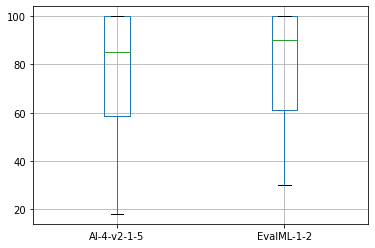

In [200]:
surveySliderStatistics(pupil_performance_df["AI-4-v2-1-5"])
surveySliderStatistics(pupil_performance_df["EvalML-1-2"])

pupil_performance_df.boxplot(column=['AI-4-v2-1-5', 'EvalML-1-2'])
plt.show()

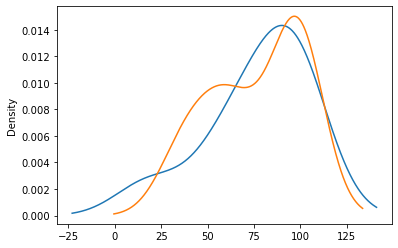

NormaltestResult(statistic=12.51027121561943, pvalue=0.001920565494715652)
Shapiro Results:  (0.7897635102272034, 0.0027249713893979788)
WilcoxonResult(statistic=19.0, pvalue=0.38596207926442694)


/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


In [38]:
# BEIDE SIND NACH DEM PAKET --> KEIN T0!

pupil_performance_df.groupby("classId")["AI-4-v2-1-5"].plot.kde()
plt.show()

# Differnezen berechnen
differences_05_1 = calculateDifferences(pupil_performance_df[["EvalML-1-2", "AI-4-v2-1-5"]])

print(stats.normaltest(differences_05_1))
print("Shapiro Results: ", stats.shapiro(differences_05_1))

print(stats.wilcoxon(differences_05_1))

##### Results:
* gab kein T0
* keine signifikanz zwischen T05 und T1

### 2.2 spezifische vs allgemein KI - MCs
#### 2.2.1 spezifische vs allgemein KI - MCs - Def

In [102]:
analyse_mc(['AI-3-v2-1-2'], 3)

AI-3-v2-1-2
Welche der Aussagen über KI-Anwendungen stimmen?
*Empfehlungssysteme gehören zur spezifischen KI - True
*Programme zur Bilderkennung gehören zur allgemeinen KI - False
*Eine KI aus einem Film, die eigenständige Entscheidungen trifft, mit Menschen spricht und sich am Ende gegen sie wendet, gehört zur allgemeinen KI - True
[True, False, True]

[0, 1, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 2, 1, 1, 0, 1, 0, 1, 3, 0, 2, 1, 0, 1, 0, 3, 0, 1, 2, 2, 3, 3, 2, 0]
number errors per student value counts
0    14
1     9
2     8
3     4
dtype: int64
mean number of errors: 1.0571428571428572
MannwhitneyuResult(statistic=394.5, pvalue=0.003980680332420922)

Average p-value over 100 tries: 0.04789484997288251


##### Results:
* mean errors: 1.05. zu erwaten bei chance: 1.5 --> besser als raten
* p-value um 0.05 --> manchmal signifikanz

In [103]:
print_mc(["AI-4-v2-1-2"])
print("Average p-value mannwhitneyu: ", mannwhitneymanual(analyse_partial_mc("AI-4-v2-1-2", 4, 7), 4))

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True
*Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen - True
*Ein Spam-Filter ist eine allgemeinen KI - False
*Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht - True
[True, True, False, True, True, False, True]

Average number errors: AI-4-v2-1-2 1.4193548387096775
Expected number errors: AI-4-v2-1-2 2.0
Average p-value mannwhitneyu:  0.0396480008702966


##### Results:
* average errors = 1.4 statt 2 expected errors. p-value 0.029 --> signifikanz

In [104]:
print_mc(["EvalML-1-3"])
print("Average p-value mannwhitneyu: ", mannwhitneymanual(analyse_partial_mc("EvalML-1-3", 4, 7), 4))

EvalML-1-3
Welche der Aussagen stimmen?
*KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen - True
*Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren - False
*Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist - False
*Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich - True
*Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI - False
*Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI - True
*Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören - False
*KI kann irgendwann alles besser als der Mensch - False
*Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen - True
[True, False, False, True, False, True, False, False, True]

Average number errors: EvalML-1-3 0.46666

##### Results:
* average error 0.46 statt expected 2 --> besser als chance. p-value 0.0005 --> signifikanz

#### 2.2.2 spezifische vs allgemein KI - MCs - Intelligenz

In [90]:
analyse_combined_mcs("AI-4-v2-1-1", "AI-4-v2-1-2", 1, 4, 3, 3)

AI-4-v2-1-1
Was bedeuten diese Unterscheidung zwischen spezifischer und allgemeiner KI jetzt für die Intelligenz von KI-Anwendungen?
*KI-Anwendungen sind allgemein intelligent - False
*KI-Anwendungen zeigen intelligentes Verhalten in einem kleinen Bereich - True
*Intelligentes Verhalten in einem spezifischen Bereich muss nicht gleich allgemeine Intelligenz bedeuten - True
*Eine KI, die sich in einem einzigen Bereich so intelligent verhält wie ein Mensch, muss allgemeine Intelligenz besitzen - False
[False, True, True, False]

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True
*Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen - True
*Ein Spam-Filter ist eine a

##### Results:
* expected errors: 0.90+0.35=1.25 statt 2+0.5=2.5 --> besser als chance
* p-value 0.0097 --> signifikanz

## 3. Was ist ML?
### 3.1 Selbsteinschätzung
* T0: 'ML-2-1-1' 'Wie gut weißt du schon, was Maschinelles Lernen ist?'
* T1: 'EvalML-1-5' Wie gut hast du verstanden, was maschinelles Lernen ist?

ML-2-1-1
Q1: 53.0 and Q3: 79.0
median: 65.0
mean: 67.03448275862068
std: 18.23
min: 28.0 und max: 100.0

EvalML-1-5
Q1: 55.0 and Q3: 78.0
median: 69.0
mean: 66.53333333333333
std: 21.69
min: 24.0 und max: 100.0



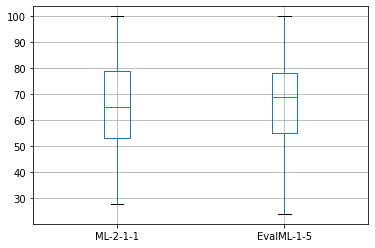

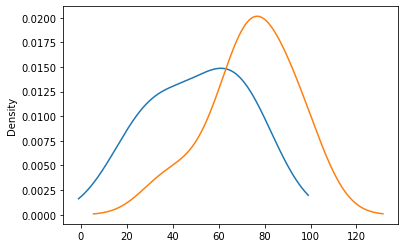

In [212]:
surveySliderStatistics(pupil_performance_df["ML-2-1-1"])
surveySliderStatistics(pupil_performance_df["EvalML-1-5"])

pupil_performance_df.boxplot(column=['ML-2-1-1', 'EvalML-1-5'])
plt.show()

pupil_performance_df.groupby("classId")["EvalML-1-5"].plot.kde()
plt.show()
#pupil_performance_df.groupby("classId")["EvalML-1-5"].plot.hist()
#plt.show()

In [34]:
differences_0_1 = calculateDifferences(pupil_performance_df[["EvalML-1-5", "ML-2-1-1"]])

print(stats.normaltest(differences_0_1))
print("ShapirotestResult", stats.shapiro(differences_0_1))
print(stats.wilcoxon(differences_0_1))

NormaltestResult(statistic=10.013355638653952, pvalue=0.006693102106085678)
ShapirotestResult (0.8583999872207642, 0.02288571000099182)
WilcoxonResult(statistic=60.0, pvalue=1.0)


/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


##### Ergebnis:
* sehr großes p (1.0) --> sehr wahrscheinlich unter null hypothese! keine beweise sprechen für effekt
* Großer Unterschied zwischen der Einschätzung der beiden Klassen! (Eine hatte schon Teile des Themas behandelt)

### 3.2 Freitexte - Was ist ML
* 'ML-2-1-1' - Weißt du vielleicht schon etwas über das maschinelle Lernen?
* 'EvalML-1-7' - Was ist ML in eigenen Worten

#### 3.2.1 nach teacher ratings

In [29]:
differences_content = calculateDifferences(pupil_performance_df[["EvalML-1-7_rating_content", "ML-2-1-2_rating_content"]])

print(stats.normaltest(differences_content))
print(stats.wilcoxon(differences_content))


NormaltestResult(statistic=8.16263914484619, pvalue=0.016885169741055885)
WilcoxonResult(statistic=10.5, pvalue=0.28702974430361805)


/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))
/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Results:
* zu wenige SuS bisher --> nicht applicable
* zu hoher p-Wert (0.29) --> your data are likely with a true null --> null war: observed difference in the sample does not reflect a true difference between populations --> keine beweise dafür, dass das Paket einen Effekt auf die content ratings hatten

#### 3.2.2 Was ist ML - Freitext - Analyse nach eigenen Kategorien
##### 3.2.2.1 Was ist ML - Freitext - Analyse nach eigenen Kategorien - Anzahl Nullanswers

False    19
True      7
Name: ML-2-1-2_null_answer, dtype: int64

False    11
True      3
Name: EvalML-1-7_null_answer, dtype: int64

ML-2-1-2_null_answer has: 26.923076923076923% True null answers: 73.07692307692308% right answers
EvalML-1-7_null_answer has: 21.42857142857143% True null answers: 78.57142857142857% right answers


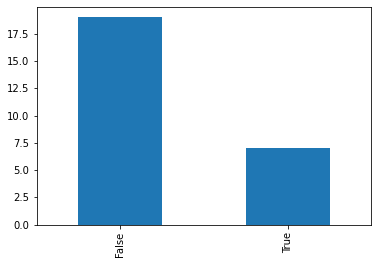

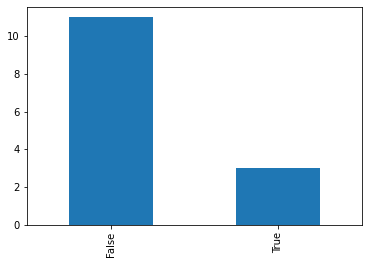

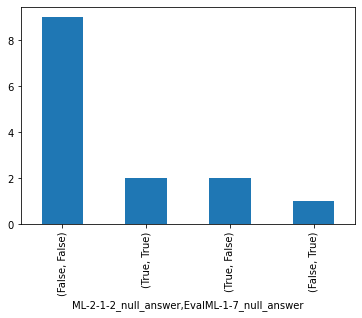

In [202]:
print(pupil_performance_df1["ML-2-1-2_null_answer"].value_counts())
print("")
print(pupil_performance_df1["EvalML-1-7_null_answer"].value_counts())
print("")

print_boolean_percentages(pupil_performance_df1["ML-2-1-2_null_answer"])
print_boolean_percentages(pupil_performance_df1["EvalML-1-7_null_answer"])

pupil_performance_df1["ML-2-1-2_null_answer"].value_counts().plot(kind="bar")
plt.show()
pupil_performance_df1["EvalML-1-7_null_answer"].value_counts().plot(kind="bar")
plt.show()
pupil_performance_df1[["ML-2-1-2_null_answer", "EvalML-1-7_null_answer"]].value_counts().plot(kind="bar")
plt.show()

##### Results:
* zu wenige Antworten
* deutlich mehr nullanswers bei dieser frage
* verbesserung: weniger nullanswers! von 26 --> 21

##### 3.2.2.1 Was ist ML - Freitext - Analyse nach eigenen Kategorien - Richtige Antworten

<AxesSubplot:>

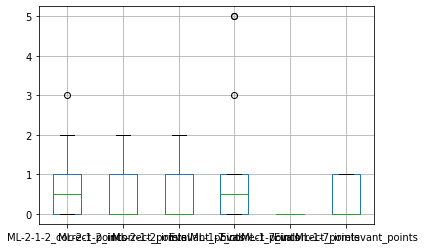

In [197]:
pupil_performance_df1.boxplot(column=["ML-2-1-2_correct_points", 'ML-2-1-2_incorrect_points', 'ML-2-1-2_irrelevant_points', "EvalML-1-7_correct_points", "EvalML-1-7_incorrect_points", "EvalML-1-7_irrelevant_points"])

##### results:
* kein effekt bei korrekten, außer bei wenigen, die sehr viel mitgenommen haben (zu langes paket? oder zu viele fragen für eval nacheinander? oder paket selber verwirrend)
* weniger misskonzepte
* leicht weniger irrelevantes

Hier könnte ich noch zeigen, dass die antworten insgesamt kürzer geworden sind. vllt sogar für leute, die davor viel geantwortet haben

##### Signifikanz

In [26]:
MLdifferences_correct = calculateDifferences(pupil_performance_df1[["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"]])
MLdifferences_incorrect = calculateDifferences(pupil_performance_df1[["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"]])
MLdifferences_irrelevant = calculateDifferences(pupil_performance_df1[["EvalML-1-7_irrelevant_points", "ML-2-1-2_irrelevant_points"]])

print(stats.normaltest(MLdifferences_correct))
print(stats.normaltest(MLdifferences_incorrect))
print(stats.normaltest(MLdifferences_irrelevant))

print(stats.wilcoxon(MLdifferences_correct))
print(stats.wilcoxon(MLdifferences_incorrect))
print(stats.wilcoxon(MLdifferences_irrelevant))


NormaltestResult(statistic=9.130519130868004, pvalue=0.010407177512593237)
NormaltestResult(statistic=16.260332111767045, pvalue=0.0002945192900840264)
NormaltestResult(statistic=2.489122587516203, pvalue=0.28806725731752714)
WilcoxonResult(statistic=6.5, pvalue=0.3990751965482372)
WilcoxonResult(statistic=0.0, pvalue=0.10247043485974937)
WilcoxonResult(statistic=16.0, pvalue=0.763024600552995)


/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))
/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


#### results:
* nirgendwo signifikanz! aber auch noch zu wenige Daten! 

### 3.3 - Was ist ML - MC

In [105]:
analyse_mc(['EvalML-1-8'], 8)

EvalML-1-8
Welche der Aussagen über maschinelles Lernen stimmen?
*Algorithmen des maschinellen Lernens können aus vorhandenen Daten selbständig lernen - True
*Beim überwachten Lernen nutzen wir Daten ohne Label - False
*Beim unüberwachten Lernen versuchen wir, Strukturen in den Daten zu entdecken - True
*Clustering ist ein Beispiel für unüberwachtes Lernen - True
*Wenn wir für Daten Label vorhersagen wollen, betreiben wir Clustering - False
*Wenn wir für Daten Label vorhersagen wollen, betreiben wir überwachtes Lernen - True
*Algorithmen des maschinellen Lernens lernen nur, was in den Daten vorhanden ist. Daher ist die Auswahl an Trainingsdaten sehr wichtig - True
*Algorithmen des maschinellen Lernens benötigen oft große Mengen an Daten, damit sie gute Ergebnisse erzielen - True
[True, False, True, True, False, True, True, True]

[0, 0, 1, 0, 2, 0, 2, 2, 3, 3, 6, 6, 4, 6, 0]
number errors per student value counts
0    5
6    3
2    3
3    2
4    1
1    1
dtype: int64
mean number of err

Result:
* 2.33 weit unter bei chance 4 --> kein chance
* 0.02 p-value --> signifikanz

### 3.4 - Was ist ML - Korrelationen
* Selbsteinschätzungen:
  * T0: "ML-2-1-1"
  * T1: "EvalML-1-5"
* content ratings
  * T0: ""ML-2-1-2_rating_content"
  * T1: "EvalML-1-7_rating_content"
* freitext eigenes rating:
  * T0 "ML-2-1-2_correct_points", 'ML-2-1-2_incorrect_points', 'ML-2-1-2_irrelevant_points'
  * T1: "EvalML-1-7_correct_points", "EvalML-1-7_incorrect_points", "EvalML-1-7_irrelevant_points"
* MC?

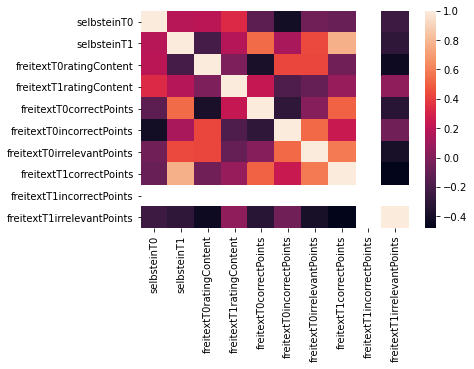

,selbsteinT0,selbsteinT1,freitextT0ratingContent,freitextT1ratingContent,freitextT0correctPoints,freitextT0incorrectPoints,freitextT0irrelevantPoints,freitextT1correctPoints,freitextT1incorrectPoints,freitextT1irrelevantPoints
selbsteinT0,1.000000,0.189581,0.196112,0.333191,-0.125069,-0.407233,-0.050904,-0.082657,NaN,-0.241971
selbsteinT1,0.189581,1.000000,-0.208751,0.181215,0.541164,0.138215,0.437681,0.770438,NaN,-0.296492
freitextT0ratingContent,0.196112,-0.208751,1.000000,-0.008543,-0.378284,0.430548,0.430548,-0.051746,NaN,-0.432934
freitextT1ratingContent,0.333191,0.181215,-0.008543,1.000000,0.239880,-0.175214,-0.091880,0.077991,NaN,0.051566
freitextT0correctPoints,-0.125069,0.541164,-0.378284,0.239880,1.000000,-0.299850,0.019990,0.512294,NaN,-0.321612
freitextT0incorrectPoints,-0.407233,0.138215,0.430548,-0.175214,-0.299850,1.000000,0.536325,0.253885,NaN,-0.051566
freitextT0irrelevantPoints,-0.050904,0.437681,0.430548,-0.091880,0.019990,0.536325,1.000000,0.584102,NaN,-0.386746
freitextT1correctPoints,-0.082657,0.770438,-0.051746,0.077991,0.512294,0.253885,0.584102,1.000000,NaN,-0.480550
freitextT1incorrectPoints,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freitextT1irrelevantPoints,-0.241971,-0.296492,-0.432934,0.051566,-0.321612,-0.051566,-0.386746,-0.480550,NaN,1.000000


In [148]:
correlation_df_ml = pupil_performance_df1[["ML-2-1-1", "EvalML-1-5", "ML-2-1-2_rating_content", "EvalML-1-7_rating_content", "ML-2-1-2_correct_points", 'ML-2-1-2_incorrect_points', 'ML-2-1-2_irrelevant_points', "EvalML-1-7_correct_points", "EvalML-1-7_incorrect_points", "EvalML-1-7_irrelevant_points"]].dropna()
correlation_df_ml.columns = ["selbsteinT0", "selbsteinT1", "freitextT0ratingContent", "freitextT1ratingContent", "freitextT0correctPoints","freitextT0incorrectPoints","freitextT0irrelevantPoints","freitextT1correctPoints","freitextT1incorrectPoints","freitextT1irrelevantPoints"]

sns.heatmap(correlation_df_ml.corr(method='spearman'))
plt.show()

correlation_df_ml.corr(method='spearman')

##### Results:
* starke korrelationen (>0.6):
  * 0.77 selbsteinschätzungT1 und T1 korrekt points
* mittlere korrelationen: (0.4-0.6):
  * selbsteinscht1 und t0correct points, genauso t0 irrelevant points. : vorher was zu wissen, macht selbstbewusst
  * t0 rating content und incorrect und irrelevant points (0.43, 0.43), aber nicht mit den korrekten punkten (-0.378). (bei T1 kaum effekte)
* leicht:
  * selbsteinschätzung leicht negativ mit korrekt points
* ...

## 4. unterschied überwachtes und unüberwachtes?
### 4.1 überwacht vs unüberwacht - Selbsteinschätzung
<b>Es gibt keinen T0, nur einen T1! (Weil ich dachte, das weiß eh keiner)</b>
* 'EvalML-1-6' Wie sehr hast du das Gefühl, verstanden zu haben, was der Unterschied zwischen überwachtem und unüberwachtem Lernen ist?

EvalML-1-6
Q1: 56.0 and Q3: 94.0
median: 69.0
mean: 72.8
std: 20.76
min: 37.0 und max: 100.0



<AxesSubplot:>

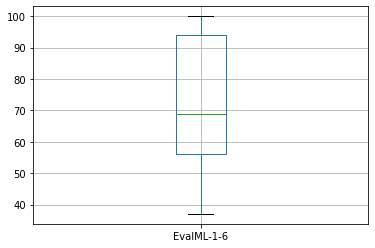

In [182]:
surveySliderStatistics(pupil_performance_df["EvalML-1-6"])
pupil_performance_df.boxplot(column=["EvalML-1-6"])

### 4.2 überwacht vs unüberwacht - MC Definitionen
* MC: 'Classification-1-1-1', 'Was war unüberwachtes Lernen noch gleich?'
* MC: "Clustering-1-1-1" 'Was war unüberwachtes Lernen noch gleich?'

In [106]:
analyse_mc(['Classification-1-1-1', "Clustering-1-1-1"], 5)

Classification-1-1-1
Welche Aussagen stimmen?
*Beim überwachten Lernen braucht man Daten ohne Label - False
*Einen Algorithmus zu trainieren, der Bildern mit Hunden das Label “Hund” gibt, wäre ein Fall für überwachtes Lernen - True
*Beim überwachten Lernen versucht man Struktur in Daten zu finden - False
[False, True, False]

Clustering-1-1-1
Was war unüberwachtes Lernen noch gleich?
*Beim unüberwachten Lernen nutzt man Daten mit Label - False
*Beim unüberwachten Lernen wollen wir die richtigen Label für neue Daten vorhersagen - False
*Beim unüberwachten Lernen hat man keine Label für die Daten - True
*Beim unüberwachten Lernen geht es darum, Struktur in den Daten zu finden - True
[False, False, True, True]

[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 3, 1, 3, 0, 1, 3, 4, 2, 4, 2, 0]
number errors per student value counts
0    9
1    5
3    3
4    2
2    2
dtype: int64
mean number of errors: 1.2380952380952381
MannwhitneyuResult(statistic=100.5, pvalue=0.0010368328558601483)

Average p-value over 1

#### Result:
* im durchschnitt 1.24 Fehler in den 7 Antworten. Da bei Clustering-1-1-1 jeweils zwei der Antworten sich gegenseitig ausschließen, gibt es quasi 5 richtige antworten. Dabei wären 2.5 fehler zu erwarten wären. 3.5 bei komplettem raten --> scheinen gelernt zu haben!
* 2/3 der Sus haben nur einen oder keinen Fehler
* 5/21 haben 2 oder 3 fehler
* nur 2/21 haben 4 von 7 antworten falsch
* ergebnisse sind bei fast allen besser als raten --> scheinen Gelernt zu haben!
* p-value 0.001 --> signifikanz

### 4.3 überwacht vs unüberwacht - MC transfer

In [110]:
print_mc(['ML-3-1-2', 'ML-3-1-3', 'ML-3-1-4'])
mc_analysis(['ML-3-1-2', 'ML-3-1-3', 'ML-3-1-4'])

# hier hab ich das händisch mann whitney berechnet!
nr_errors = [i/2 for i in [2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 2, 4, 2, 2, 4, 6, 5, 4, 2, 6, 2, 4, 4, 2, 2, 6, 4]]

p_array = []
for i in range(100):
    p_array.append(stats.mannwhitneyu(nr_errors, random_mcs(len(nr_errors), 3))[1])

average_p_value = np.mean(p_array)
print(average_p_value)

ML-3-1-2
Ein Empfehlungssystem für Musik, das lernt, was du für Musik magst und dann für neu erscheinende Musik voraussagt, ob du sie mögen würdest.
*Überwachtes Lernen - True
*Unüberwachtes Lernen - False
[True, False]

ML-3-1-3
Die Gesichtserkennung von deinem Handy. Anfangs musst du dein Gesicht aus verschiedenen Winkeln filmen. Anhand dieser Beispiele lernt es, dein Gesicht zu erkennen. Wenn dann irgendein Gesicht versucht, dein Handy zu entsperren, kann es voraussagen, ob es dein Gesicht ist oder nicht.
*Überwachtes Lernen - True
*Unüberwachtes Lernen - False
[True, False]

ML-3-1-4
Wenn wir Youtuber nach der Anzahl ihrer Follower und der Themen ihrer Videos gruppieren.
*Überwachtes Lernen - False
*Unüberwachtes Lernen - True
[False, True]

[2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 2, 4, 2, 2, 4, 6, 5, 4, 2, 6, 2, 4, 4, 2, 2, 6, 4]
number errors per student value counts
2    14
4    10
6     3
5     1
dtype: int64
mean number of errors: 3.25
0.2660501437529058


##### Results:
* da die antworten sich gegenseitig ausschließen, gab es quasi nur 3 mögliche Antworten. Schnitt von 3.21/2 --> 1.6. Nicht besser als raten!
* p-value: 0.24 --> keine signifikanz --> null hypothese kann nicht verworfen werden --> kommt vermutlich von gleicher verteilung --> also raten
* vllt waren die ersten texte nicht gut genug? oder es war zu viel transfer dafür, dass sie die beiden paradigmen gerade erst theoretisch kennen gelernt haben. möglich wäre auch, etwas praxis einzubauen

In [111]:
analyse_mc(['Classification-2-1-8'], 3)

Classification-2-1-8
Welche Aussagen stimmen?
*Ein Algorithmus, der dir basierend auf deinen Lieblingsfächern einen Beruf vorschlägt, könnte man mittels überwachtem Lernen umsetzen - True
*Ein Algorithmus, der ähnliche Berufe gruppiert, gehört zum überwachten Lernen - False
*Ein Algorithmus, der anhand vieler alter Fälle gelernt hat, medizinische Diagnosen zu stellen, gehört zum überwachten Lernen - True
[True, False, True]

[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 3, 3, 1, 2, 3]
number errors per student value counts
0    12
1     4
3     3
2     2
dtype: int64
mean number of errors: 0.8095238095238095
MannwhitneyuResult(statistic=89.0, pvalue=0.0003072757076917003)

Average p-value over 100 tries: 0.01664511955123943


#### Results:
* hier liegt die performance von 0.81 unter dem Chance von 1.5 bei den 3 antwortmöglichkeiten
* p-value: 0.01 --> signifikanz

In [112]:
analyse_mc(["EvalML-1-9"], 2)

EvalML-1-9
Welche Art des Lernens sind folgende Aufgaben?
*Eine Webseite, die für neue Rezepte vorhersagt, ob sie dir “gefallen” oder “nicht gefallen”, ist eine Aufgabe für das überwachte Lernen - True
*Eine Webseite, die ähnliche Rezepte gruppiert, wäre eine Aufgabe für das Clustering - True
[True, True]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
number errors per student value counts
0    8
1    7
dtype: int64
mean number of errors: 0.4666666666666667
MannwhitneyuResult(statistic=75.5, pvalue=0.043736453522555396)

Average p-value over 100 tries: 0.05576746901850085


##### Results:
* bei der Eval-1-9 gab es zwei mögliche Richtige. erwartet wären 1 error, mean errors: 0.46 --> besser als raten
* p-value: um 0.05 --> oft gerade nicht mehr signifikanz
* scheint schwierig zu sein, die beiden paradigmen zu utnerscheiden, wenn transfer dabei ist. also bei neuen aufgaben. 

## 5. Grenzen ML / Traininsdaten
### 5.1 Grenzen ML / Traininsdaten - Freitext

In [138]:
pupil_performance_df1["LimitsML-1-2"]

pupilId
bniRycMi5bwrXjvGy    Dann würde der Algorithmus denken, dass Hunde ...
sqBXKssFvS8pFYAMv    Dann würde der Algorithmus nur Seehund als Hun...
Kd6FuRsrq6QvPrkKp                                                  NaN
6bBwnX2mwAp2NAwNR                                                  NaN
ZTvPk2i77LDC8pFmu    dann würde der computer bei seehunden sagen da...
rsATbrReo6odn6oXD                                                  NaN
FhFN5eiQduwiYKWEn                                                  NaN
Ay6mfswm3SFcQdNJg    Auf einmal würde der Algorithmus anfangen alle...
hn2oJ5p2CwPfG44wx    Dann würde das Algorithmus nur Seehunde als Hu...
dotjrftFetJme4iPH                                                  NaN
TLqNCrX4jaYixjtv7     Dann erkennt der Algorithmus Seehunde als Hunde.
kdqG4fXAK64zdrqN8    Dann denke ich würden die Seehunde nicht als H...
7eqvpzMXwFGaYWHou                                                  NaN
Z9DkQMmtiPiHtteME                                                  Na

results:
* fast alle (bis auf zur zeit einen) die geantwortet haben, haben erkannt, dass seehunde dann als hunde erkannt würden

### 5.2 Grenzen ML / Traininsdaten - MCs
* (Trainingsdaten)
    * MC: 'LimitsML-1-1' ('Was könnte passieren, wenn wir bei den Hundebildern nur Bilder von einer Hunderasse nutzen würden?')
    * MC: Impact-1-1-1?'Was glaubst du, warum das Gesicht der dunkelhäutigen Frau nicht erkannt wurde?')

In [113]:
analyse_mc(['LimitsML-1-1'], 3)

LimitsML-1-1
Was könnte passieren, wenn wir bei den Hundebildern nur Bilder von einer Hunderasse nutzen würden?
*Der Algorithmus würde nur Hunde dieser Rasse zuverlässig als Hunde erkennen - True
*Bei Hunden anderer Rassen ist es schwer zu sagen, ob er sie erkennen würde, aber sehr wahrscheinlich nicht so zuverlässig - True
*Der Algorithmus würde immer noch alle Hunderassen als Hunde erkennen, weil es keine Katzen sind - False
[True, True, False]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0]
number errors per student value counts
0    11
1     3
2     2
dtype: int64
mean number of errors: 0.4375
MannwhitneyuResult(statistic=65.5, pvalue=0.006033586241618223)

Average p-value over 100 tries: 0.0018637081345652911


#### Results:
* 0.43 deutlich weniger als 1.5 --> scheint lernzuwachs zu geben!
* wie zähle ich? eine antworte schließt zwei andere aus!
* signifikanz bei beiden, bei zwei aber nur knapp, bei 3 deutlich!

In [114]:
analyse_mc(['Impact-1-1-1'], 2)

Impact-1-1-1
Was glaubst du, warum das Gesicht der dunkelhäutigen Frau nicht erkannt wurde?
*Der Algorithmus wurde falsch programmiert - False
*Die Trainingsdaten, mit denen der Algorithmus gelernt hat, enthielten keine oder kaum Bilder von dunkelhäutigen Menschen - True
[False, True]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0]
number errors per student value counts
0    20
2     3
dtype: int64
mean number of errors: 0.2608695652173913
MannwhitneyuResult(statistic=140.0, pvalue=0.0008885682928972766)

Average p-value over 100 tries: 0.0010501326415787258


#### Results:
* 0.26 unter 0.5 --> scheinen gelernt zu haben
* deutlich signifikanz
* aber war auch komisch gefrased, die andere wäre spannender!

## 6. Gefühle zu KI
### 6.1 Gefühle zu KI - Selbsteinschätzung
* 'AIClosing-1-1' - KI wird das Leben der Menschen verbessern.
* 'AIClosing-1-2' - Bei der Entwicklung von KI gibt es Risiken, die bedacht werden müssen
* 'AIClosing-1-3' - KI birgt eine Gefahr für die Menschheit.
* 'AIClosing-1-4' - Die Vorteile durch die Entwicklung von KI überwiegen die Risiken.

AIClosing-1-1
Q1: 57.0 and Q3: 89.75
median: 74.0
mean: 71.75
std: 25.18
min: 1.0 und max: 100.0



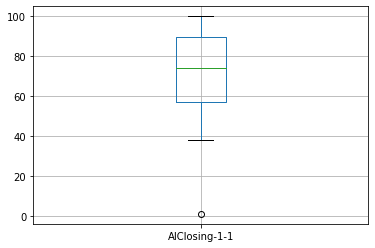

AIClosing-1-2
Q1: 61.0 and Q3: 94.75
median: 70.5
mean: 75.8
std: 16.92
min: 55.0 und max: 100.0



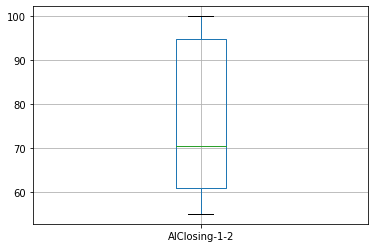

AIClosing-1-3
Q1: 40.75 and Q3: 59.25
median: 51.0
mean: 50.65
std: 19.41
min: 21.0 und max: 100.0



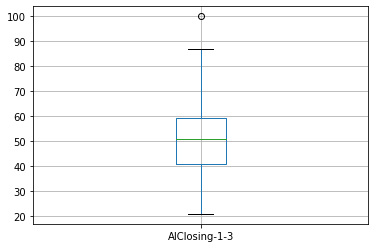

AIClosing-1-4
Q1: 45.0 and Q3: 86.5
median: 54.0
mean: 59.2
std: 25.69
min: 1.0 und max: 100.0



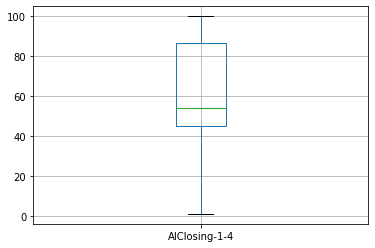

In [145]:
for taskId in ["AIClosing-1-1", "AIClosing-1-2", "AIClosing-1-3", "AIClosing-1-4"]:
    surveySliderStatistics(pupil_performance_df[taskId])
    pupil_performance_df.boxplot(column=[taskId])
    plt.show()

### 6.2 Gefühle zu KI - Freitext

In [139]:
pupil_performance_df1["AIClosing-1-5"]

pupilId
bniRycMi5bwrXjvGy    Ich glaube, dass meine Angst haben brauch, da ...
sqBXKssFvS8pFYAMv    Ich würde ihm sagen, dass eine KI niemals so k...
Kd6FuRsrq6QvPrkKp                                                  NaN
6bBwnX2mwAp2NAwNR                                                  NaN
ZTvPk2i77LDC8pFmu    Bisher wird ja KI noch nicht so stark eingeset...
rsATbrReo6odn6oXD                                                  NaN
FhFN5eiQduwiYKWEn                                                  NaN
Ay6mfswm3SFcQdNJg                                                  NaN
hn2oJ5p2CwPfG44wx                                                  NaN
dotjrftFetJme4iPH                                                  NaN
TLqNCrX4jaYixjtv7                                                  NaN
kdqG4fXAK64zdrqN8                                                  NaN
7eqvpzMXwFGaYWHou                                                  NaN
Z9DkQMmtiPiHtteME                                                  Na

Results:
* meiste sind positiv eingestellt
* ziemlich ausgewogene antworten

## 7. Feedback zum Paket
### 7.1 Feedback zum Paket - Selbsteinschätzung
* ('AIClosing-1-7', 'Hattest du Spaß?')
* ('AIClosing-1-8', 'Hast du etwas gelernt?')

AIClosing-1-6
Q1: 54.75 and Q3: 77.5
median: 65.5
mean: 66.25
std: 22.37
min: 14.0 und max: 100.0



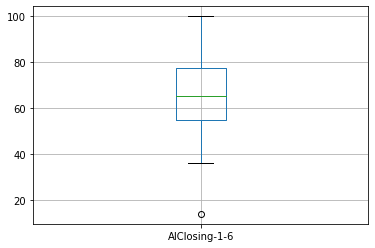

AIClosing-1-7
Q1: 63.75 and Q3: 88.25
median: 73.5
mean: 72.3
std: 23.43
min: 1.0 und max: 100.0



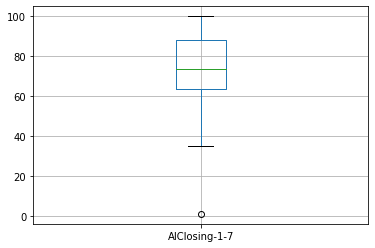

In [154]:
for taskId in ["AIClosing-1-6", "AIClosing-1-7"]:
    surveySliderStatistics(pupil_performance_df[taskId])
    pupil_performance_df.boxplot(column=[taskId])
    plt.show()

### 7.2 Feedback zum Paket - Freitext

In [160]:
for pupilId in pupil_performance_df.index:
    if (pupil_performance_df.loc[pupilId, "AIClosing-1-8"]==pupil_performance_df.loc[pupilId, "AIClosing-1-8"]):
        print(pupil_performance_df.loc[pupilId, "AIClosing-1-8"])
        print()

War alles gut.

Ich fand es gut das Videos eingebunden wurden und oft nach der Meinung gefragt wurde.  Die Tipps bei den Multiple-choice Aufgaben könnten allerdings noch auf die jeweils angeklickten Antworten angepasst werden, da man oft einen Tipp zu einer Antwort bekommen hat die man bereits ausgewählt hatte.

Die Aufgaben waren zu schwer, und ab und zu gab es fehler bei der auswertung, aber sonst war es nice.

Wenn man das Programm zum ersten mal ausführt, dann ist ein Text nicht vollständig zu lesen, weil er hinter der Garage verschwindet. Wenn man bei der Aufgabe über das Clustering mit dem Beispiel der Filme einen Fehler macht und diesen Korrigieren möchte ist nur nach die Fragestellung zu sehen. Ohne sich die richtige Antwort gemerkt zu haben ist es nur durch raten möglich diese Frage richtig zu beantworten.

Ich finde dieses system mit den GMBH mega cool so kriegt man auch nen reiz die beste GMBH von allen zu sein :)

<span style="color: rgb(51, 51, 51);">⠀</span>

Ich finde, m

##### Results:
* 1x schreibaufgaben sind langweilig
* 1x relevanz KI nicht rüber gekommen
* tipps besser passend zur aufgabe
* 2x zu schwer
* mehrfach: alles gut so, man wüsste nicht, was man ändern sollte

# Fortschritt aller SuS im Paket

In [73]:
# Wie viele haben schon alle Eval aufgaben gemacht?
len(df[df["taskId"] == "EvalML-1-9"]["pupilId"].unique())

16

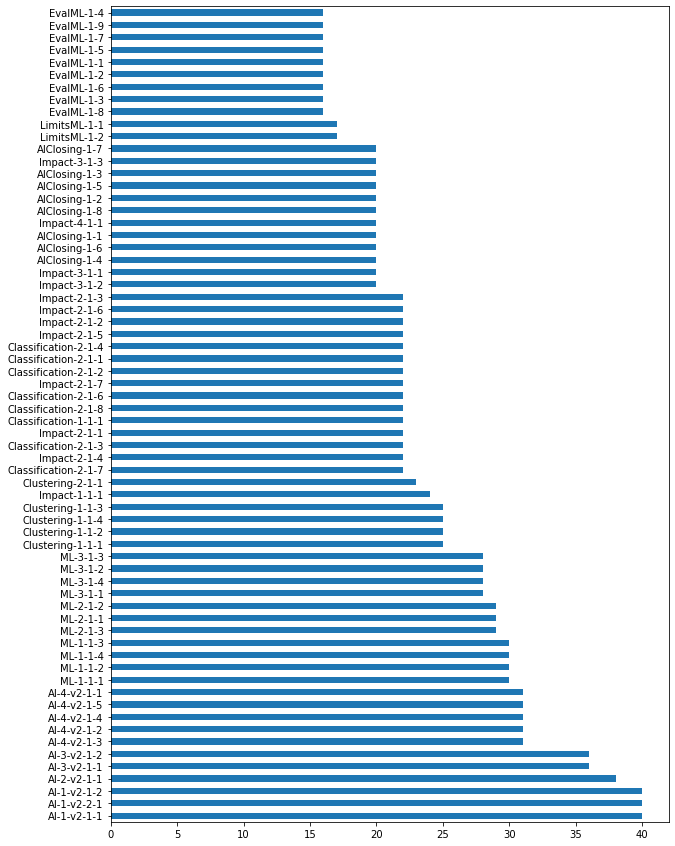

In [10]:
# Wie viele SuS haben die jeweilige Aufgabe gelöst?
df["taskId"].value_counts().plot(kind='barh', figsize=(10,15))
plt.show()

#### Wie kann Eval weniger haben als Impact? Eval ist doch dependency davon

Mögliche Erklärung: Kein Präsenzunterricht wegen Corona?
Mögliche Erklärung: Nicht alle Lehrer haben das Paket zuende gespielt


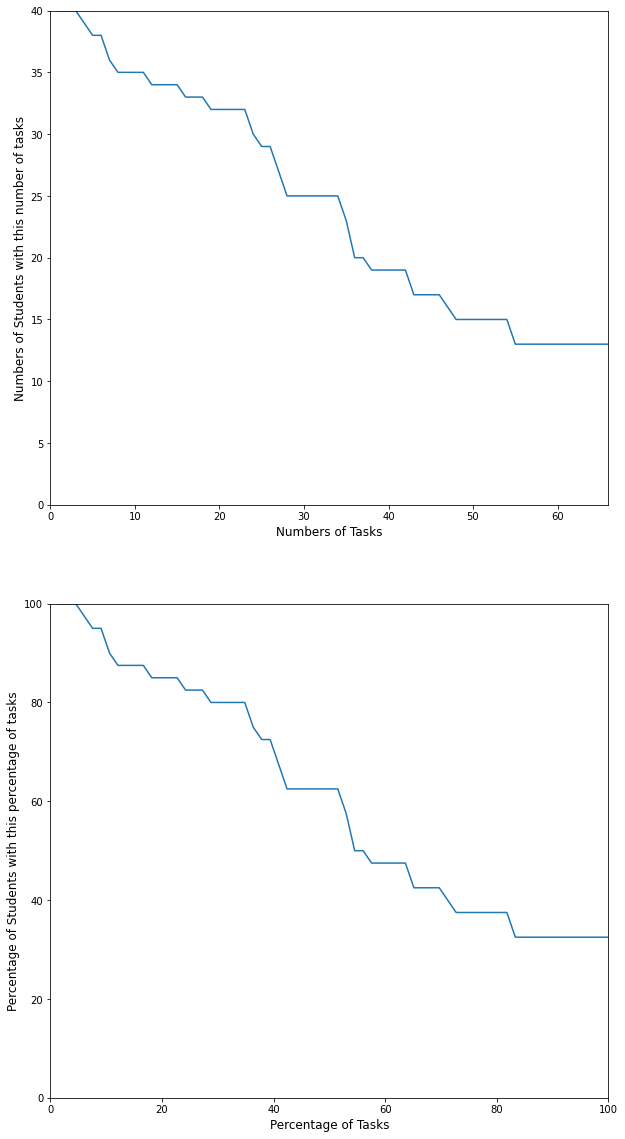

In [11]:
nr_all_tasks = len(df["taskId"].unique())

sorted_nr_tasks_per_pupil = np.sort(pupil_performance_df["nr_tasks_per_pupil"])

# Number of students with number of tasks
number_pupils_with_this_number_of_tasks = []
for i in range(nr_all_tasks):
    at_least_this_number = 0
    for number in sorted_nr_tasks_per_pupil:
        if number >= i+1:
            at_least_this_number += 1
    number_pupils_with_this_number_of_tasks.append(at_least_this_number) #anzahl zahlen mit mehr

# percentage of students with each percentage of tasks
task_percentage = [i * (100/nr_all_tasks) for i in range(1,nr_all_tasks+1)]
pupil_percentages = [i * (100/len(df["pupilId"].unique())) for i in number_pupils_with_this_number_of_tasks]


# PLOTTING
print("Mögliche Erklärung: Kein Präsenzunterricht wegen Corona?")
print("Mögliche Erklärung: Nicht alle Lehrer haben das Paket zuende gespielt")
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,20))

ax1 = plt.subplot(211)
ax1.plot(range(1,nr_all_tasks+1), number_pupils_with_this_number_of_tasks)
ax1.set_xlabel( "Numbers of Tasks" , size = 12 )
ax1.set_ylabel( "Numbers of Students with this number of tasks" , size = 12 )
ax1.set_xlim([0, nr_all_tasks])
ax1.set_ylim([0, len(sorted_nr_tasks_per_pupil)])

ax2 = plt.subplot(212)
ax2.plot(task_percentage, pupil_percentages)
ax2.set_xlabel( "Percentage of Tasks" , size = 12 )
ax2.set_ylabel( "Percentage of Students with this percentage of tasks" , size = 12 )
ax2.set_xlim([0, 100])
ax2.set_ylim([0, 100])

plt.show()

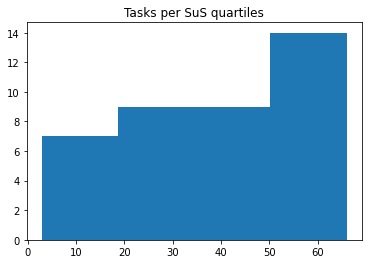

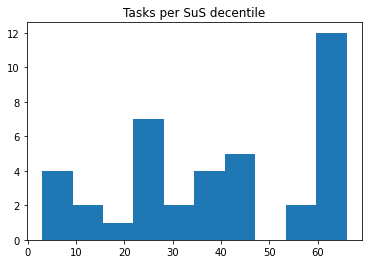

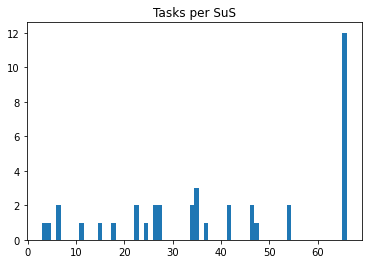

In [223]:
# anzahl tasks per pupil
plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=4)
plt.title("Tasks per SuS quartiles")
plt.show()
plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=10)
plt.title("Tasks per SuS decentile")
plt.show()
plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=np.max(pupil_performance_df["nr_tasks_per_pupil"]))
plt.title("Tasks per SuS")
plt.show()

# Itemanalyse
## Surveyslider

### Durations

<AxesSubplot:ylabel='taskId'>

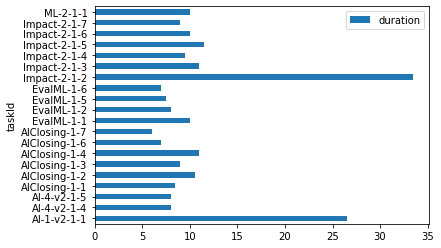

In [70]:
surveysliders.groupby("taskId").agg(np.median)[["duration"]].plot(kind="barh")

#### Besonders lange bei:
* Impact-2-1-2
* AI-1-v2-1-1

In [226]:
multipleChoice.groupby(["taskId"]).agg([np.median, np.mean, np.std])[["duration"]]

duration                        
                       median        mean         std
taskId                                               
AI-2-v2-1-1              90.0  168.684211  159.892718
AI-3-v2-1-1              62.5  121.833333  169.541482
AI-3-v2-1-2              60.0   83.722222   64.709730
AI-4-v2-1-1              64.5   78.968750   51.767149
AI-4-v2-1-2             139.0  213.500000  199.136523
Classification-1-1-1     24.0   24.954545   11.557217
Classification-2-1-6     13.5   16.363636   13.792840
Classification-2-1-7     20.5   42.818182   51.628376
Classification-2-1-8     42.0   41.045455   24.310447
Clustering-1-1-1         29.5   33.923077   18.508210
Clustering-1-1-2         61.5  184.192308  404.196390
EvalML-1-3               53.5   60.687500   40.235505
EvalML-1-4               31.5   32.687500   21.911089
EvalML-1-8               48.5   56.875000   45.691538
EvalML-1-9               22.0   23.625000   15.713582
Impact-1-1-1             64.0   86.625000   79.421721
Impact-3-1-2             34.0   37.190476   18.693900
Impact-4-1-1             57.0   67.428571   36.668203
LimitsML-1-1             38.0   47.647059   39.938924
ML-2-1-3                132.0  140.800000   94.622080
ML-3-1-1                131.0  182.827586  153.436369
ML-3-1-2                 29.0   30.793103   21.443246
ML-3-1-3                 16.0   24.724138   25.965494
ML-3-1-4                 11.0   12.310345    9.464609

In [227]:
p99slider, p95slider, p90slider, p75slider, p25slider = np.percentile(multipleChoice["duration"], [99, 95, 90, 75 ,25])
print(p99slider, p95slider, p90slider, p75slider, p25slider)

601.1599999999992 306.49999999999966 200.39999999999998 89.5 20.5


<AxesSubplot:>

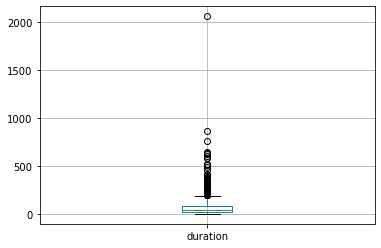

In [228]:
multipleChoice.boxplot(column=['duration'])

In [229]:
multipleChoice[multipleChoice["duration"] > p95slider][["taskId"]].value_counts()

taskId          
AI-4-v2-1-2         8
AI-2-v2-1-1         8
ML-3-1-1            7
ML-2-1-3            3
Clustering-1-1-2    2
AI-3-v2-1-1         2
Impact-1-1-1        1
dtype: int64

In [230]:
multipleChoice[multipleChoice["duration"] > p95slider][["pupilId"]].value_counts()

pupilId          
XKrLvRHLaM7yDisR6    3
kdqG4fXAK64zdrqN8    3
R8CkqGDeQXZmHxTuk    3
6bBwnX2mwAp2NAwNR    2
FhFN5eiQduwiYKWEn    2
j3AkifkKRR3t3NeoT    2
dotjrftFetJme4iPH    2
7eqvpzMXwFGaYWHou    2
TLqNCrX4jaYixjtv7    2
MRSj5LqwWj6WSoj4E    2
C2BW6tdii778v4RfL    2
Ay6mfswm3SFcQdNJg    1
rsATbrReo6odn6oXD    1
Kd6FuRsrq6QvPrkKp    1
TWes7DiBwCuCzS2px    1
Z9DkQMmtiPiHtteME    1
T4iugPHxim5gX8M4i    1
dtype: int64

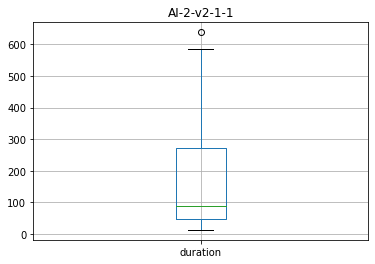

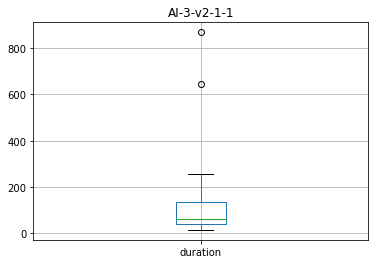

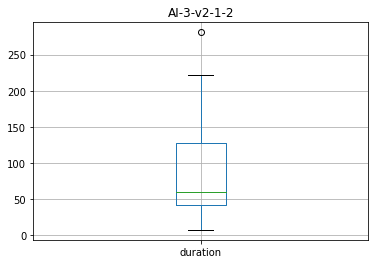

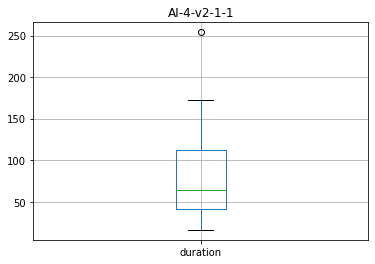

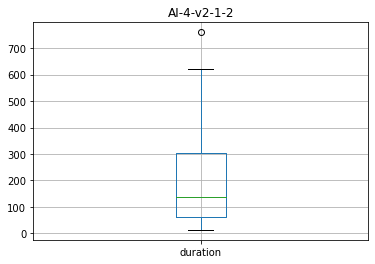

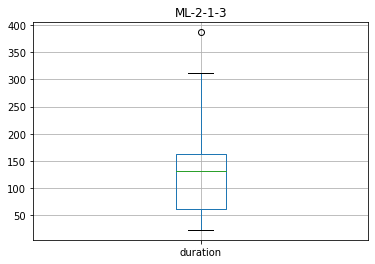

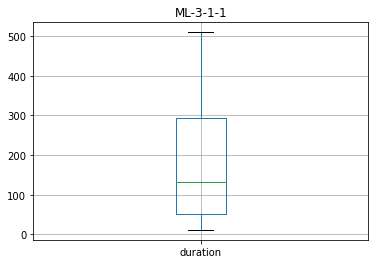

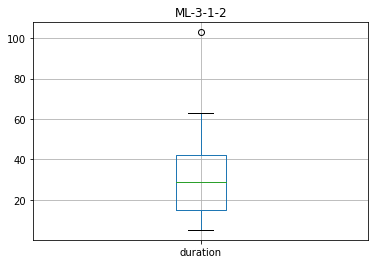

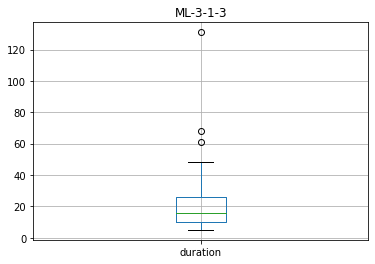

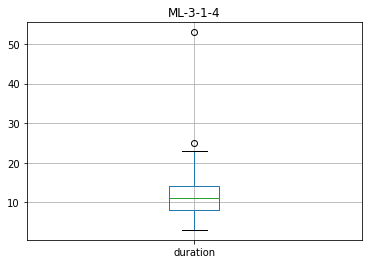

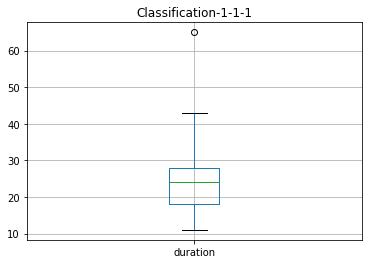

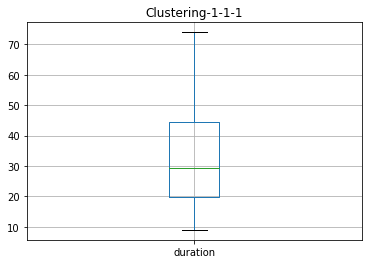

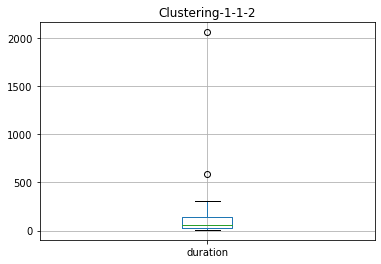

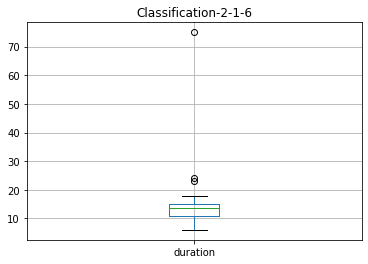

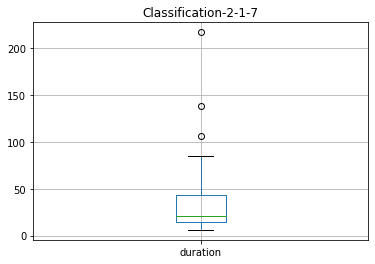

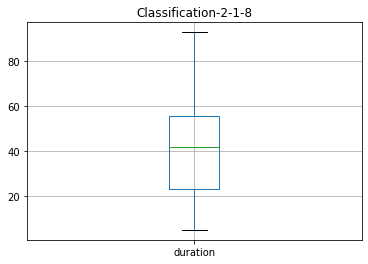

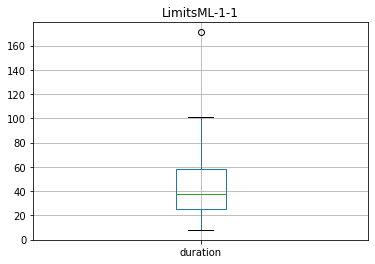

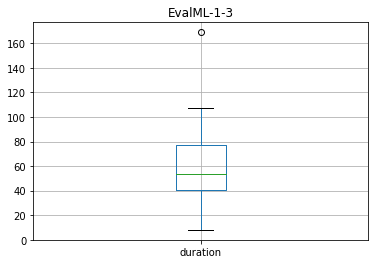

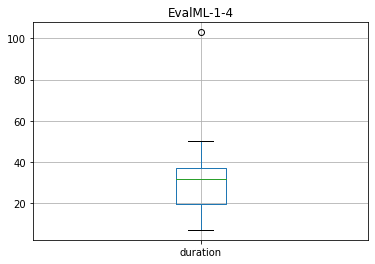

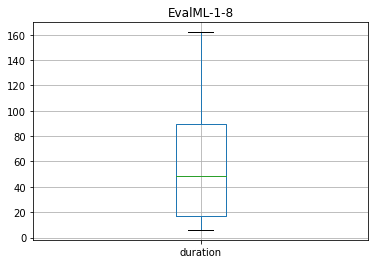

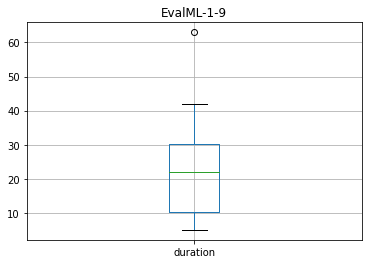

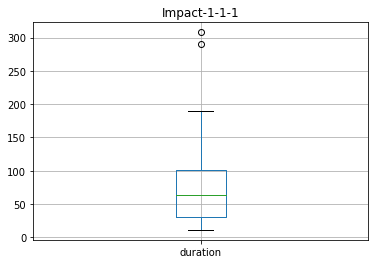

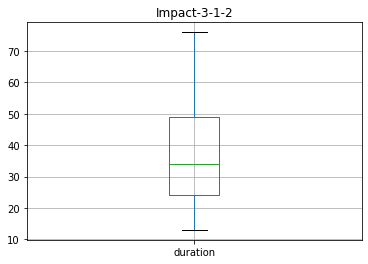

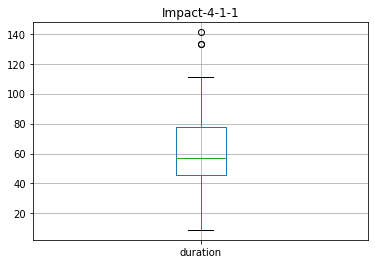

In [231]:
for taskid in multipleChoice["taskId"].unique():
    task_i = multipleChoice[multipleChoice["taskId"] == taskid]
    task_i.boxplot(column=['duration'])
    plt.title(str(taskid))
    plt.show()

TASK   AI-1-v2-1-1: Wie gut weißt du schon, was KI ist?
Von Gar nicht bis Sehr gut
min: 5
max: 100
median: 71.5
mean: 69.0
std: 20.971409108593537


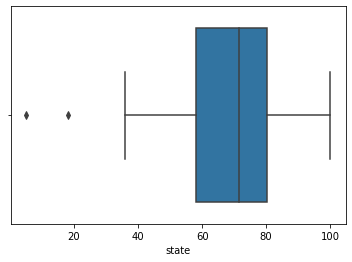

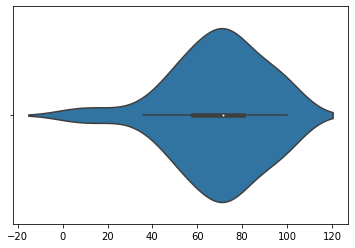

Ausreißer:
                pupilId       taskId state  \
888   vNMvj2EsvKXvqk3Qw  AI-1-v2-1-1     5   
1533  gDspq39jnffCNv8E2  AI-1-v2-1-1    18   

                                 question  
888   Wie gut weißt du schon, was KI ist?  
1533  Wie gut weißt du schon, was KI ist?  

Durations:


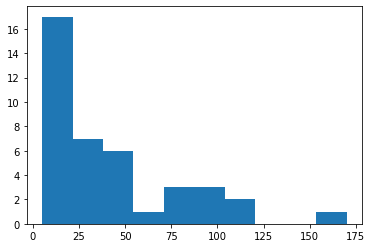

median duration: 26.5
mean duration: 42.225
-------------------------------------------------------------


TASK   AI-4-v2-1-4: Wie gut hast du jetzt verstanden, was KI ist?
Von Gar nicht bis Sehr gut
min: 40
max: 100
median: 86.0
mean: 79.06451612903226
std: 18.819919926933572


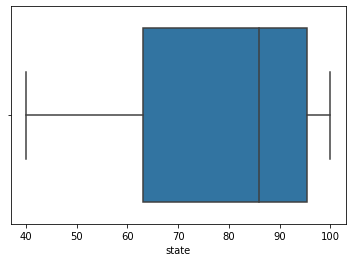

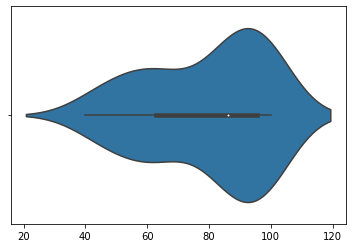

Ausreißer:
                pupilId       taskId state  \
1206  JTE3T8c3SN6ehbrDQ  AI-4-v2-1-4    40   

                                           question  
1206  Wie gut hast du jetzt verstanden, was KI ist?  

Durations:


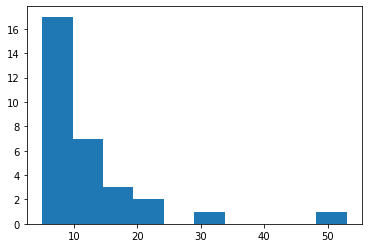

median duration: 8.0
mean duration: 12.580645161290322
-------------------------------------------------------------


TASK   AI-4-v2-1-5: Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?
Von Gar nicht bis Sehr gut
min: 33
max: 100
median: 88.0
mean: 78.96774193548387
std: 22.712059992318906


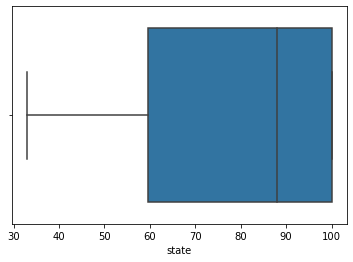

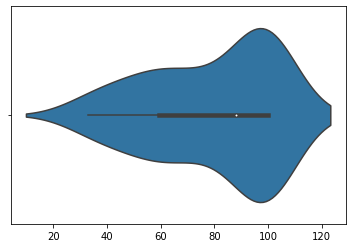

Ausreißer:
               pupilId       taskId state  \
904  Absyuhryq96KZL2Cs  AI-4-v2-1-5    33   

                                              question  
904  Wie gut hast du den Unterschied zwischen spezi...  

Durations:


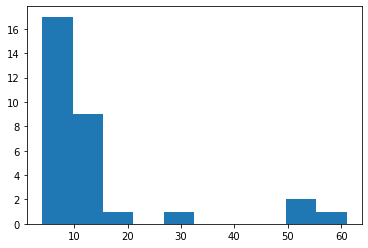

median duration: 8.0
mean duration: 13.935483870967742
-------------------------------------------------------------


TASK   ML-2-1-1: Wie gut weißt du schon, was Maschinelles Lernen ist?
Von Gar nicht bis Sehr gut
min: 47
max: 100
median: 66.0
mean: 69.51724137931035
std: 17.31377902464248


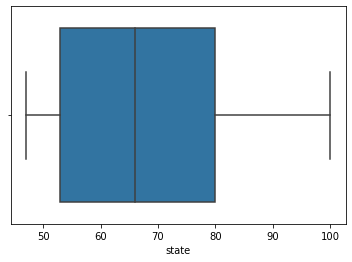

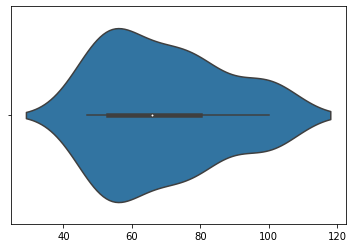

Ausreißer:
Empty DataFrame
Columns: [pupilId, taskId, state, question]
Index: []

Durations:


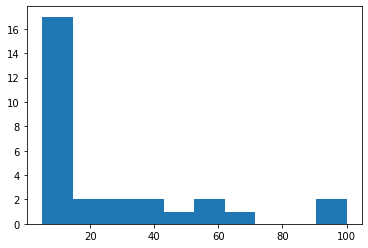

median duration: 10.0
mean duration: 25.24137931034483
-------------------------------------------------------------


TASK   EvalML-1-1: Wie gut hast du verstanden, was KI ist? Sei dabei so ehrlich es geht damit wir diese Inhalte noch verbessern können.
Von Gar nicht bis Sehr gut
min: 31
max: 100
median: 77.5
mean: 72.3125
std: 23.376587512936954


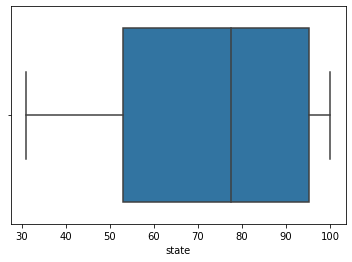

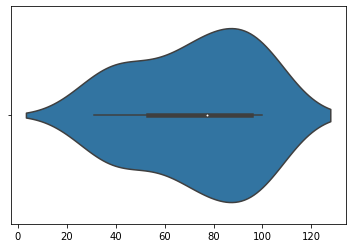

Ausreißer:
Empty DataFrame
Columns: [pupilId, taskId, state, question]
Index: []

Durations:


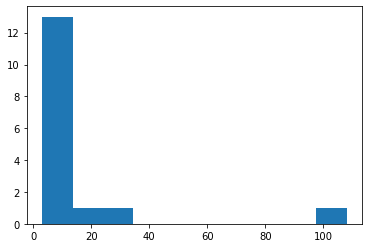

median duration: 10.0
mean duration: 16.9375
-------------------------------------------------------------


TASK   EvalML-1-2: Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 87.0
mean: 74.0625
std: 30.27678308126542


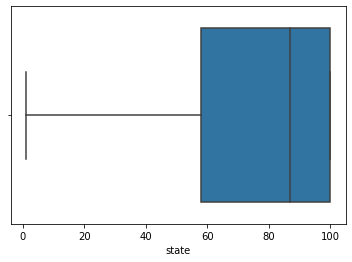

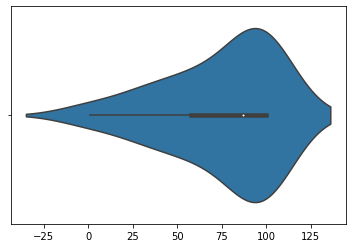

Ausreißer:
                pupilId      taskId state  \
1146  5GPMWTgF29JDyeXoG  EvalML-1-2     1   

                                               question  
1146  Wie gut hast du den Unterschied zwischen spezi...  

Durations:


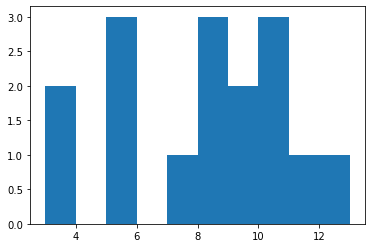

median duration: 8.0
mean duration: 7.75
-------------------------------------------------------------


TASK   EvalML-1-5: Wie gut hast du verstanden, was maschinelles Lernen ist? Sei dabei so ehrlich es geht, damit wir diese Inhalte noch verbessern können.
Von Gar nicht bis Sehr gut
min: 24
max: 100
median: 71.5
mean: 68.625
std: 21.8428334929331


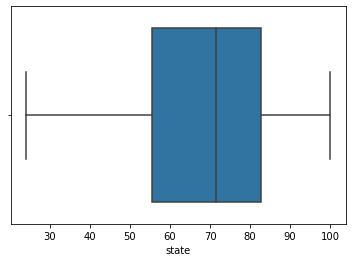

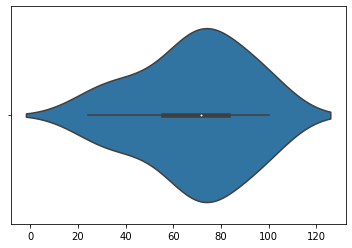

Ausreißer:
                pupilId      taskId state  \
1574  gDspq39jnffCNv8E2  EvalML-1-5    24   

                                               question  
1574  Wie gut hast du verstanden, was maschinelles L...  

Durations:


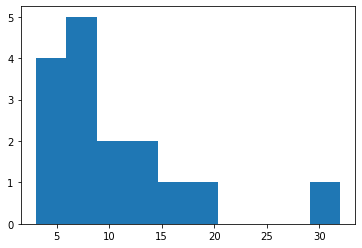

median duration: 7.5
mean duration: 9.875
-------------------------------------------------------------


TASK   EvalML-1-6: Wie sehr hast du das Gefühl, verstanden zu haben, was der Unterschied zwischen überwachtem und unüberwachtem Lernen ist?
Von Gar nicht bis Sehr gut
min: 37
max: 100
median: 73.5
mean: 74.5
std: 20.503048553812675


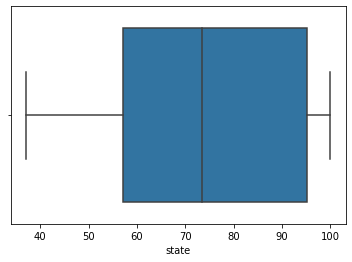

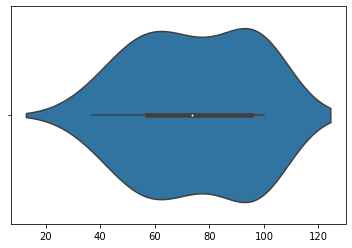

Ausreißer:
Empty DataFrame
Columns: [pupilId, taskId, state, question]
Index: []

Durations:


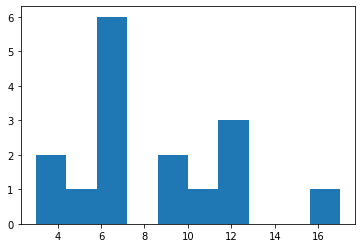

median duration: 7.0
mean duration: 8.375
-------------------------------------------------------------


TASK   Impact-2-1-2: Ich würde gerne in einem Land leben, dass den Alltag aller Bürger mit KI überwacht.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 16.5
mean: 21.181818181818183
std: 23.070320097941586


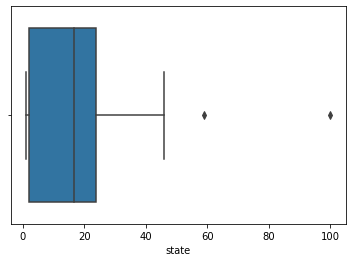

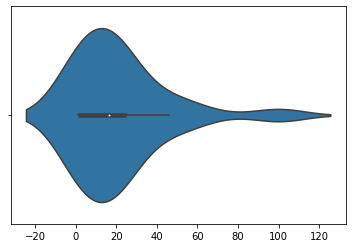

Ausreißer:
                pupilId        taskId state  \
1156  5GPMWTgF29JDyeXoG  Impact-2-1-2   100   

                                               question  
1156  Ich würde gerne in einem Land leben, dass den ...  

Durations:


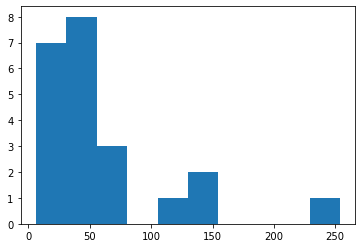

median duration: 33.5
mean duration: 57.72727272727273
-------------------------------------------------------------


TASK   Impact-2-1-3: Die Überwachung des Alltags aller Bürger sehe ich sehr kritisch.
Von Stimme nicht zu bis Stimme stark zu
min: 15
max: 100
median: 80.5
mean: 78.13636363636364
std: 21.959250389891512


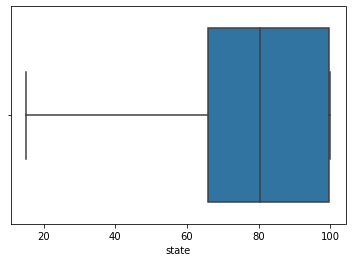

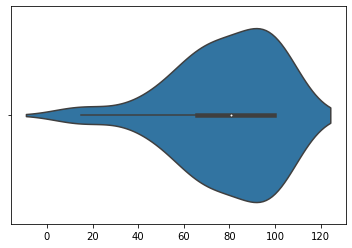

Ausreißer:
                pupilId        taskId state  \
1582  gDspq39jnffCNv8E2  Impact-2-1-3    15   

                                               question  
1582  Die Überwachung des Alltags aller Bürger sehe ...  

Durations:


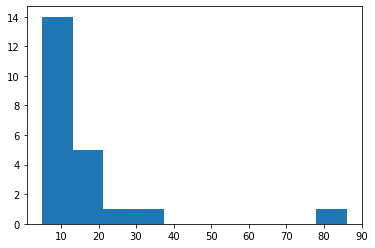

median duration: 11.0
mean duration: 16.40909090909091
-------------------------------------------------------------


TASK   Impact-2-1-4: Mich würde es stören, mittels KI-Technologien überwacht zu werden.
Von Stimme nicht zu bis Stimme stark zu
min: 15
max: 100
median: 83.0
mean: 77.72727272727273
std: 24.196509549523157


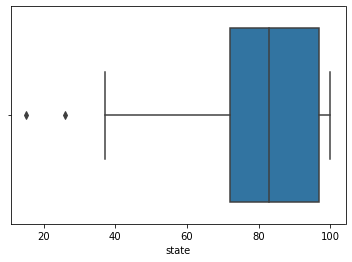

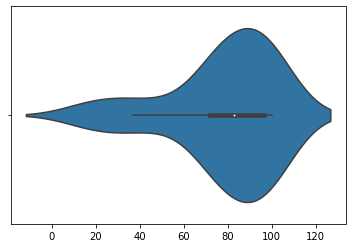

Ausreißer:
                pupilId        taskId state  \
740   3hiSwDCiw9HeyHg7f  Impact-2-1-4    15   
1583  gDspq39jnffCNv8E2  Impact-2-1-4    26   

                                               question  
740   Mich würde es stören, mittels KI-Technologien ...  
1583  Mich würde es stören, mittels KI-Technologien ...  

Durations:


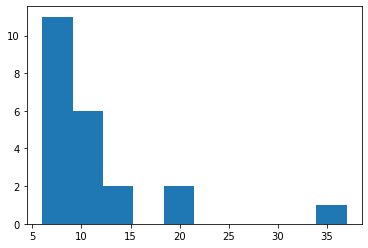

median duration: 9.5
mean duration: 11.5
-------------------------------------------------------------


TASK   Impact-2-1-5: Die Überwachung durch die Regierung bietet viele Vorteile für die Gesellschaft.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 85
median: 39.5
mean: 38.13636363636363
std: 26.55747704087983


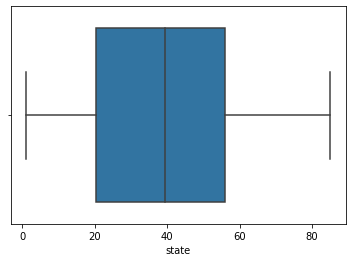

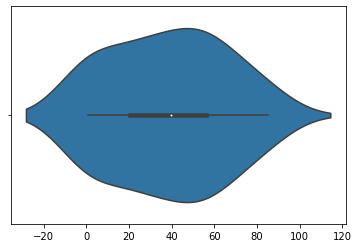

Ausreißer:
Empty DataFrame
Columns: [pupilId, taskId, state, question]
Index: []

Durations:


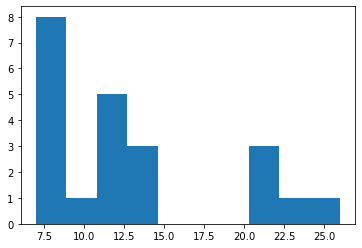

median duration: 11.5
mean duration: 12.772727272727273
-------------------------------------------------------------


TASK   Impact-2-1-6: Ich würde nicht in einem Land leben wollen, dass meinen Alltag überwacht.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 84.0
mean: 75.95454545454545
std: 27.715235837363196


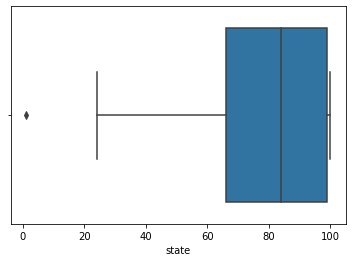

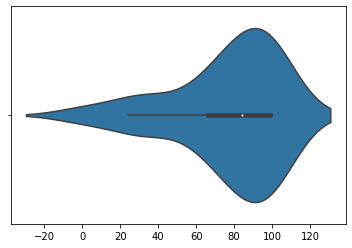

Ausreißer:
                pupilId        taskId state  \
1028  T4iugPHxim5gX8M4i  Impact-2-1-6     1   

                                               question  
1028  Ich würde nicht in einem Land leben wollen, da...  

Durations:


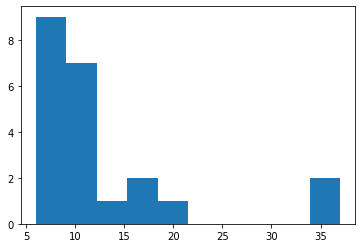

median duration: 10.0
mean duration: 12.772727272727273
-------------------------------------------------------------


TASK   Impact-2-1-7: In einem Land mit Überwachung würde ich mich sehr sicher fühlen.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 83
median: 41.5
mean: 39.81818181818182
std: 26.2481797873445


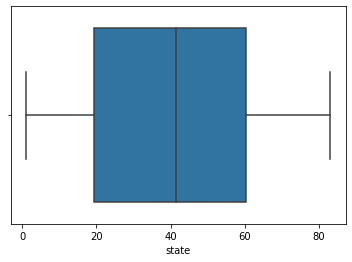

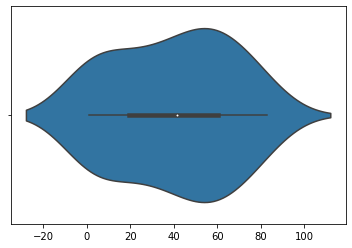

Ausreißer:
Empty DataFrame
Columns: [pupilId, taskId, state, question]
Index: []

Durations:


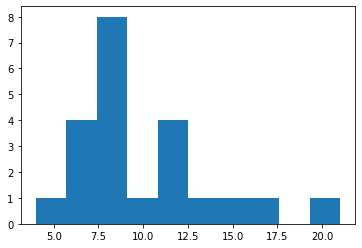

median duration: 9.0
mean duration: 9.863636363636363
-------------------------------------------------------------


TASK   AIClosing-1-1: KI wird das Leben der Menschen verbessern.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 73.5
mean: 67.6
std: 28.770470972856874


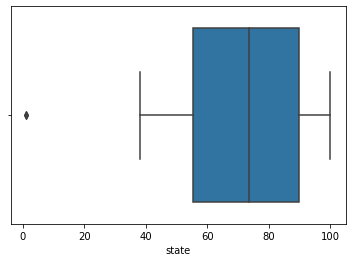

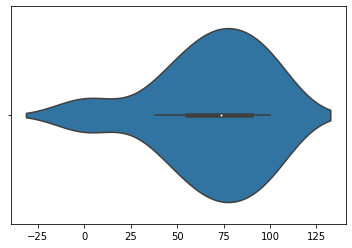

Ausreißer:
                pupilId         taskId state  \
1100  iHYe2TGnR9zgGZ6zh  AIClosing-1-1     1   
1166  5GPMWTgF29JDyeXoG  AIClosing-1-1     1   

                                        question  
1100  KI wird das Leben der Menschen verbessern.  
1166  KI wird das Leben der Menschen verbessern.  

Durations:


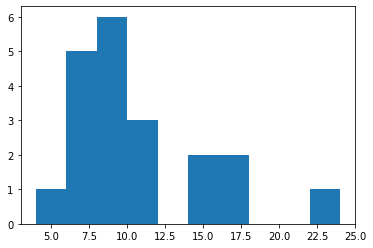

median duration: 8.5
mean duration: 10.25
-------------------------------------------------------------


TASK   AIClosing-1-2: Bei der Entwicklung von KI gibt es Risiken, die bedacht werden müssen
Von Stimme nicht zu bis Stimme stark zu
min: 55
max: 100
median: 70.5
mean: 75.8
std: 16.49424141935603


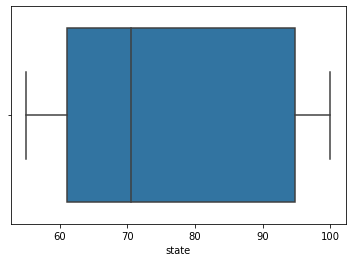

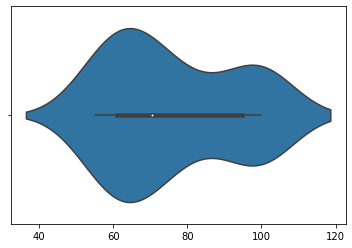

Ausreißer:
Empty DataFrame
Columns: [pupilId, taskId, state, question]
Index: []

Durations:


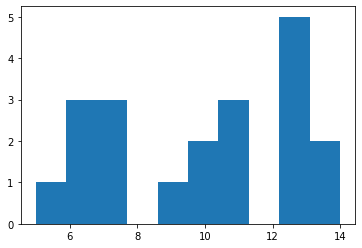

median duration: 10.5
mean duration: 9.95
-------------------------------------------------------------


TASK   AIClosing-1-3: KI birgt eine Gefahr für die Menschheit.
Von Stimme nicht zu bis Stimme stark zu
min: 21
max: 100
median: 53.5
mean: 53.45
std: 21.666737179372443


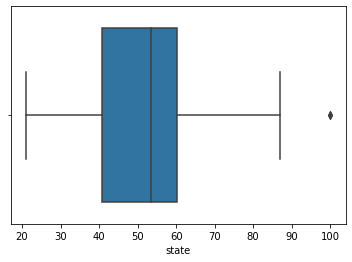

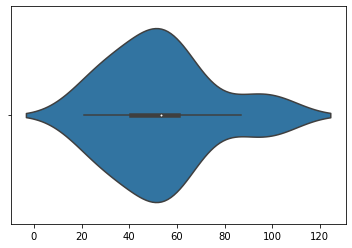

Ausreißer:
                pupilId         taskId state  \
1102  iHYe2TGnR9zgGZ6zh  AIClosing-1-3   100   
1168  5GPMWTgF29JDyeXoG  AIClosing-1-3   100   

                                      question  
1102  KI birgt eine Gefahr für die Menschheit.  
1168  KI birgt eine Gefahr für die Menschheit.  

Durations:


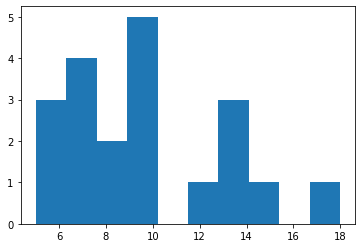

median duration: 9.0
mean duration: 9.65
-------------------------------------------------------------


TASK   AIClosing-1-4: Die Vorteile durch die Entwicklung von KI überwiegen die Risiken.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 54.0
mean: 56.75
std: 28.03368509489967


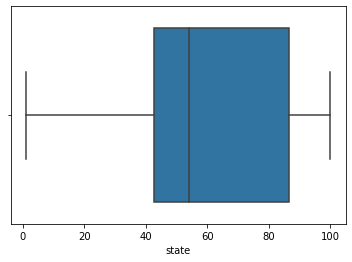

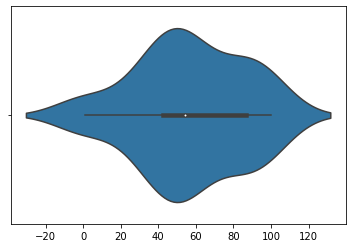

Ausreißer:
Empty DataFrame
Columns: [pupilId, taskId, state, question]
Index: []

Durations:


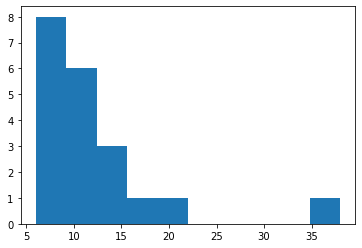

median duration: 11.0
mean duration: 12.25
-------------------------------------------------------------


TASK   AIClosing-1-6: Hattest du Spaß?
Von Sehr wenig bis Sehr viel
min: 36
max: 100
median: 69.5
mean: 70.55
std: 19.42543435807807


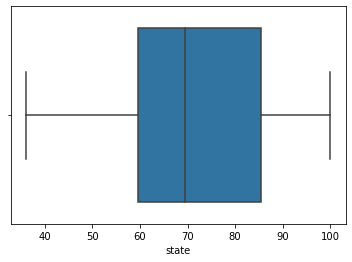

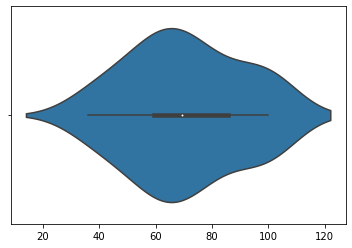

Ausreißer:
Empty DataFrame
Columns: [pupilId, taskId, state, question]
Index: []

Durations:


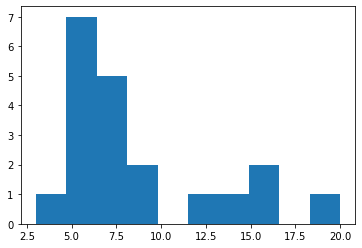

median duration: 7.0
mean duration: 8.6
-------------------------------------------------------------


TASK   AIClosing-1-7: Hast du etwas gelernt?
Von Sehr wenig bis Sehr viel
min: 1
max: 100
median: 74.5
mean: 75.55
std: 21.907704124348587


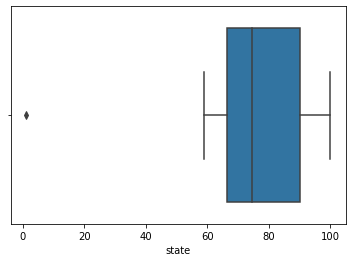

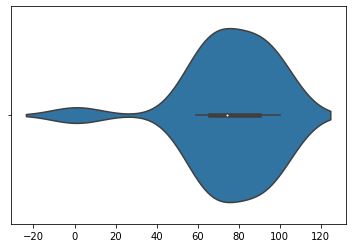

Ausreißer:
                pupilId         taskId state                question
1106  iHYe2TGnR9zgGZ6zh  AIClosing-1-7     1  Hast du etwas gelernt?

Durations:


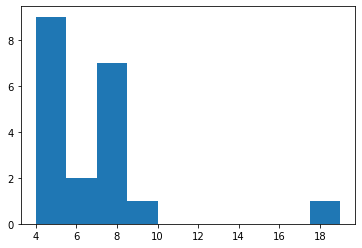

median duration: 6.0
mean duration: 6.8
-------------------------------------------------------------




In [92]:
outlier_tresh = 2

for i in surveysliders["taskId"].unique():
    slider_i = surveysliders[surveysliders["taskId"] == i]
    state_array = [int(entry) for entry in slider_i["state"]]
    duration_array = [int(entry) for entry in slider_i["duration"]]
    print("TASK   " + surveysliders[surveysliders["taskId"] == i]["taskId"].unique()[0] + ": " + surveysliders[surveysliders["taskId"] == i]["question"].unique()[0])
    print("Von " + str(surveysliders[surveysliders["taskId"] == i]["minLabel"].unique()[0]) + " bis " + str(surveysliders[surveysliders["taskId"] == i]["maxLabel"].unique()[0]))
    print("min: " + str(np.min(state_array)))
    print("max: " + str(np.max(state_array)))
    print("median: " + str(np.median(state_array)))
    print("mean: " + str(np.mean(state_array)))
    print("std: " + str(np.std(state_array)))
    ax = sns.boxplot(x=surveysliders[surveysliders["taskId"] == i]["state"])
    plt.show()
    ax1 = sns.violinplot(x=state_array)
    plt.show()
    print("Ausreißer:")
    print(surveysliders[(surveysliders["taskId"]==i) & ((surveysliders["state"]<=np.mean(state_array)-outlier_tresh*np.std(state_array)) | (surveysliders["state"]>=np.mean(state_array)+outlier_tresh*np.std(state_array)))][["pupilId", "taskId", "state", "question"]])
    print("")
    print("Durations:")
    plt.hist(duration_array)
    plt.show()
    print("median duration: " + str(np.median(duration_array)))
    print("mean duration: " + str(np.mean(duration_array)))
    print("-------------------------------------------------------------")
    print("")
    print("")


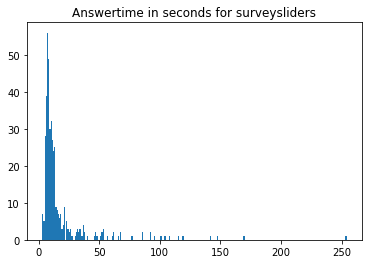

In [50]:
# Antwortzeiten Surveysliders
plt.hist(surveysliders["duration"], bins=np.max(surveysliders["duration"]))
plt.title("Answertime in seconds for surveysliders")
plt.show()



## Inputfields

### Durations

<AxesSubplot:ylabel='taskId'>

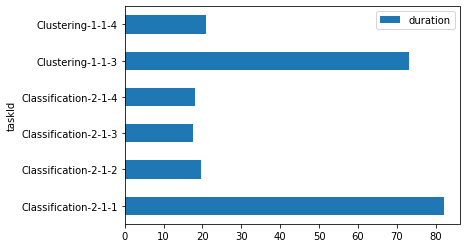

In [72]:
inputfields.groupby("taskId").agg(np.median)[["duration"]].plot(kind="barh")

#### Besonders lange bei:
* Clustering-1-1-3
* Classification-2-1-1

In [85]:
inputfields.groupby(["taskId"]).agg([np.median, np.mean, np.std])[["duration"]]

duration                        
                       median        mean         std
taskId                                               
Classification-2-1-1     82.0  121.136364  169.107826
Classification-2-1-2     19.5   19.727273    7.330184
Classification-2-1-3     17.5   18.090909    7.144156
Classification-2-1-4     18.0   16.454545    5.271010
Clustering-1-1-3         73.0   85.520000   66.911708
Clustering-1-1-4         21.0   27.160000   16.687520

#### Besonders lang:
* Classification-2-1-1
* Clustering-1-1-3

In [86]:
p99if, p95if, p90if, p75if, p25if = np.percentile(inputfields["duration"], [99, 95, 90, 75 ,25])
print(p99if, p95if, p90if, p75if, p25if)

259.75999999999976 143.20000000000005 115.79999999999998 47.0 14.25


<AxesSubplot:>

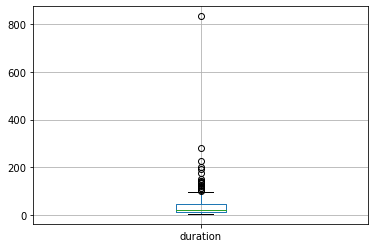

In [87]:
inputfields.boxplot(column=['duration'])

In [88]:
inputfields[inputfields["duration"] > p95if][["taskId"]].value_counts()

taskId              
Classification-2-1-1    4
Clustering-1-1-3        3
dtype: int64

In [89]:
inputfields[inputfields["duration"] > p95if][["pupilId"]].value_counts()

pupilId          
FhFN5eiQduwiYKWEn    2
kdqG4fXAK64zdrqN8    1
j3AkifkKRR3t3NeoT    1
dotjrftFetJme4iPH    1
ZTvPk2i77LDC8pFmu    1
TLqNCrX4jaYixjtv7    1
dtype: int64

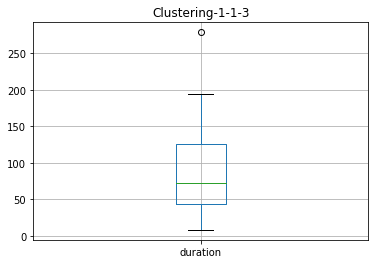

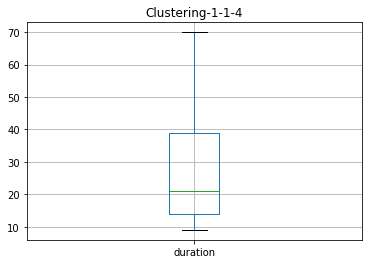

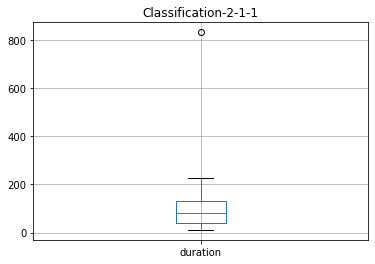

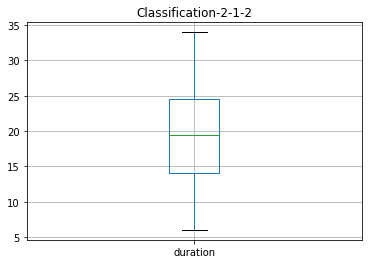

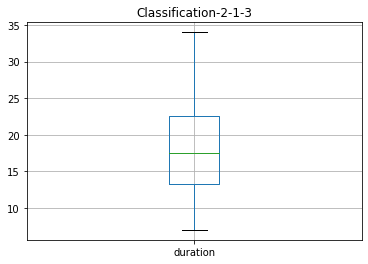

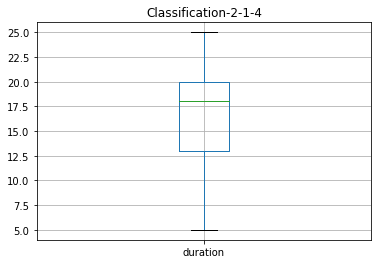

In [90]:
for taskid in inputfields["taskId"].unique():
    task_i = inputfields[inputfields["taskId"] == taskid]
    task_i.boxplot(column=['duration'])
    plt.title(str(taskid))
    plt.show()

### Antworten

Clustering-1-1-3Wie viele Youtuber sind sowohl sehr aktiv als auch beliebt?
amount of errors: 25
average number of errors: 1.0
average number of errors: 1.0
average number of errors: 1.0583005244258363
percentage errors: 56


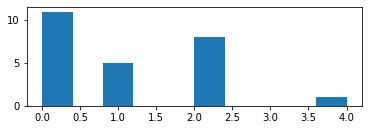

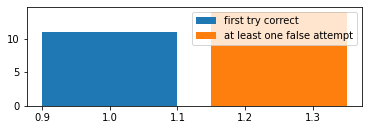

average duration right: 80.91 with std 49.69
average duration false: 89.14 with std 75.53
median duration right: 78.0
median duration false: 67.0
-----------------------------------------------


Clustering-1-1-4Wie viele Youtuber sind aktiv, haben aber nicht so viele Views?
amount of errors: 20
average number of errors: 0.8
average number of errors: 0.0
average number of errors: 1.131370849898476
percentage errors: 36


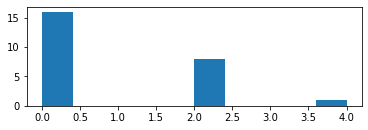

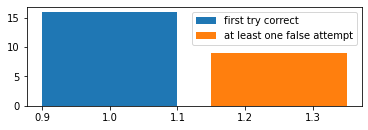

average duration right: 23.12 with std 14.58
average duration false: 34.33 with std 16.86
median duration right: 15.0
median duration false: 35.0
-----------------------------------------------


Classification-2-1-1Wie viele Filme stimmen zwischen Josi und Alex überein? Gib die Zahl in dieses Feld ein.
amount of errors: 6
average number of errors: 0.2727272727272727
average number of errors: 0.0
average number of errors: 0.5378254348272378
percentage errors: 22


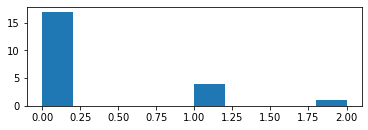

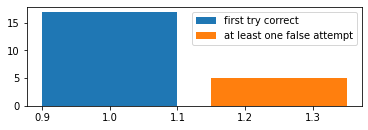

average duration right: 147.24 with std 179.55
average duration false: 32.4 with std 17.48
median duration right: 105.0
median duration false: 33.0
-----------------------------------------------


Classification-2-1-2Wie viele Filme stimmen zwischen Paul und Alex überein?
amount of errors: 4
average number of errors: 0.18181818181818182
average number of errors: 0.0
average number of errors: 0.38569460791993493
percentage errors: 18


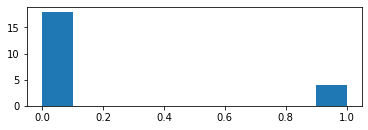

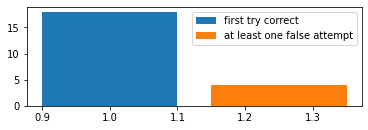

average duration right: 19.83 with std 6.57
average duration false: 19.25 with std 9.36
median duration right: 19.5
median duration false: 17.0
-----------------------------------------------


Classification-2-1-3Wie viele Filme stimmen zwischen Mahmud und Alex überein?
amount of errors: 6
average number of errors: 0.2727272727272727
average number of errors: 0.0
average number of errors: 0.5378254348272378
percentage errors: 22


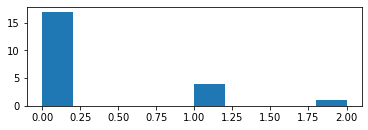

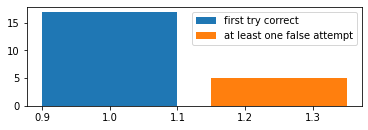

average duration right: 18.71 with std 5.72
average duration false: 16.0 with std 9.88
median duration right: 18.0
median duration false: 10.0
-----------------------------------------------


Classification-2-1-4Wie viele Filme stimmen zwischen Anna und Alex überein?
amount of errors: 2
average number of errors: 0.09090909090909091
average number of errors: 0.0
average number of errors: 0.28747978728803447
percentage errors: 9


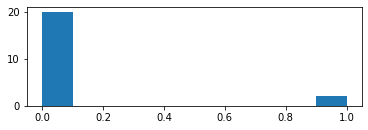

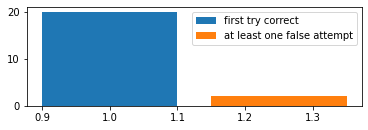

average duration right: 16.85 with std 4.82
average duration false: 12.5 with std 6.5
median duration right: 18.0
median duration false: 12.5
-----------------------------------------------




In [48]:
for taskId in inputfields["taskId"].unique():
    print(str(taskId) + str(inputfields[inputfields["taskId"] == taskId]["question"].unique()[0]))
    taskId_i = inputfields[inputfields["taskId"] == taskId]
    false_attempts = taskId_i["falseAttempts"]
    error_array = []
    abs_number_errors = 0
    number_errors = []
    for entry in false_attempts:
        if type(entry) != np.float:
            abs_number_errors += len(entry)
            number_errors.append(len(entry))
            error_array.append(entry)
        else:
            number_errors.append(0)
    print("amount of errors: " + str(abs_number_errors))
    print("average number of errors: " + str(np.mean(number_errors)))
    print("average number of errors: " + str(np.median(number_errors)))
    print("average number of errors: " + str(np.std(number_errors)))
    print("percentage errors: " + str(int((100/len(false_attempts))*len(error_array))))
    plt.subplot(211)
    plt.hist(number_errors)
    plt.show()
    plt.subplot(212)
    ax2 = plt.bar(1, len(list(filter(lambda number: number == 0, number_errors))), 0.2)
    ax3 = plt.bar(1.25, len(list(filter(lambda number: number > 0, number_errors))), 0.2)
    plt.legend((ax2, ax3), ("first try correct", "at least one false attempt"))
    plt.show()
    duration_false_attempts = []
    duration_correct_attempts = []
    for i, entry in taskId_i.iterrows():
        if type(entry["falseAttempts"]) != np.float:
            duration_false_attempts.append(entry["duration"])
        else:
            duration_correct_attempts.append(entry["duration"])
    print("average duration right: " + str(round(np.mean(duration_correct_attempts), 2)) + " with std " + str(round(np.std(duration_correct_attempts), 2)))
    print("average duration false: " + str(round(np.mean(duration_false_attempts), 2))+ " with std " + str(round(np.std(duration_false_attempts), 2)))
    print("median duration right: " + str(np.median(duration_correct_attempts)))
    print("median duration false: " + str(np.median(duration_false_attempts)))
    print("-----------------------------------------------")
    print("\n")
    

In [260]:
if_false_attempt_df = inputfields.dropna(subset=['falseAttempts'])
if_right_attempts = inputfields[np.where(inputfields["falseAttempts"]!=inputfields["falseAttempts"], True, False)]
if_false_attempt_df.head()

,pupilId,classId,taskId,taskSeriesId,duration,state,evaluation,falseAttempts,hintsTaken,subType,question,hints,sampleSolution,numberFalseAttempts
25,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,Clustering-1-1-3,Clustering-1,113,8,correct,[9],1,inputField,Wie viele Youtuber sind sowohl sehr aktiv als ...,In welchem Cluster sind die beliebtesten und a...,8,1.0
91,sqBXKssFvS8pFYAMv,qFEyvypMn4sAwLwtc,Clustering-1-1-3,Clustering-1,61,8,correct,"[3, 3]",1,inputField,Wie viele Youtuber sind sowohl sehr aktiv als ...,In welchem Cluster sind die beliebtesten und a...,8,2.0
298,FhFN5eiQduwiYKWEn,qFEyvypMn4sAwLwtc,Clustering-1-1-3,Clustering-1,176,8,correct,[9],1,inputField,Wie viele Youtuber sind sowohl sehr aktiv als ...,In welchem Cluster sind die beliebtesten und a...,8,1.0
299,FhFN5eiQduwiYKWEn,qFEyvypMn4sAwLwtc,Clustering-1-1-4,Clustering-1,70,7,false,"[9, 8]",1,inputField,"Wie viele Youtuber sind aktiv, haben aber nich...","Welche Gruppe hat viele Uploads, aber nicht so...",7,2.0
398,hn2oJ5p2CwPfG44wx,qFEyvypMn4sAwLwtc,Clustering-1-1-3,Clustering-1,142,8,correct,[3],1,inputField,Wie viele Youtuber sind sowohl sehr aktiv als ...,In welchem Cluster sind die beliebtesten und a...,8,1.0


<AxesSubplot:>

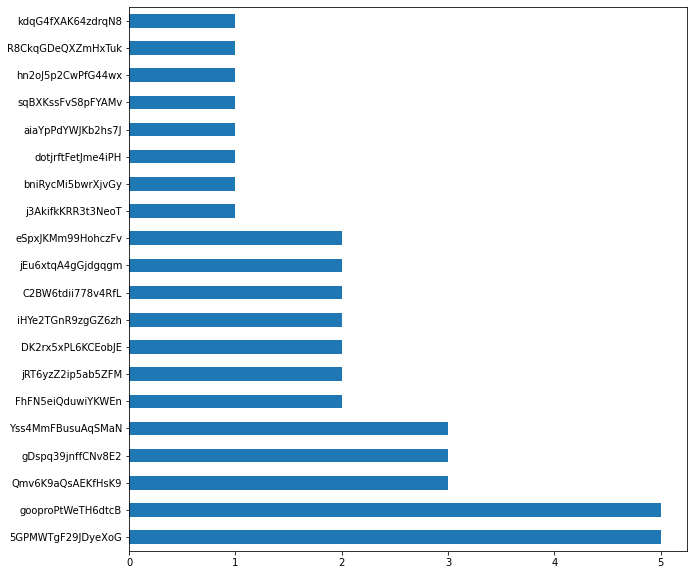

In [261]:
#different students made sth wrong
if_false_attempt_df["pupilId"].value_counts().plot(kind='barh', figsize=(10,10))

In [262]:
print("revisions: " + str(len(if_false_attempt_df[if_false_attempt_df["evaluation"] == "false"])))
print("false attempt, aber noch richtig gemacht: " + str(len(if_false_attempt_df[if_false_attempt_df["evaluation"] == "correct"])))

revisions: 32
false attempt, aber noch richtig gemacht: 9


In [263]:
if_false_attempt_df[if_false_attempt_df["evaluation"] == "false"]

,pupilId,classId,taskId,taskSeriesId,duration,state,evaluation,falseAttempts,hintsTaken,subType,question,hints,sampleSolution,numberFalseAttempts
299,FhFN5eiQduwiYKWEn,qFEyvypMn4sAwLwtc,Clustering-1-1-4,Clustering-1,70,7,false,"[9, 8]",1,inputField,"Wie viele Youtuber sind aktiv, haben aber nich...","Welche Gruppe hat viele Uploads, aber nicht so...",7,2.0
537,kdqG4fXAK64zdrqN8,qFEyvypMn4sAwLwtc,Classification-2-1-3,Classification-2,27,3,false,[2],NaN,inputField,Wie viele Filme stimmen zwischen Mahmud und Al...,NaN,3,1.0
643,aiaYpPdYWJKb2hs7J,qFEyvypMn4sAwLwtc,Clustering-1-1-3,Clustering-1,44,8,false,"[6, 6]",1,inputField,Wie viele Youtuber sind sowohl sehr aktiv als ...,In welchem Cluster sind die beliebtesten und a...,8,2.0
680,C2BW6tdii778v4RfL,qFEyvypMn4sAwLwtc,Clustering-1-1-3,Clustering-1,45,8,false,"[3, 2]",1,inputField,Wie viele Youtuber sind sowohl sehr aktiv als ...,In welchem Cluster sind die beliebtesten und a...,8,2.0
681,C2BW6tdii778v4RfL,qFEyvypMn4sAwLwtc,Clustering-1-1-4,Clustering-1,22,7,false,"[8, 6]",1,inputField,"Wie viele Youtuber sind aktiv, haben aber nich...","Welche Gruppe hat viele Uploads, aber nicht so...",7,2.0
847,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Clustering-1-1-3,Clustering-1,15,8,false,"[, ]",1,inputField,Wie viele Youtuber sind sowohl sehr aktiv als ...,In welchem Cluster sind die beliebtesten und a...,8,2.0
848,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Clustering-1-1-4,Clustering-1,11,7,false,"[, 3]",1,inputField,"Wie viele Youtuber sind aktiv, haben aber nich...","Welche Gruppe hat viele Uploads, aber nicht so...",7,2.0
849,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Classification-2-1-1,Classification-2,39,1,false,[4],NaN,inputField,Wie viele Filme stimmen zwischen Josi und Alex...,NaN,1,1.0
850,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Classification-2-1-2,Classification-2,14,1,false,[3],NaN,inputField,Wie viele Filme stimmen zwischen Paul und Alex...,NaN,1,1.0
852,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Classification-2-1-4,Classification-2,19,1,false,[0],NaN,inputField,Wie viele Filme stimmen zwischen Anna und Alex...,NaN,1,1.0


In [264]:
if_false_attempt_df[["hintsTaken", "taskId", "pupilId", "evaluation", "state", "falseAttempts", "hints"]]

,hintsTaken,taskId,pupilId,evaluation,state,falseAttempts,hints
25,1,Clustering-1-1-3,bniRycMi5bwrXjvGy,correct,8,[9],In welchem Cluster sind die beliebtesten und a...
91,1,Clustering-1-1-3,sqBXKssFvS8pFYAMv,correct,8,"[3, 3]",In welchem Cluster sind die beliebtesten und a...
298,1,Clustering-1-1-3,FhFN5eiQduwiYKWEn,correct,8,[9],In welchem Cluster sind die beliebtesten und a...
299,1,Clustering-1-1-4,FhFN5eiQduwiYKWEn,false,7,"[9, 8]","Welche Gruppe hat viele Uploads, aber nicht so..."
398,1,Clustering-1-1-3,hn2oJ5p2CwPfG44wx,correct,8,[3],In welchem Cluster sind die beliebtesten und a...
452,1,Clustering-1-1-3,dotjrftFetJme4iPH,correct,8,[3],In welchem Cluster sind die beliebtesten und a...
537,NaN,Classification-2-1-3,kdqG4fXAK64zdrqN8,false,3,[2],NaN
643,1,Clustering-1-1-3,aiaYpPdYWJKb2hs7J,false,8,"[6, 6]",In welchem Cluster sind die beliebtesten und a...
680,1,Clustering-1-1-3,C2BW6tdii778v4RfL,false,8,"[3, 2]",In welchem Cluster sind die beliebtesten und a...
681,1,Clustering-1-1-4,C2BW6tdii778v4RfL,false,7,"[8, 6]","Welche Gruppe hat viele Uploads, aber nicht so..."


nicht alle, die was falsch machen, nutzen hints

ein SuS hat einmal länge falseAttempts = 4
mit einbeziehen, ob es hints gab --> sonst ist schon nach dem ersten mal false!

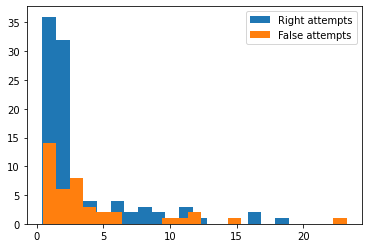

In [265]:
# Duration difference between correct and false attempts
fig, ax1 = plt.subplots()
ax1.hist(if_right_attempts[if_right_attempts["duration"]<400]["duration"]/12, bins=int(np.max(if_right_attempts[if_right_attempts["duration"]<400]["duration"])/12), label='Right attempts')
ax1.hist(if_false_attempt_df["duration"]/12, bins=int(np.max(if_false_attempt_df["duration"])/12), label='False attempts')
ax1.legend()
plt.show()

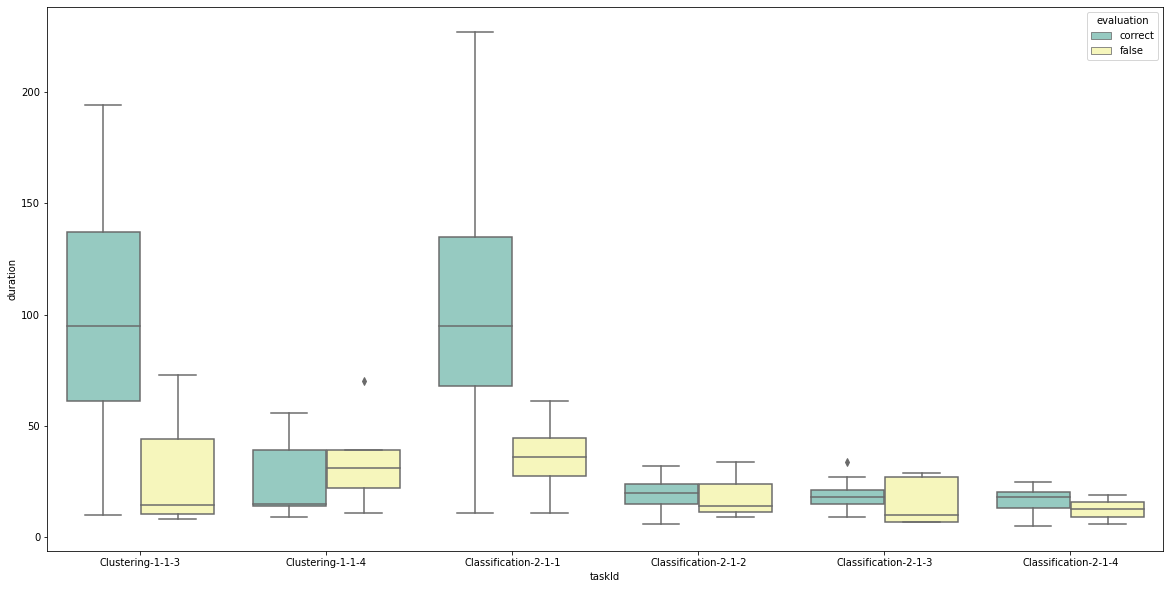

In [266]:
fig = plt.figure(figsize=(20,10))
ax = sns.boxplot(x="taskId", y="duration", hue="evaluation", data=inputfields[inputfields["duration"]<250], palette="Set3")
plt.show()

#### Hilfeanfragen bei InputFields

In [51]:
inputfields.head()

,pupilId,classId,taskId,taskSeriesId,duration,state,subType,evaluation,falseAttempts,hintsTaken,question,hints,sampleSolution,numberFalseAttempts
25,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,Clustering-1-1-3,Clustering-1,113,8,inputField,correct,[9],1,Wie viele Youtuber sind sowohl sehr aktiv als ...,In welchem Cluster sind die beliebtesten und a...,8,1.0
26,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,Clustering-1-1-4,Clustering-1,15,7,inputField,correct,NaN,NaN,"Wie viele Youtuber sind aktiv, haben aber nich...","Welche Gruppe hat viele Uploads, aber nicht so...",7,0.0
27,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,Classification-2-1-1,Classification-2,74,1,inputField,correct,NaN,NaN,Wie viele Filme stimmen zwischen Josi und Alex...,NaN,1,0.0
28,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,Classification-2-1-2,Classification-2,16,1,inputField,correct,NaN,NaN,Wie viele Filme stimmen zwischen Paul und Alex...,NaN,1,0.0
29,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,Classification-2-1-3,Classification-2,17,3,inputField,correct,NaN,NaN,Wie viele Filme stimmen zwischen Mahmud und Al...,NaN,3,0.0


## MC
### Durations

<AxesSubplot:ylabel='taskId'>

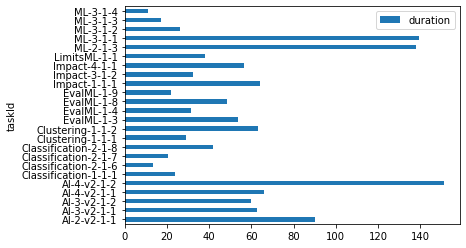

In [16]:
multipleChoice.groupby("taskId").agg(np.median)[["duration"]].plot(kind="barh")

In [69]:
multipleChoice.groupby(["taskId"]).agg([np.median, np.mean, np.std])[["duration"]]

duration                        
                       median        mean         std
taskId                                               
AI-2-v2-1-1              90.0  168.684211  159.892718
AI-3-v2-1-1              62.5  121.833333  169.541482
AI-3-v2-1-2              60.0   83.722222   64.709730
AI-4-v2-1-1              66.0   81.000000   51.310168
AI-4-v2-1-2             151.0  219.612903  199.352899
Classification-1-1-1     24.0   24.954545   11.557217
Classification-2-1-6     13.5   16.363636   13.792840
Classification-2-1-7     20.5   42.818182   51.628376
Classification-2-1-8     42.0   41.045455   24.310447
Clustering-1-1-1         29.0   33.400000   18.692690
Clustering-1-1-2         63.0  191.280000  410.878887
EvalML-1-3               53.5   60.687500   40.235505
EvalML-1-4               31.5   32.687500   21.911089
EvalML-1-8               48.5   56.875000   45.691538
EvalML-1-9               22.0   23.625000   15.713582
Impact-1-1-1             64.0   86.625000   79.421721
Impact-3-1-2             32.5   36.900000   19.130851
Impact-4-1-1             56.5   67.050000   37.578654
LimitsML-1-1             38.0   47.647059   39.938924
ML-2-1-3                138.0  144.068966   94.557213
ML-3-1-1                139.5  188.857143  152.713170
ML-3-1-2                 26.0   30.392857   21.726139
ML-3-1-3                 17.0   25.321429   26.238300
ML-3-1-4                 11.0   11.928571    9.408147

#### Besonders lange brauchen sie bei: AI-4-v2-1-2, ML-2-1-3, ML-3-1-1
TODO: Die nochmal checken. Scheinen va wrap ups und intros zu sein --> legt nahe, dass die SuS sonst eher überfliegen!

In [91]:
p99mc, p95mc, p90mc, p75mc, p25mc = np.percentile(multipleChoice["duration"], [99, 95, 90, 75 ,25])
print(p99mc, p95mc, p90mc, p75mc, p25mc)

602.9999999999991 308.0 202.5 92.0 21.0


<AxesSubplot:>

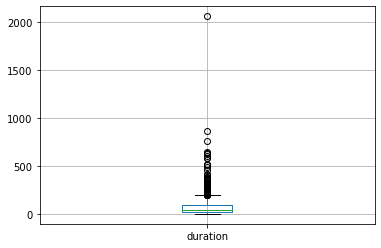

In [19]:
multipleChoice.boxplot(column=['duration'])

#### Alles über 300 sekunden scheint wirklich lang zu sein --> perzentil 95%
#### Welche Aufgaben sind das?

In [20]:
multipleChoice[multipleChoice["duration"] > 308][["taskId"]].value_counts()

taskId          
AI-4-v2-1-2         8
AI-2-v2-1-1         8
ML-3-1-1            7
ML-2-1-3            2
Clustering-1-1-2    2
AI-3-v2-1-1         2
dtype: int64

nochmal checken:
* AI-4-v2-1-2         8
* AI-2-v2-1-1         8
* ML-3-1-1            7

#### Nach SuS

In [73]:
multipleChoice[multipleChoice["duration"] > 308][["pupilId"]].value_counts()

pupilId          
kdqG4fXAK64zdrqN8    3
XKrLvRHLaM7yDisR6    3
j3AkifkKRR3t3NeoT    2
dotjrftFetJme4iPH    2
TLqNCrX4jaYixjtv7    2
R8CkqGDeQXZmHxTuk    2
MRSj5LqwWj6WSoj4E    2
FhFN5eiQduwiYKWEn    2
C2BW6tdii778v4RfL    2
7eqvpzMXwFGaYWHou    2
6bBwnX2mwAp2NAwNR    2
rsATbrReo6odn6oXD    1
Z9DkQMmtiPiHtteME    1
TWes7DiBwCuCzS2px    1
Kd6FuRsrq6QvPrkKp    1
Ay6mfswm3SFcQdNJg    1
dtype: int64

#### Durations nach Aufgabe

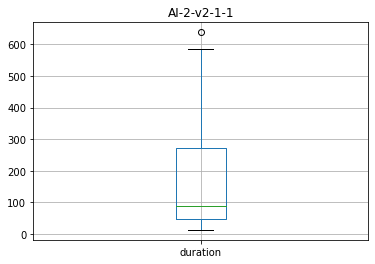

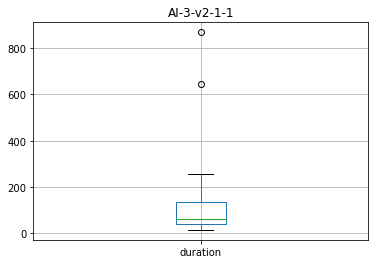

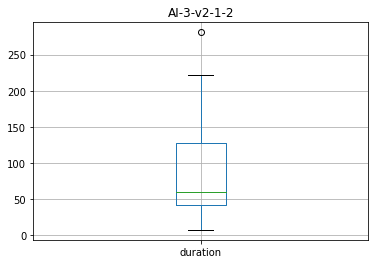

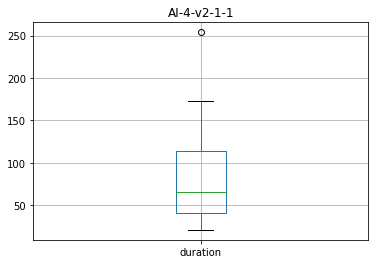

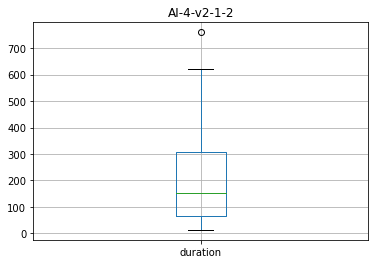

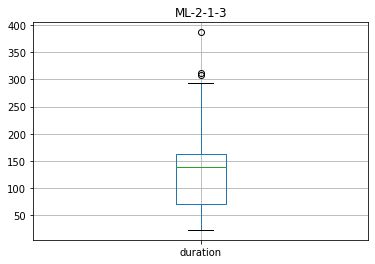

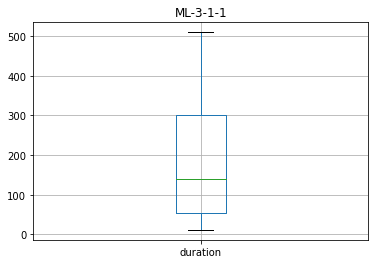

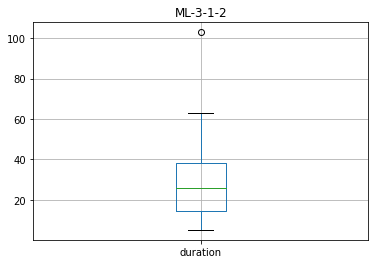

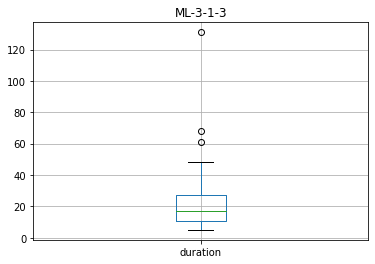

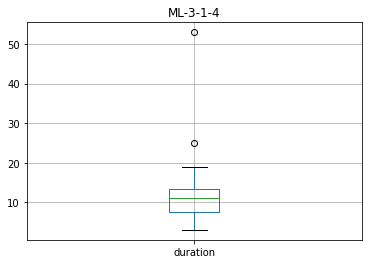

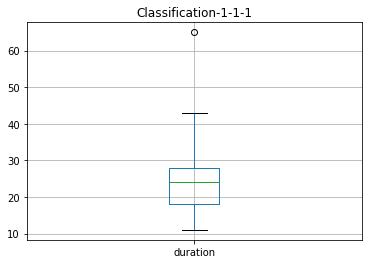

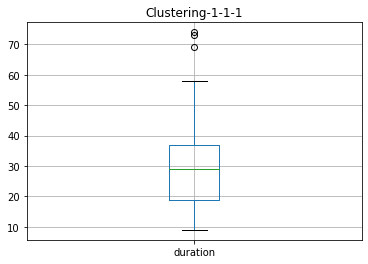

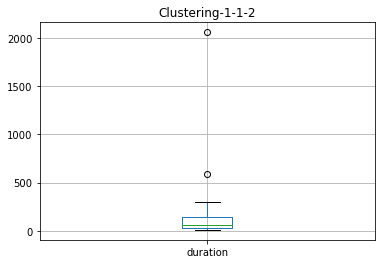

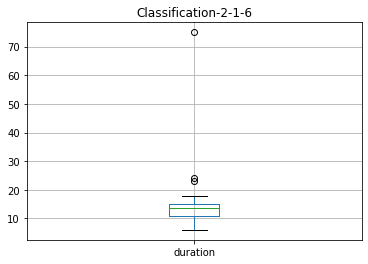

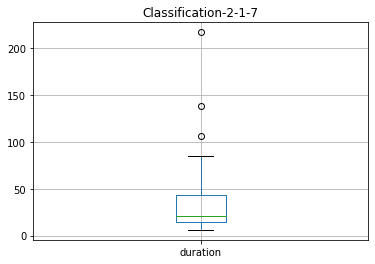

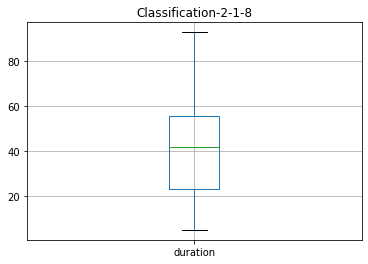

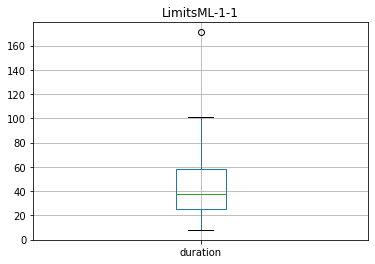

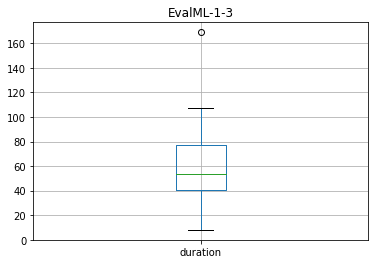

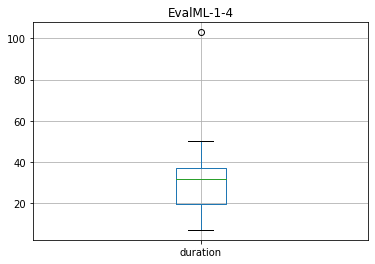

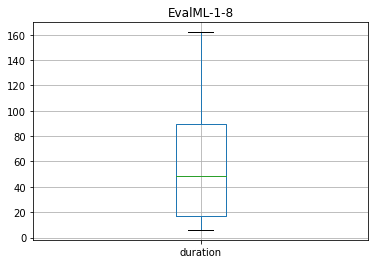

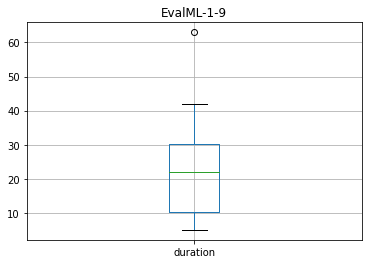

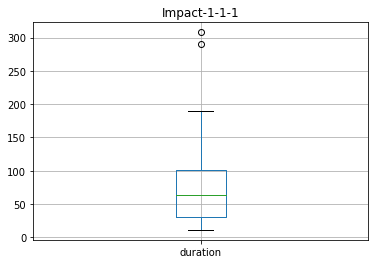

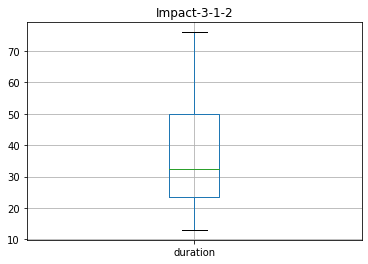

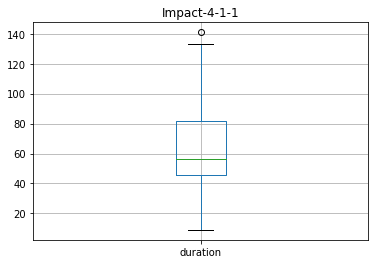

In [22]:
for taskid in multipleChoice["taskId"].unique():
    task_i = multipleChoice[multipleChoice["taskId"] == taskid]
    task_i.boxplot(column=['duration'])
    plt.title(str(taskid))
    plt.show()

### Results der MC
#### Welche wurden überhaupt hingekriegt?

['Die Personalisierung einer Google-Anfrage nutzt KI', 'Der Newsfeed eines Social Network nutzt KI', 'Gesichtserkennung nutzt KI', 'Die Startseite einer Webseite, die jedem Besucher die gleichen Inhalte anzeigt nutzt KI']


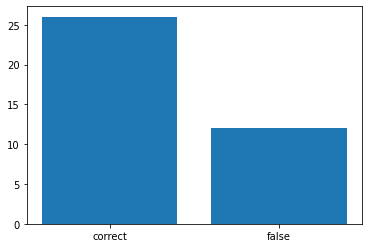

['Die Anwendung, die den Facebook-Feed erstellt, kann auch Schach spielen', 'Das Programm zur Gesichtserkennung auf deinem Handy kann auch Auto fahren', 'Eine Sprachsteuerung wie Siri oder Alexa kann auch Gesichter erkennen']


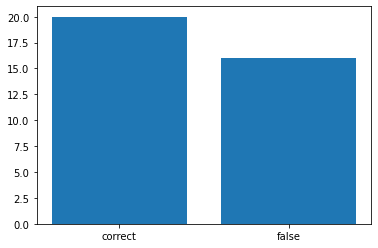

['Eine KI aus einem Film, die eigenständige Entscheidungen trifft, mit Menschen spricht und sich am Ende gegen sie wendet, gehört zur allgemeinen KI', 'Empfehlungssysteme gehören zur spezifischen KI', 'Programme zur Bilderkennung gehören zur allgemeinen KI']


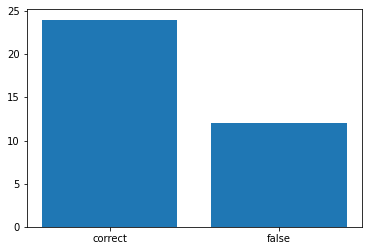

['KI-Anwendungen sind allgemein intelligent', 'Eine KI, die sich in einem einzigen Bereich so intelligent verhält wie ein Mensch, muss allgemeine Intelligenz besitzen', 'KI-Anwendungen zeigen intelligentes Verhalten in einem kleinen Bereich', 'Intelligentes Verhalten in einem spezifischen Bereich muss nicht gleich allgemeine Intelligenz bedeuten']


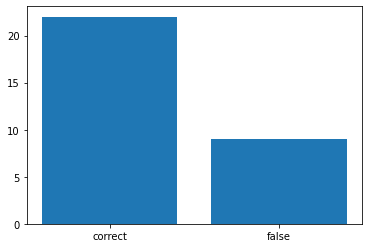

['Ein Spam-Filter ist eine allgemeinen KI', 'Intelligentes Verhalten setzt allgemeine Intelligenz voraus', 'Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht', 'KI-Anwendungen treffen eigenständige Entscheidungen', 'Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen', 'KI-Anwendungen lernen durch Erfahrung', 'Heutige KI-Anwendungen gehören alle zur spezifischen KI']


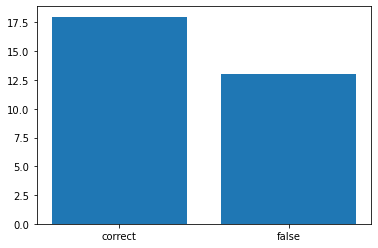

['Unser Ziel ist es, einen Algorithmus zu trainieren, der für neue Bilder das richtige Label vorhersagen kann. Also zu sagen, ob ein Bild einen Hund oder eine Katze zeigt', 'Für das Training nutzen wir Daten ohne Label', 'Die Daten, die wir für das Training benutzen, heißen Trainingsdaten', 'Nach dem Training testen wir nochmal auf ein paar neuen Daten, wie gut die Vorhersagen des Algorithmus sind']


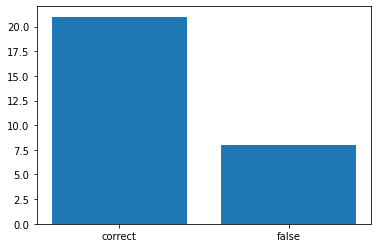

['Das überwachte und das unüberwachte Lernen unterscheiden sich zum Beispiel daran, dass wir einmal Daten mit und einmal Daten ohne Label nutzen', 'Maschinelles Lernen ist ein Teilbereich der KI', 'Das maschinelle Lernen beschäftigt sich mit Programmen, die selbständig in großen Datenmengen Gesetzmäßigkeiten erkennen können', 'Beim unüberwachten Lernen wollen wir lernen, für neue Daten das richtige Label vorherzusagen']


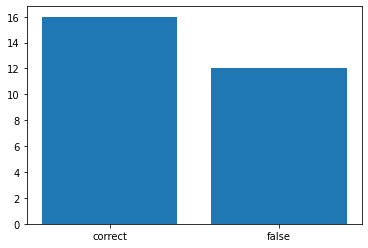

['Unüberwachtes Lernen', 'Überwachtes Lernen']


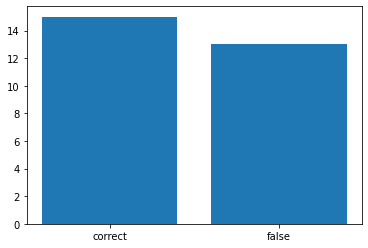

['Unüberwachtes Lernen', 'Überwachtes Lernen']


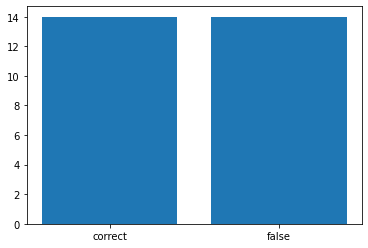

['Unüberwachtes Lernen', 'Überwachtes Lernen']


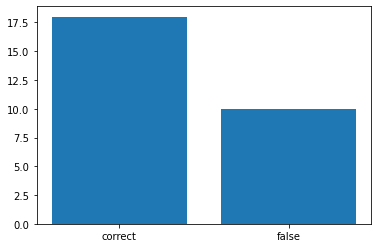

['Beim überwachten Lernen versucht man Struktur in Daten zu finden', 'Beim überwachten Lernen braucht man Daten ohne Label', 'Einen Algorithmus zu trainieren, der Bildern mit Hunden das Label “Hund” gibt, wäre ein Fall für überwachtes Lernen']


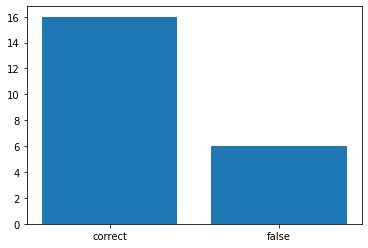

['Beim unüberwachten Lernen wollen wir die richtigen Label für neue Daten vorhersagen', 'Beim unüberwachten Lernen nutzt man Daten mit Label', 'Beim unüberwachten Lernen geht es darum, Struktur in den Daten zu finden', 'Beim unüberwachten Lernen hat man keine Label für die Daten']


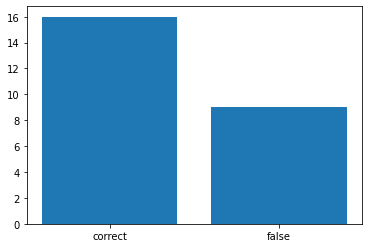

['Die Youtuber im blauen Cluster laden öfter Videos hoch', 'Die Youtuber im roten Cluster laden öfter Videos hoch']


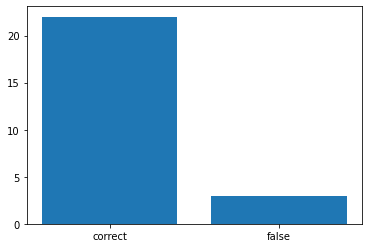

['Anna', 'Paul', 'Josi', 'Isa', 'Mahmud']


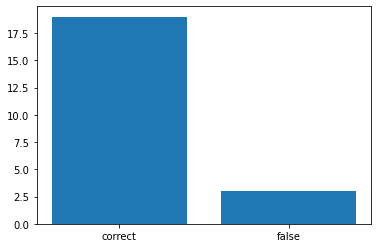

['Avengers Endgame', 'James Bond', 'Fluch der Karibik', 'Herr der Ringe', 'Hangover']


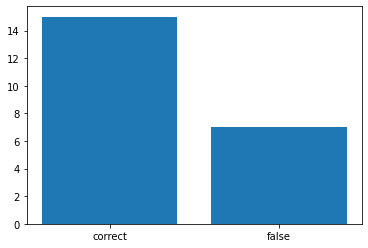

['Ein Algorithmus, der anhand vieler alter Fälle gelernt hat, medizinische Diagnosen zu stellen, gehört zum überwachten Lernen', 'Ein Algorithmus, der dir basierend auf deinen Lieblingsfächern einen Beruf vorschlägt, könnte man mittels überwachtem Lernen umsetzen', 'Ein Algorithmus, der ähnliche Berufe gruppiert, gehört zum überwachten Lernen']


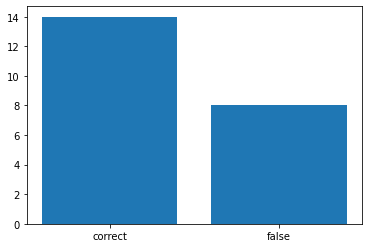

['Der Algorithmus würde immer noch alle Hunderassen als Hunde erkennen, weil es keine Katzen sind', 'Bei Hunden anderer Rassen ist es schwer zu sagen, ob er sie erkennen würde, aber sehr wahrscheinlich nicht so zuverlässig', 'Der Algorithmus würde nur Hunde dieser Rasse zuverlässig als Hunde erkennen']


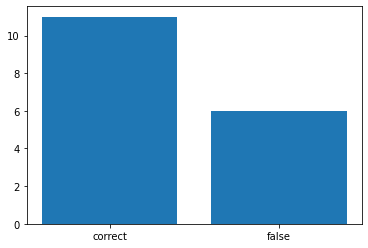

['KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen', 'Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich', 'Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen', 'Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI', 'Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören', 'Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist', 'Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren', 'KI kann irgendwann alles besser als der Mensch', 'Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI']


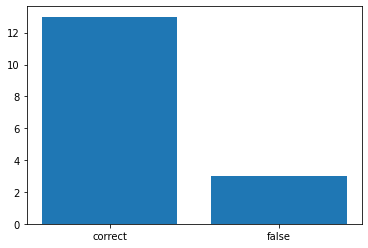

['Die Erkennung von Gegenständen auf Bildern', 'Eine Nachrichtenseite, die jedem Nutzer den gleichen Inhalt präsentiert', 'Ein personalisiertes Empfehlungssystem für Musik', 'Das Sortieren von Bildern nach Datum']


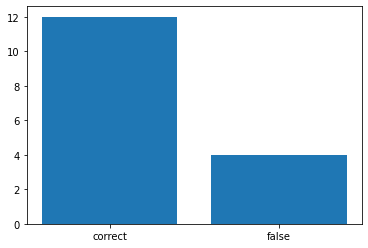

['Algorithmen des maschinellen Lernens können aus vorhandenen Daten selbständig lernen', 'Algorithmen des maschinellen Lernens lernen nur, was in den Daten vorhanden ist. Daher ist die Auswahl an Trainingsdaten sehr wichtig', 'Algorithmen des maschinellen Lernens benötigen oft große Mengen an Daten, damit sie gute Ergebnisse erzielen', 'Beim überwachten Lernen nutzen wir Daten ohne Label', 'Clustering ist ein Beispiel für unüberwachtes Lernen', 'Wenn wir für Daten Label vorhersagen wollen, betreiben wir Clustering', 'Beim unüberwachten Lernen versuchen wir, Strukturen in den Daten zu entdecken', 'Wenn wir für Daten Label vorhersagen wollen, betreiben wir überwachtes Lernen']


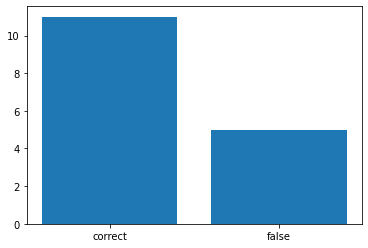

['Eine Webseite, die ähnliche Rezepte gruppiert, wäre eine Aufgabe für das Clustering', 'Eine Webseite, die für neue Rezepte vorhersagt, ob sie dir “gefallen” oder “nicht gefallen”, ist eine Aufgabe für das überwachte Lernen']


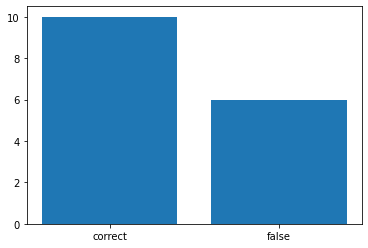

['Die Trainingsdaten, mit denen der Algorithmus gelernt hat, enthielten keine oder kaum Bilder von dunkelhäutigen Menschen', 'Der Algorithmus wurde falsch programmiert']


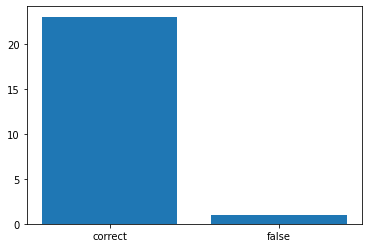

['Angestellte im Kundenservice', 'LKW- und Taxifahrer', 'Wissenschaftler', 'Angestellte bei einer Bank oder Versicherung', 'Lehrer', 'Pflegepersonal']


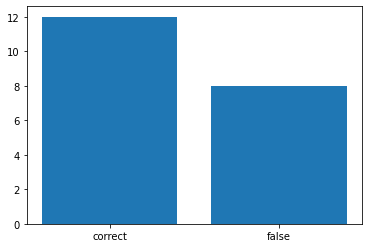

['KI kann helfen, die richtigen Behandlungen zu empfehlen', 'KI kann die Erkennung von Tumoren auf Scans verbessern', 'KI kann die medizinische Versorgung günstiger machen', 'KI-Methoden können immer die richtige Diagnose stellen', 'KI kann helfen, die Behandlungen besser an jeden einzelnen Patienten anzupassen', 'KI-Methoden werden Ärzte komplett ersetzen', 'KI kann helfen, bessere Diagnosen zu stellen']


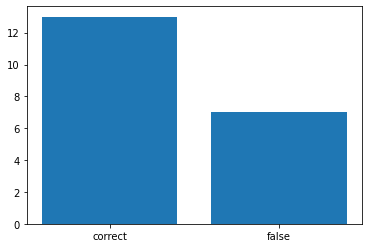

In [23]:
for i in multipleChoice["taskId"].unique():
    answers = []
    for answer in multipleChoice[multipleChoice["taskId"] == i]["answers"]:
        for answeritem in answer:
            #print(answeritem)
            answers.append(answeritem["de"])
    print(list(set(answers)))
    #sns.barplot(x="day", y="total_bill", data=tips)
    #sns.barplot(data=np.array(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts()))
    plt.bar(["correct", "false"], np.array(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts()))
    plt.show()

#### Welche wurden beim ersten mal hingekriegt?

AI-2-v2-1-1


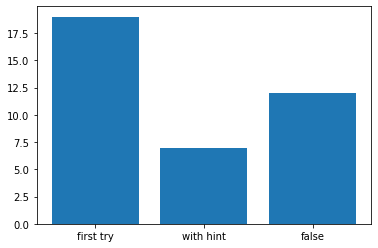

gleich hingekriegt: 50.0%
mit hints hingekriegt: 18.42%
nicht hingekriegt: 31.58%
--------------------------------------------------

AI-3-v2-1-1


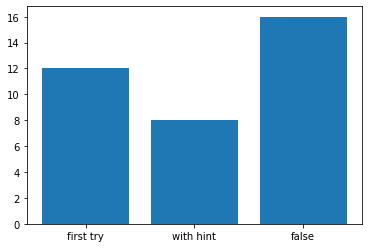

gleich hingekriegt: 33.33333333333333%
mit hints hingekriegt: 22.22%
nicht hingekriegt: 44.44%
--------------------------------------------------

AI-3-v2-1-2


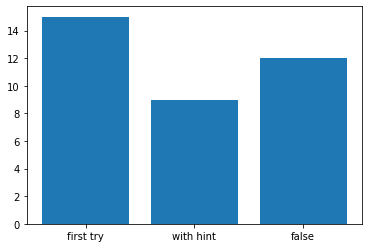

gleich hingekriegt: 41.66666666666667%
mit hints hingekriegt: 25.0%
nicht hingekriegt: 33.33%
--------------------------------------------------

AI-4-v2-1-1


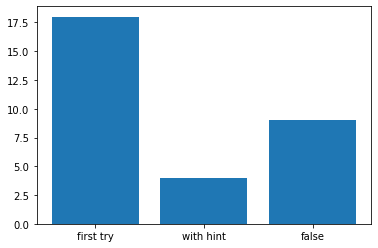

gleich hingekriegt: 58.06451612903226%
mit hints hingekriegt: 12.9%
nicht hingekriegt: 29.03%
--------------------------------------------------

AI-4-v2-1-2


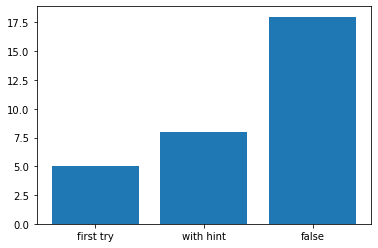

gleich hingekriegt: 16.129032258064516%
mit hints hingekriegt: 25.81%
nicht hingekriegt: 58.06%
--------------------------------------------------

ML-2-1-3


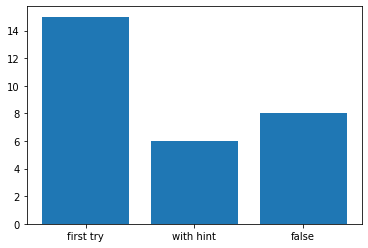

gleich hingekriegt: 51.724137931034484%
mit hints hingekriegt: 20.69%
nicht hingekriegt: 27.59%
--------------------------------------------------

ML-3-1-1


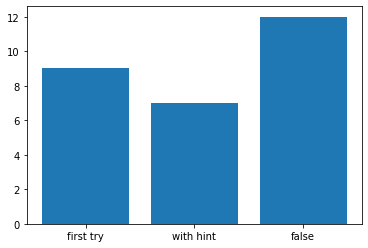

gleich hingekriegt: 32.142857142857146%
mit hints hingekriegt: 25.0%
nicht hingekriegt: 42.86%
--------------------------------------------------

ML-3-1-2


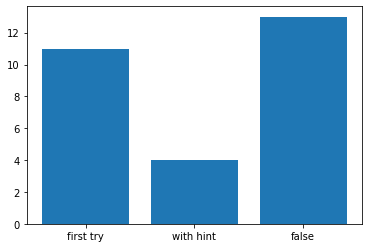

gleich hingekriegt: 39.285714285714285%
mit hints hingekriegt: 14.29%
nicht hingekriegt: 46.43%
--------------------------------------------------

ML-3-1-3


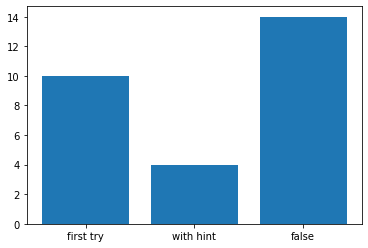

gleich hingekriegt: 35.714285714285715%
mit hints hingekriegt: 14.29%
nicht hingekriegt: 50.0%
--------------------------------------------------

ML-3-1-4


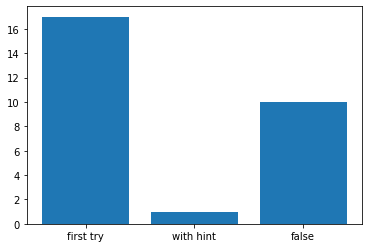

gleich hingekriegt: 60.71428571428571%
mit hints hingekriegt: 3.57%
nicht hingekriegt: 35.71%
--------------------------------------------------

Classification-1-1-1


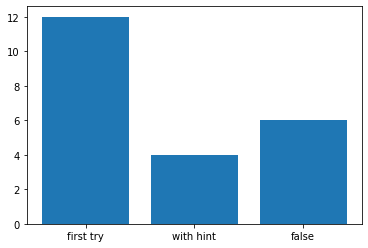

gleich hingekriegt: 54.54545454545454%
mit hints hingekriegt: 18.18%
nicht hingekriegt: 27.27%
--------------------------------------------------

Clustering-1-1-1


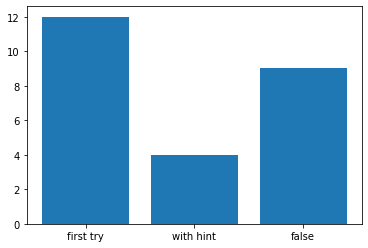

gleich hingekriegt: 48.0%
mit hints hingekriegt: 16.0%
nicht hingekriegt: 36.0%
--------------------------------------------------

Clustering-1-1-2


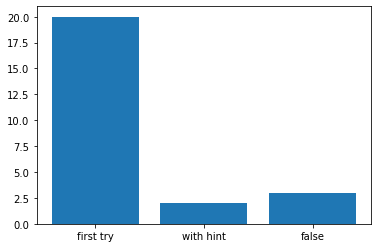

gleich hingekriegt: 80.0%
mit hints hingekriegt: 8.0%
nicht hingekriegt: 12.0%
--------------------------------------------------

Classification-2-1-6


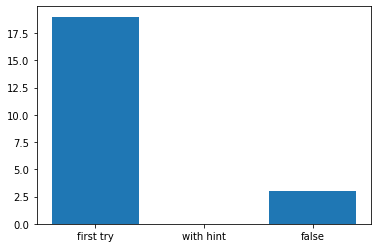

gleich hingekriegt: 86.36363636363636%
mit hints hingekriegt: 0.0%
nicht hingekriegt: 13.64%
--------------------------------------------------

Classification-2-1-7


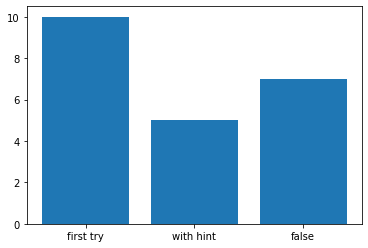

gleich hingekriegt: 45.45454545454545%
mit hints hingekriegt: 22.73%
nicht hingekriegt: 31.82%
--------------------------------------------------

Classification-2-1-8


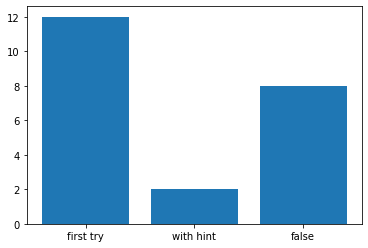

gleich hingekriegt: 54.54545454545454%
mit hints hingekriegt: 9.09%
nicht hingekriegt: 36.36%
--------------------------------------------------

LimitsML-1-1


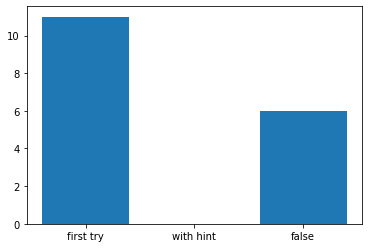

gleich hingekriegt: 64.70588235294117%
mit hints hingekriegt: 0.0%
nicht hingekriegt: 35.29%
--------------------------------------------------

EvalML-1-3


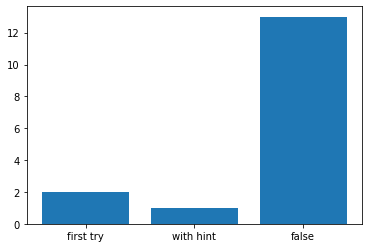

gleich hingekriegt: 12.5%
mit hints hingekriegt: 6.25%
nicht hingekriegt: 81.25%
--------------------------------------------------

EvalML-1-4


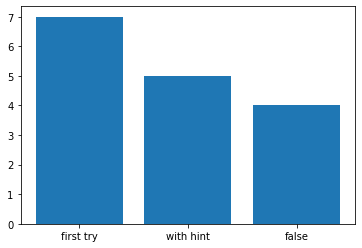

gleich hingekriegt: 43.75%
mit hints hingekriegt: 31.25%
nicht hingekriegt: 25.0%
--------------------------------------------------

EvalML-1-8


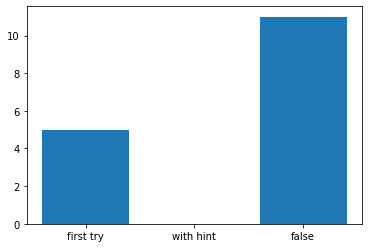

gleich hingekriegt: 31.25%
mit hints hingekriegt: 0.0%
nicht hingekriegt: 68.75%
--------------------------------------------------

EvalML-1-9


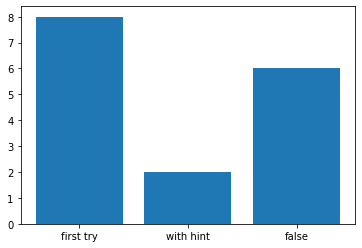

gleich hingekriegt: 50.0%
mit hints hingekriegt: 12.5%
nicht hingekriegt: 37.5%
--------------------------------------------------

Impact-1-1-1


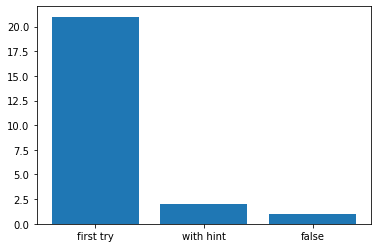

gleich hingekriegt: 87.5%
mit hints hingekriegt: 8.33%
nicht hingekriegt: 4.17%
--------------------------------------------------

Impact-3-1-2


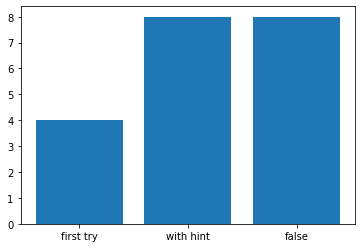

gleich hingekriegt: 20.0%
mit hints hingekriegt: 40.0%
nicht hingekriegt: 40.0%
--------------------------------------------------

Impact-4-1-1


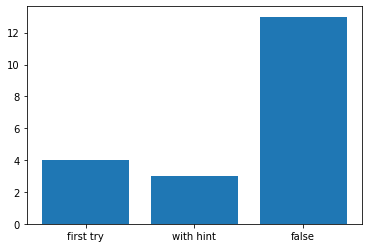

gleich hingekriegt: 20.0%
mit hints hingekriegt: 15.0%
nicht hingekriegt: 65.0%
--------------------------------------------------



In [24]:
for taskId in multipleChoice["taskId"].unique():
    print(taskId)
    task_i = multipleChoice[multipleChoice["taskId"] == taskId]
    
    # number students who did this task
    nr_students_with_task_i = len(task_i)
    
    # students with and without false attempts
    without_false_attempts = task_i[task_i["falseAttempts"] != task_i["falseAttempts"]]
    #with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    nr_without_false_attempts = len(without_false_attempts)
    #nr_with_false_attempts = len(with_false_attempts)
    
    # students with correct of false evaluation
    #with_correct_eval = task_i[task_i["evaluation"] == "correct"]
    with_correct_eval_and_false_attempts = task_i[(task_i["evaluation"] == "correct") & (task_i["falseAttempts"] == task_i["falseAttempts"])]
    with_false_eval = task_i[task_i["evaluation"] == "false"]
    #nr_with_correct_eval = len(with_correct_eval)
    nr_with_correct_eval_and_false_attempts = len(with_correct_eval_and_false_attempts)
    nr_with_false_eval = len(with_false_eval)
    
    # plotting/printing results
    cases=["first try", "with hint", "false"]
    nr_cases = [nr_without_false_attempts, nr_with_correct_eval_and_false_attempts, nr_with_false_eval]
    plt.bar(cases, nr_cases)
    plt.show()
    print("gleich hingekriegt: " + str((nr_without_false_attempts/nr_students_with_task_i)*100) + "%")
    print("mit hints hingekriegt: " + str(round((nr_with_correct_eval_and_false_attempts/nr_students_with_task_i)*100, 2)) + "%")
    print("nicht hingekriegt: " + str(round((nr_with_false_eval/nr_students_with_task_i)*100, 2)) + "%")
    print("--------------------------------------------------")
    print("")

Mehr Fehler als richtige bei:
* AI-4-v2-1-2
* EvalML-1-3
* EvalML-1-8
* Impact-4-1-1

### Welche Antworten waren das Problem?

AI-2-v2-1-1
Kannst du erkennen, wo KI überall drin steckt? Denke dabei an die Eigenschaften, die alle KI-Anwendungen verbindet. Bei Multiple-Choice Aufgaben, neben denen “Mehrfachauswahl” steht, können mehrere Antworten richtig sein. Wähle alle richtigen Antworten aus. Wenn du mal nicht weiter weißt, kannst du dir auch einen Tipp holen.

* 1. Die Personalisierung einer Google-Anfrage nutzt KI
* 2. Der Newsfeed eines Social Network nutzt KI
* 3. Gesichtserkennung nutzt KI
* 4. Die Startseite einer Webseite, die jedem Besucher die gleichen Inhalte anzeigt nutzt KI


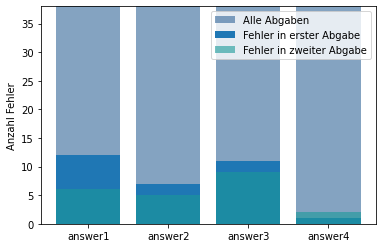

In 50.0% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

AI-3-v2-1-1
Was für Sachen können KI-Anwendungen?

* 1. Die Anwendung, die den Facebook-Feed erstellt, kann auch Schach spielen
* 2. Das Programm zur Gesichtserkennung auf deinem Handy kann auch Auto fahren
* 3. Eine Sprachsteuerung wie Siri oder Alexa kann auch Gesichter erkennen


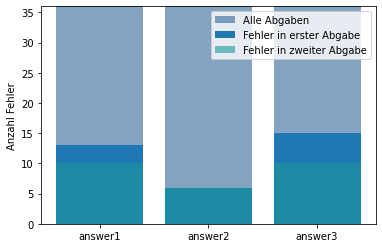

In 66.66666666666666% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

AI-3-v2-1-2
Welche der Aussagen über KI-Anwendungen stimmen?

* 1. Eine KI aus einem Film, die eigenständige Entscheidungen trifft, mit Menschen spricht und sich am Ende gegen sie wendet, gehört zur allgemeinen KI
* 2. Empfehlungssysteme gehören zur spezifischen KI
* 3. Programme zur Bilderkennung gehören zur allgemeinen KI


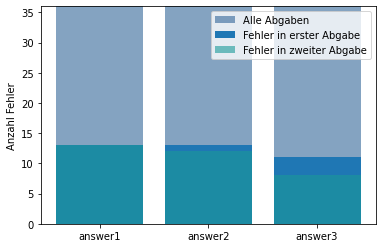

In 58.333333333333336% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

AI-4-v2-1-1
Was bedeuten diese Unterscheidung zwischen spezifischer und allgemeiner KI jetzt für die Intelligenz von KI-Anwendungen?

* 1. KI-Anwendungen sind allgemein intelligent
* 2. Eine KI, die sich in einem einzigen Bereich so intelligent verhält wie ein Mensch, muss allgemeine Intelligenz besitzen
* 3. KI-Anwendungen zeigen intelligentes Verhalten in einem kleinen Bereich
* 4. Intelligentes Verhalten in einem spezifischen Bereich muss nicht gleich allgemeine Intelligenz bedeuten


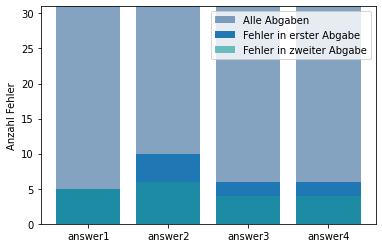

In 41.935483870967744% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?

* 1. Ein Spam-Filter ist eine allgemeinen KI
* 2. Intelligentes Verhalten setzt allgemeine Intelligenz voraus
* 3. Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht
* 4. KI-Anwendungen treffen eigenständige Entscheidungen
* 5. Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen
* 6. KI-Anwendungen lernen durch Erfahrung
* 7. Heutige KI-Anwendungen gehören alle zur spezifischen KI


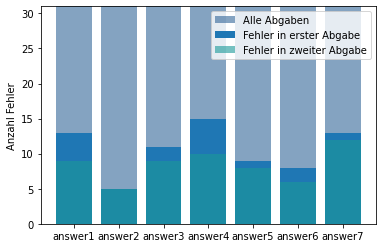

In 83.87096774193549% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

ML-2-1-3
Lass uns das Wichtigste nochmal wiederholen:

* 1. Unser Ziel ist es, einen Algorithmus zu trainieren, der für neue Bilder das richtige Label vorhersagen kann. Also zu sagen, ob ein Bild einen Hund oder eine Katze zeigt
* 2. Für das Training nutzen wir Daten ohne Label
* 3. Die Daten, die wir für das Training benutzen, heißen Trainingsdaten
* 4. Nach dem Training testen wir nochmal auf ein paar neuen Daten, wie gut die Vorhersagen des Algorithmus sind


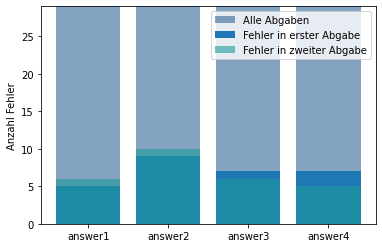

In 48.275862068965516% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

ML-3-1-1
Welche Aussagen stimmen?

* 1. Das überwachte und das unüberwachte Lernen unterscheiden sich zum Beispiel daran, dass wir einmal Daten mit und einmal Daten ohne Label nutzen
* 2. Maschinelles Lernen ist ein Teilbereich der KI
* 3. Das maschinelle Lernen beschäftigt sich mit Programmen, die selbständig in großen Datenmengen Gesetzmäßigkeiten erkennen können
* 4. Beim unüberwachten Lernen wollen wir lernen, für neue Daten das richtige Label vorherzusagen


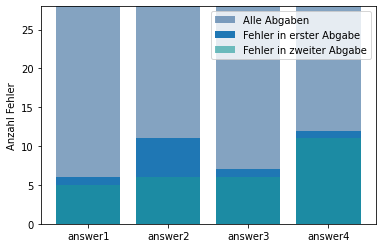

In 67.85714285714286% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

ML-3-1-2
Ein Empfehlungssystem für Musik, das lernt, was du für Musik magst und dann für neu erscheinende Musik voraussagt, ob du sie mögen würdest.

* 1. Unüberwachtes Lernen
* 2. Überwachtes Lernen


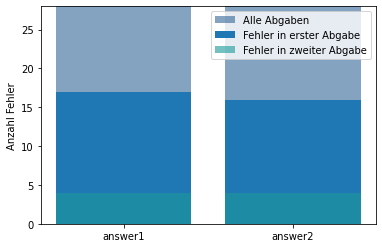

In 60.71428571428571% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

ML-3-1-3
Die Gesichtserkennung von deinem Handy. Anfangs musst du dein Gesicht aus verschiedenen Winkeln filmen. Anhand dieser Beispiele lernt es, dein Gesicht zu erkennen. Wenn dann irgendein Gesicht versucht, dein Handy zu entsperren, kann es voraussagen, ob es dein Gesicht ist oder nicht.

* 1. Unüberwachtes Lernen
* 2. Überwachtes Lernen


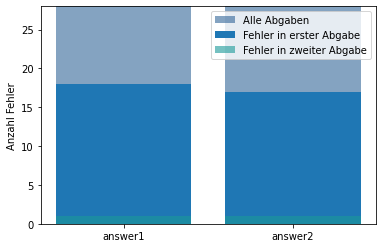

In 64.28571428571429% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

ML-3-1-4
Wenn wir Youtuber nach der Anzahl ihrer Follower und der Themen ihrer Videos gruppieren.

* 1. Unüberwachtes Lernen
* 2. Überwachtes Lernen


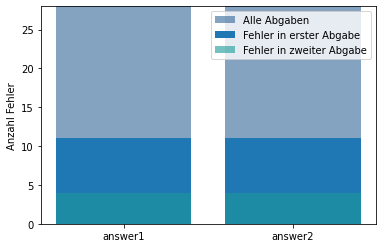

In 39.285714285714285% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Classification-1-1-1
Welche Aussagen stimmen?

* 1. Beim überwachten Lernen versucht man Struktur in Daten zu finden
* 2. Beim überwachten Lernen braucht man Daten ohne Label
* 3. Einen Algorithmus zu trainieren, der Bildern mit Hunden das Label “Hund” gibt, wäre ein Fall für überwachtes Lernen


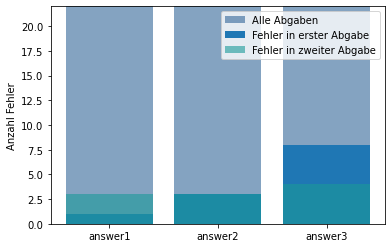

In 45.45454545454545% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Clustering-1-1-1
Was war unüberwachtes Lernen noch gleich?

* 1. Beim unüberwachten Lernen wollen wir die richtigen Label für neue Daten vorhersagen
* 2. Beim unüberwachten Lernen nutzt man Daten mit Label
* 3. Beim unüberwachten Lernen geht es darum, Struktur in den Daten zu finden
* 4. Beim unüberwachten Lernen hat man keine Label für die Daten


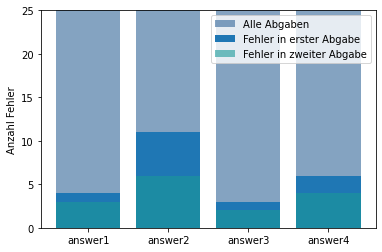

In 52.0% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Clustering-1-1-2
Welche Aussagen über die anderen beiden Cluster stimmen?

* 1. Die Youtuber im blauen Cluster laden öfter Videos hoch
* 2. Die Youtuber im roten Cluster laden öfter Videos hoch


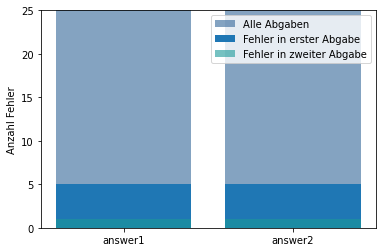

In 20.0% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Classification-2-1-6
Wer hat den ähnlichsten Filmgeschmack zu Alex?

* 1. Anna
* 2. Paul
* 3. Josi
* 4. Isa
* 5. Mahmud


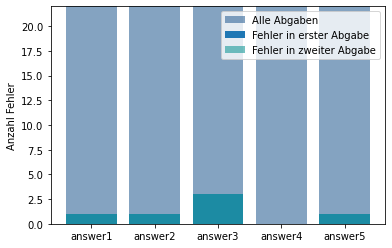

In 13.636363636363635% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Classification-2-1-7
Welchen Film kannst du Alex guten Gewissens empfehlen?

* 1. Avengers Endgame
* 2. James Bond
* 3. Fluch der Karibik
* 4. Herr der Ringe
* 5. Hangover


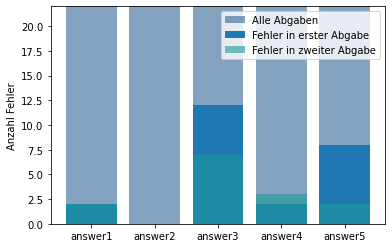

In 54.54545454545454% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Classification-2-1-8
Welche Aussagen stimmen?

* 1. Ein Algorithmus, der anhand vieler alter Fälle gelernt hat, medizinische Diagnosen zu stellen, gehört zum überwachten Lernen
* 2. Ein Algorithmus, der dir basierend auf deinen Lieblingsfächern einen Beruf vorschlägt, könnte man mittels überwachtem Lernen umsetzen
* 3. Ein Algorithmus, der ähnliche Berufe gruppiert, gehört zum überwachten Lernen


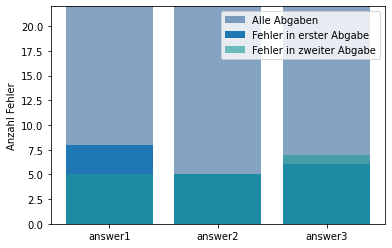

In 45.45454545454545% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

LimitsML-1-1
Was könnte passieren, wenn wir bei den Hundebildern nur Bilder von einer Hunderasse nutzen würden?

* 1. Der Algorithmus würde immer noch alle Hunderassen als Hunde erkennen, weil es keine Katzen sind
* 2. Bei Hunden anderer Rassen ist es schwer zu sagen, ob er sie erkennen würde, aber sehr wahrscheinlich nicht so zuverlässig
* 3. Der Algorithmus würde nur Hunde dieser Rasse zuverlässig als Hunde erkennen


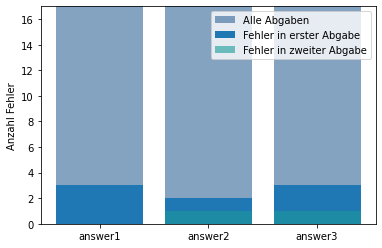

In 35.294117647058826% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

EvalML-1-3
Welche der Aussagen stimmen?

* 1. KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen
* 2. Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich
* 3. Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen
* 4. Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI
* 5. Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören
* 6. Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist
* 7. Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren
* 8. KI kann irgendwann alles besser als der Mensch
* 9. Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI


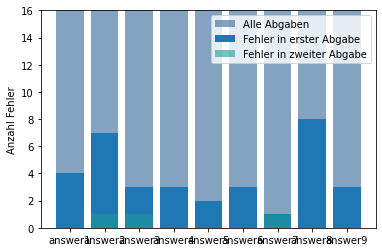

In 87.5% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

EvalML-1-4
Welche der folgenden Anwendungen enthalten KI-Methoden?

* 1. Die Erkennung von Gegenständen auf Bildern
* 2. Eine Nachrichtenseite, die jedem Nutzer den gleichen Inhalt präsentiert
* 3. Ein personalisiertes Empfehlungssystem für Musik
* 4. Das Sortieren von Bildern nach Datum


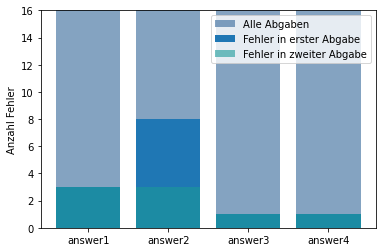

In 56.25% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

EvalML-1-8
Welche der Aussagen über maschinelles Lernen stimmen?

* 1. Algorithmen des maschinellen Lernens können aus vorhandenen Daten selbständig lernen
* 2. Algorithmen des maschinellen Lernens lernen nur, was in den Daten vorhanden ist. Daher ist die Auswahl an Trainingsdaten sehr wichtig
* 3. Algorithmen des maschinellen Lernens benötigen oft große Mengen an Daten, damit sie gute Ergebnisse erzielen
* 4. Beim überwachten Lernen nutzen wir Daten ohne Label
* 5. Clustering ist ein Beispiel für unüberwachtes Lernen
* 6. Wenn wir für Daten Label vorhersagen wollen, betreiben wir Clustering
* 7. Beim unüberwachten Lernen versuchen wir, Strukturen in den Daten zu entdecken
* 8. Wenn wir für Daten Label vorhersagen wollen, betreiben wir überwachtes Lernen


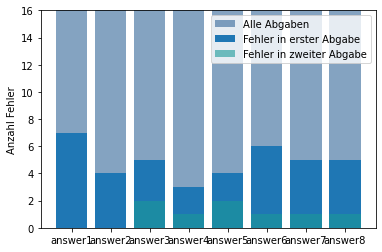

In 68.75% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

EvalML-1-9
Welche Art des Lernens sind folgende Aufgaben?

* 1. Eine Webseite, die ähnliche Rezepte gruppiert, wäre eine Aufgabe für das Clustering
* 2. Eine Webseite, die für neue Rezepte vorhersagt, ob sie dir “gefallen” oder “nicht gefallen”, ist eine Aufgabe für das überwachte Lernen


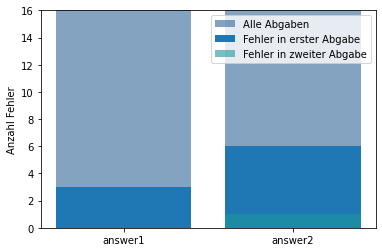

In 50.0% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Impact-1-1-1
Was glaubst du, warum das Gesicht der dunkelhäutigen Frau nicht erkannt wurde?

* 1. Die Trainingsdaten, mit denen der Algorithmus gelernt hat, enthielten keine oder kaum Bilder von dunkelhäutigen Menschen
* 2. Der Algorithmus wurde falsch programmiert


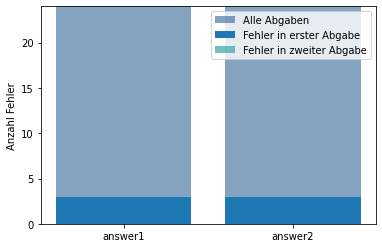

In 12.5% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Impact-3-1-2
Welche Jobs sind also bedroht?

* 1. Angestellte im Kundenservice
* 2. LKW- und Taxifahrer
* 3. Wissenschaftler
* 4. Angestellte bei einer Bank oder Versicherung
* 5. Lehrer
* 6. Pflegepersonal


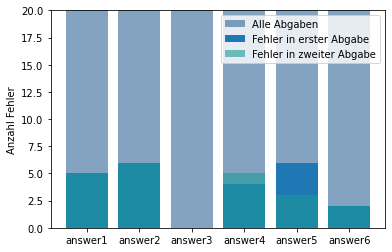

In 80.0% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Impact-4-1-1
Was sind möglichen Folgen vom Einsatz von KI in der Medizin?

* 1. KI kann helfen, die richtigen Behandlungen zu empfehlen
* 2. KI kann die Erkennung von Tumoren auf Scans verbessern
* 3. KI kann die medizinische Versorgung günstiger machen
* 4. KI-Methoden können immer die richtige Diagnose stellen
* 5. KI kann helfen, die Behandlungen besser an jeden einzelnen Patienten anzupassen
* 6. KI-Methoden werden Ärzte komplett ersetzen
* 7. KI kann helfen, bessere Diagnosen zu stellen


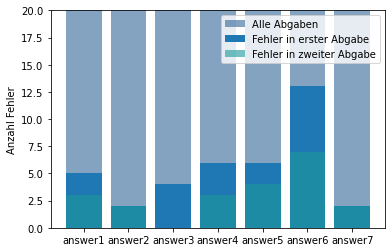

In 80.0% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------



In [68]:
for taskId in multipleChoice["taskId"].unique():
    print(taskId)
    task_i = multipleChoice[multipleChoice["taskId"] == taskId]
    sampleSolution_i = list(task_i["sampleSolution"][0:1])[0]
    print(task_i["question"].unique()[0])
    print("")

    answers = []
    for answer in task_i["answers"]:
        for answeritem in answer:
            answers.append(answeritem["de"])
    answers_i = list(set(answers))
    for i in range(len(answers_i)):
        print("* " + str(i+1) + ". " + answers_i[i])

    with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    without_false_attempts = task_i[task_i["falseAttempts"] != task_i["falseAttempts"]]
    first_falseAttempts_i = [elem[0] for elem in with_false_attempts["falseAttempts"]]
    # für alle false attempts: [ item for elem in with_false_attempts["falseAttempts"] for item in elem]
    second_falseAttempts_i = [elem[1] if len(elem) >1 else [] for elem in with_false_attempts["falseAttempts"]]
    
    nr_all_tasks = np.array([len(task_i) for answer in sampleSolution_i])
    nr_errors_in_first_false_attempt = np.array([0 for answer in sampleSolution_i])
    nr_errors_in_second_false_attempt = np.array([0 for answer in sampleSolution_i])
    for falseAttempt in first_falseAttempts_i:
        nr_errors_in_first_false_attempt += np.array([a != f for a,f in zip(sampleSolution_i,falseAttempt)]).astype(int)
    
    for falseAttempt in second_falseAttempts_i:
        if(len(falseAttempt)>=1):
            nr_errors_in_second_false_attempt += np.array([a != f for a,f in zip(sampleSolution_i,falseAttempt)]).astype(int)
    
    labels = ["answer" + str(i) for i in range(1, len(sampleSolution_i)+1)]
    plt.bar(labels, nr_all_tasks, color=(0.2, 0.4, 0.6, 0.6)) #0.1, 0.1, 0.1, 0.1 #0.2, 0.4, 0.6, 0.6
    plt.bar(labels, nr_errors_in_first_false_attempt)
    plt.bar(labels, nr_errors_in_second_false_attempt, color=(0.1, 0.6, 0.6, 0.6))
    plt.legend(["Alle Abgaben", "Fehler in erster Abgabe", "Fehler in zweiter Abgabe"])
    plt.ylim([0, len(task_i)])
    plt.ylabel("Anzahl Fehler")
    plt.show()
    
    print("In " + str((len(first_falseAttempts_i)/len(task_i))*100) + "% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht")
    #print("so oft wurde die aufgabe gemacht: " + str(len(task_i)))
    #print("so oft wurde beim ersten abgeben etwas falsch gemacht: " + str(len(first_falseAttempts_i)))
    print("--------------------------------------------------")
    print("")

#### Zweite abgaben werden besser
#### Fast immer weniger Fehler bei den Antworten, aber mit 66% immer noch zu viele falsche

#### Weiteres:
* falseAttempts relativ dazu, wie viele hints es gab? (bisher ignoriert, weil eh alle mehrfach gezählt werden)

## Freitext

### Duations

<AxesSubplot:ylabel='taskId'>

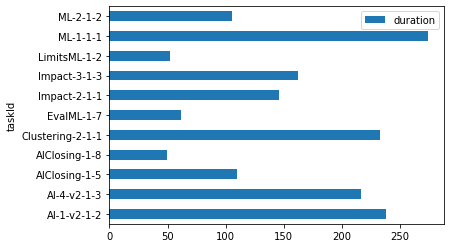

In [71]:
freetext.groupby("taskId").agg(np.median)[["duration"]].plot(kind="barh")

In [74]:
freetext.groupby(["taskId"]).agg([np.median, np.mean, np.std])[["duration"]]

duration                        
                   median        mean         std
taskId                                           
AI-1-v2-1-2         238.0  389.300000  352.859397
AI-4-v2-1-3         216.0  327.806452  334.725999
AIClosing-1-5       110.0  160.800000  138.827269
AIClosing-1-8        49.5   73.200000   71.648704
Clustering-2-1-1    233.0  330.086957  297.716295
EvalML-1-7           61.5  120.562500  141.242094
Impact-2-1-1        145.5  185.590909  137.702460
Impact-3-1-3        162.0  196.550000  141.518262
LimitsML-1-2         52.0   63.411765   45.761691
ML-1-1-1            274.0  347.966667  284.819421
ML-2-1-2            105.0  157.862069  174.123668

In [79]:
p99freet, p95freet, p90freet, p75freet, p25freet = np.percentile(freetext["duration"], [99, 95, 90, 75 ,25])
print(p99freet, p95freet, p90freet, p75freet, p25freet)

1130.2799999999997 835.5499999999994 577.1000000000001 306.5 57.0


<AxesSubplot:>

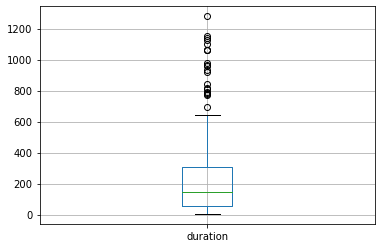

In [76]:
freetext.boxplot(column=['duration'])

In [80]:
freetext[freetext["duration"] > p95freet][["taskId"]].value_counts()

taskId          
AI-1-v2-1-2         7
AI-4-v2-1-3         3
ML-1-1-1            2
Clustering-2-1-1    2
dtype: int64

In [81]:
freetext[freetext["duration"] > p95freet][["pupilId"]].value_counts()

pupilId          
6bBwnX2mwAp2NAwNR    3
dotjrftFetJme4iPH    2
C2BW6tdii778v4RfL    2
Absyuhryq96KZL2Cs    2
kdqG4fXAK64zdrqN8    1
Z9DkQMmtiPiHtteME    1
TLqNCrX4jaYixjtv7    1
Kd6FuRsrq6QvPrkKp    1
7eqvpzMXwFGaYWHou    1
dtype: int64

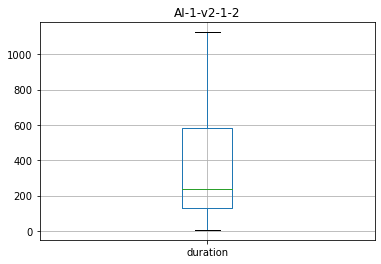

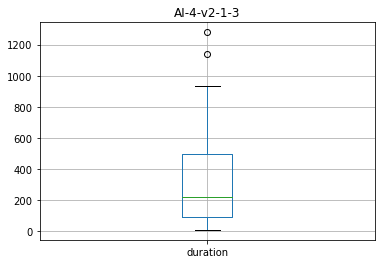

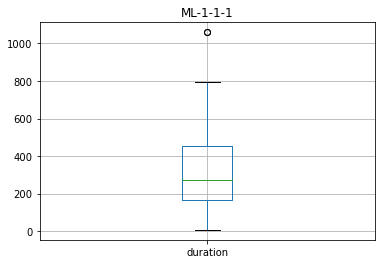

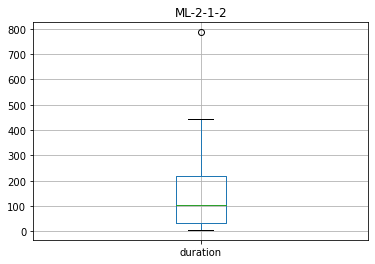

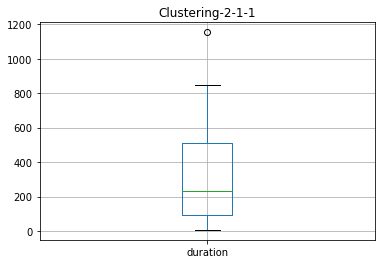

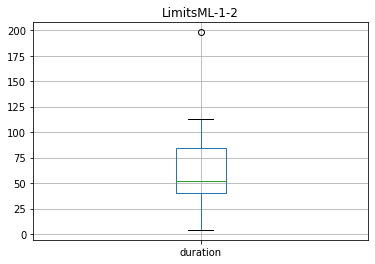

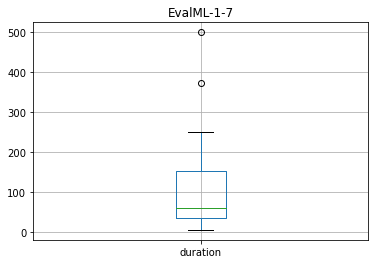

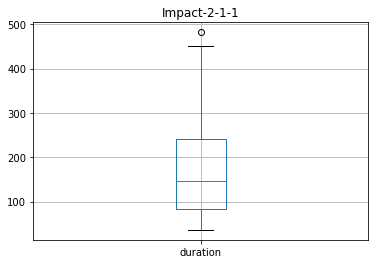

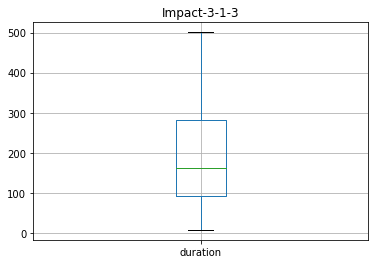

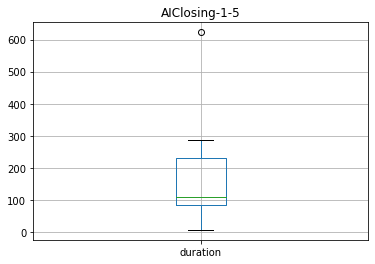

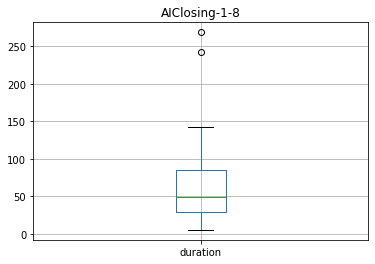

In [92]:
for taskid in freetext["taskId"].unique():
    task_i = freetext[freetext["taskId"] == taskid]
    task_i.boxplot(column=['duration'])
    plt.title(str(taskid))
    plt.show()

### Antworten

In [21]:
print(str(len(freetext)) + " freetext tasks have been submitted")
freetext.head()

268 freetext tasks have been submitted


,pupilId,classId,taskId,taskSeriesId,duration,state,subType,evaluation,falseAttempts,teacherFeedback,question,sampleSolution,number words in answer,rating_content,rating_format,rating_creativity
1,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,AI-1-v2,119,"Künstliche Intelligenz ist ein Algorithmus, de...",freetext,correct,NaN,"Inhaltlich gut, etwas genauer antworten. Muste...",Was ist deiner Meinung nach Künstliche Intelli...,Die Schülerinnen und Schüler (SuS) sollen besc...,18.0,3.0,5.0,4.0
8,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-4-v2-1-3,AI-4-v2,285,"Eine KI ist ein Algorithmus, der auf eine best...",freetext,correct,NaN,,Jetzt weißt du schon mehr über KI. Sag nochmal...,KI-Anwendungen zeichnen sich aus durch intelli...,58.0,5.0,5.0,5.0
11,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,ML-1-1-1,ML-1,203,"Einem Algorithmus, der Hunde auf Bildern erken...",freetext,correct,NaN,,"Kannst du einen Algorithmus schreiben, der Hun...",Die SuS sollen sinnvolle Wenn-Dann-Regeln find...,58.0,4.0,5.0,4.0
16,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,ML-2-1-2,ML-2,219,Beim maschinellen Lernen wird der Algorithmus ...,freetext,correct,NaN,,Weißt du vielleicht schon etwas über das masch...,"Das ist nur eine Abfrage, um über das Vorwisse...",59.0,4.0,5.0,4.0
34,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,509,Für eine Make-Up-Marke würde ich am ehesten de...,freetext,correct,NaN,,Schau dir die Mittelpunkte der Cluster genau a...,Make-Up: Cluster 1 repräsentiert es am besten....,58.0,5.0,4.0,4.0


### Länge der Abgaben

median length of freetext antwort: 20.5
mean length of freetext antwort: 27.813432835820894
std of length of freetext antwort: 23.631078673230604
50% are between 9.0 and 44.25 words long
min number of words: 1.0
max number of words: 119.0
Das sind nur die Längen der akzeptierten Antworten


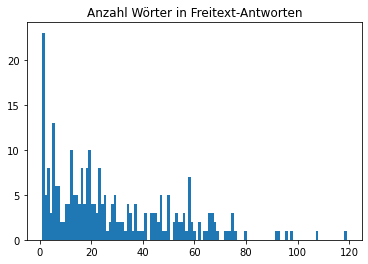

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


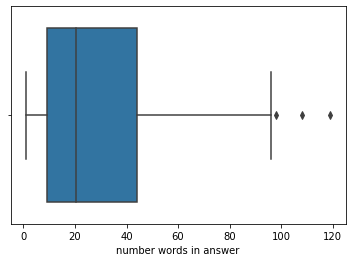

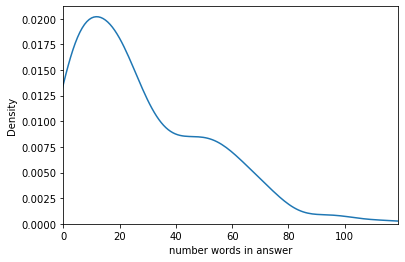

In [22]:
print("median length of freetext antwort: " + str(np.median(freetext["number words in answer"])))
print("mean length of freetext antwort: " + str(np.mean(freetext["number words in answer"])))
print("std of length of freetext antwort: " + str(np.std(freetext["number words in answer"])))

q75, q25 = np.percentile(freetext["number words in answer"], [75 ,25])
print("50% are between " + str(q25) + " and " + str(q75) + " words long")

print("min number of words: " + str(np.min(freetext["number words in answer"])))
print("max number of words: " + str(np.max(freetext["number words in answer"])))
print("Das sind nur die Längen der akzeptierten Antworten")

plt.hist(freetext["number words in answer"], bins=int(np.max(list(freetext["number words in answer"]))))
plt.title("Anzahl Wörter in Freitext-Antworten")
plt.show()

sns.boxplot(freetext["number words in answer"])
plt.show()

kde_length = sns.kdeplot(freetext["number words in answer"])
kde_length.set_xlim(left=0, right=np.max(freetext["number words in answer"]))
#kde_length.set_ylim(bottom=0, top=200);
plt.show()

### Kurze Antworten, die noch akzeptiert wurden

In [23]:
#was sind die kurzen antworten, die akzeptiert wurden?
freetext[(freetext["number words in answer"]<5) & (freetext["taskId"] != "AIClosing-1-8") & (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")][["pupilId", "classId", "taskId", "state", "question"]]

,pupilId,classId,taskId,state,question
869,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Impact-2-1-1,das Gesicht ist unscharf,Was für Probleme könnten durch den Einsatz von...
1050,iHYe2TGnR9zgGZ6zh,GkQSJvPTRWsLnpyR9,AI-4-v2-1-3,ja<br>,Jetzt weißt du schon mehr über KI. Sag nochmal...
1053,iHYe2TGnR9zgGZ6zh,GkQSJvPTRWsLnpyR9,ML-1-1-1,nö<br>,"Kannst du einen Algorithmus schreiben, der Hun..."
1076,iHYe2TGnR9zgGZ6zh,GkQSJvPTRWsLnpyR9,Clustering-2-1-1,.,Schau dir die Mittelpunkte der Cluster genau a...
1116,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,AI-4-v2-1-3,.,Jetzt weißt du schon mehr über KI. Sag nochmal...
1119,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,ML-1-1-1,.,"Kannst du einen Algorithmus schreiben, der Hun..."
1142,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,Clustering-2-1-1,.,Schau dir die Mittelpunkte der Cluster genau a...
1144,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,LimitsML-1-2,.,"Was würde passieren, wenn wir alle Bilder von ..."
1151,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,EvalML-1-7,.,"Beschreib noch einmal in eigenen Worten, was m..."
1155,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,Impact-2-1-1,fehler,Was für Probleme könnten durch den Einsatz von...


Erst noch die Antworten auf Fragen rausnehmen, zu denen SuS noch nichts wissen müssen.
Scheinen wenige SuS zu sein, von denen die Antworten trotzdem akzeptiert wurden.

vllt musste ein account hochgespielt werden

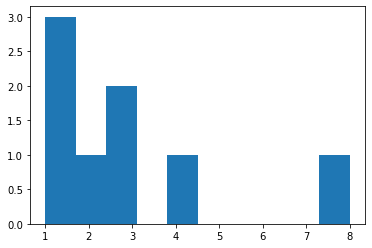

In [24]:
plt.hist(freetext[(freetext["number words in answer"]<5) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")]["pupilId"].value_counts())
plt.show()

In [69]:
# kleiner als IQR25
freetext[(freetext["number words in answer"]<9) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")][["pupilId", "classId", "taskId", "state", "question"]]

,pupilId,classId,taskId,state,question
498,TLqNCrX4jaYixjtv7,qFEyvypMn4sAwLwtc,LimitsML-1-2,Dann erkennt der Algorithmus Seehunde als Hunde.,"Was würde passieren, wenn wir alle Bilder von ..."
746,3hiSwDCiw9HeyHg7f,qFEyvypMn4sAwLwtc,Impact-3-1-3,Es können Fehler von Menschenverhindert werden.,In vielen Bereichen wird der Mensch auch nicht...
803,jRT6yzZ2ip5ab5ZFM,qFEyvypMn4sAwLwtc,Impact-2-1-1,Man könnte damit verbrechen fälschen,Was für Probleme könnten durch den Einsatz von...
856,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Clustering-2-1-1,"<span style=""color: rgb(51, 51, 51);"">⠀</span>",Schau dir die Mittelpunkte der Cluster genau a...
858,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,LimitsML-1-2,"<span style=""color: rgb(51, 51, 51);"">⠀</span>","Was würde passieren, wenn wir alle Bilder von ..."
865,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,EvalML-1-7,"<span style=""color: rgb(51, 51, 51);"">⠀</span>...","Beschreib noch einmal in eigenen Worten, was m..."
869,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Impact-2-1-1,das Gesicht ist unscharf,Was für Probleme könnten durch den Einsatz von...
878,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Impact-3-1-3,sicher werden die Kooperation mit Ki vorteile ...,In vielen Bereichen wird der Mensch auch nicht...
884,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,AIClosing-1-5,"<span style=""color: rgb(51, 51, 51);"">⠀</span>","Du siehst also, dass die Erwartungen der Mensc..."
1050,iHYe2TGnR9zgGZ6zh,GkQSJvPTRWsLnpyR9,AI-4-v2-1-3,ja<br>,Jetzt weißt du schon mehr über KI. Sag nochmal...


<AxesSubplot:>

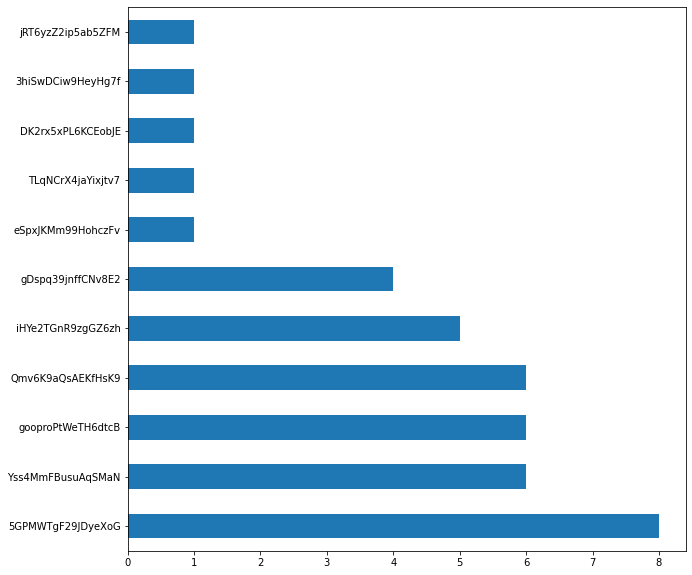

In [26]:
freetext[(freetext["number words in answer"]<9) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")]["pupilId"].value_counts().plot(kind='barh', figsize=(10,10))

In [71]:
# gibt es noch pending antworten?
freetext[(freetext["evaluation"] == "pending")]

,pupilId,classId,taskId,taskSeriesId,duration,state,subType,evaluation,falseAttempts,teacherFeedback,question,sampleSolution,number words in answer,rating_content,rating_format,rating_creativity
172,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,845,Das 1. Cluster repräsentiert am Besten eine Ma...,freetext,pending,NaN,NaN,Schau dir die Mittelpunkte der Cluster genau a...,Make-Up: Cluster 1 repräsentiert es am besten....,96.0,NaN,NaN,NaN
369,Ay6mfswm3SFcQdNJg,qFEyvypMn4sAwLwtc,AIClosing-1-5,AIClosing,223,Die Bedenken die solche Personen äußern sind n...,freetext,pending,NaN,NaN,"Du siehst also, dass die Erwartungen der Mensc...","Hier können die SuS nochmal alles, was sie übe...",48.0,NaN,NaN,NaN
372,Ay6mfswm3SFcQdNJg,qFEyvypMn4sAwLwtc,AIClosing-1-8,AIClosing,243,Ich fand das Design und die Idee dieser Plattf...,freetext,pending,NaN,NaN,Wir wollen diesen Kurs natürlich noch verbesse...,Die SuS können hier noch etwas loswerden. Ist ...,66.0,NaN,NaN,NaN
461,dotjrftFetJme4iPH,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,1154,Die Clusternummer 1 wäre für die Make-Up-Marke...,freetext,pending,NaN,NaN,Schau dir die Mittelpunkte der Cluster genau a...,Make-Up: Cluster 1 repräsentiert es am besten....,76.0,NaN,NaN,NaN
593,MRSj5LqwWj6WSoj4E,qFEyvypMn4sAwLwtc,ML-2-1-2,ML-2,445,Das maschinelles Lernen ist ein Begriff für da...,freetext,pending,NaN,NaN,Weißt du vielleicht schon etwas über das masch...,"Das ist nur eine Abfrage, um über das Vorwisse...",28.0,NaN,NaN,NaN
689,C2BW6tdii778v4RfL,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,189,"Cluster 1 repräsentiert eine Make-Up-Marke, da...",freetext,pending,NaN,NaN,Schau dir die Mittelpunkte der Cluster genau a...,Make-Up: Cluster 1 repräsentiert es am besten....,38.0,NaN,NaN,NaN
935,R8CkqGDeQXZmHxTuk,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,200,"Ich denke die nummer 1, weil mehr mädchen benu...",freetext,pending,NaN,NaN,Schau dir die Mittelpunkte der Cluster genau a...,Make-Up: Cluster 1 repräsentiert es am besten....,35.0,NaN,NaN,NaN
962,j3AkifkKRR3t3NeoT,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,406,"Ich denke, dass Cluster 1 am ehesten eine Make...",freetext,pending,NaN,NaN,Schau dir die Mittelpunkte der Cluster genau a...,Make-Up: Cluster 1 repräsentiert es am besten....,64.0,NaN,NaN,NaN


### Welche Antworten wurden nicht akzeptiert?

In [72]:
# evaluation kann sein: correct, pending, false
freetext[(freetext["evaluation"] == "false")]

# 7 abgaben, die nur einen punkt enthalten (2 davon wieder zu ML-2-1-2, also eig egal!).
# Bei einer Abgabe wurde der Text von Wikipedia kopiert
# eine war ein kurzer Satz
# Abgaben von 4 SuS
# Die Lehrer haben dabei nur an einer Stelle feedback gegeben!

'''
Lehrer geben nur wenig zurück! Und benutzen auch selten Feedback, oder?
'''

'\nLehrer geben nur wenig zurück! Und benutzen auch selten Feedback, oder?\n'

### Wurden Antworten mehrfach zurück gegeben?

In [73]:
for i, task in freetext[freetext["evaluation"] == "false"].iterrows():
    print(len(task["falseAttempts"]))

1
1
1
1
1
1
1
1
1


### Teacher Feedback

In [74]:
freetext["teacherFeedback"].value_counts()

                                                                                                                              255
Tolle Antwort!                                                                                                                  1
Achte auf die Rechtschreibung bzw. Groß und Kleinschreibung. Inhaltlich könnte noch mehr kommen!                                1
Inhaltlich gut, etwas genauer antworten. Mustererkennung ist hier ein wichtiges Aufgabenbeispiel oder maschinelles Lernen.      1
Wikipedia kopiert!                                                                                                              1
K.I. ist erstmal ein Programm, das in einem Computer angewandt wird, damit dieser beispielsweise Muster erkennt.                1
Name: teacherFeedback, dtype: int64

Es wurde nur 5 mal Feedback gegeben:
* K.I. ist erstmal ein Programm, das in einem Computer angewandt wird, damit dieser beispielsweise Muster erkennt.
* Tolle Antwort!    
* Wikipedia kopiert!
* Achte auf die Rechtschreibung bzw. Groß und Kleinschreibung. Inhaltlich könnte noch mehr kommen!
* Inhaltlich gut, etwas genauer antworten. Mustererkennung ist hier ein wichtiges Aufgabenbeispiel oder maschinelles Lernen.

### Ratings

content


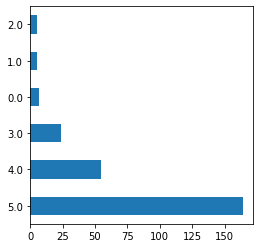

5.0    164
4.0     55
3.0     24
0.0      7
1.0      5
2.0      5
Name: rating_content, dtype: int64
format


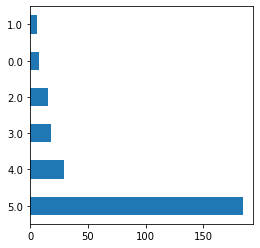

5.0    184
4.0     29
3.0     18
2.0     15
0.0      8
1.0      6
Name: rating_format, dtype: int64
creativity


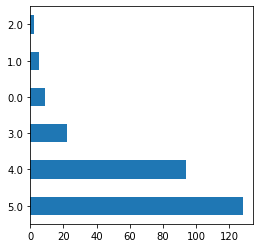

5.0    128
4.0     94
3.0     22
0.0      9
1.0      5
2.0      2
Name: rating_creativity, dtype: int64


In [33]:
#.plot(kind='barh', figsize=(10,10))

print("content")
freetext["rating_content"].value_counts().plot(kind='barh', figsize=(4,4))
plt.show()
print(freetext["rating_content"].value_counts())
print("format")
freetext["rating_format"].value_counts().plot(kind='barh', figsize=(4,4))
plt.show()
print(freetext["rating_format"].value_counts())
print("creativity")
freetext["rating_creativity"].value_counts().plot(kind='barh', figsize=(4,4))
plt.show()
print(freetext["rating_creativity"].value_counts())

IQR75 Content Rating: 5.0
Median Content Rating: 5.0
IQR25 Content Rating: 4.0
Mean Content Rating: 4.334615384615384
Std Content Rating: 1.1366084190365908

IQR75 format Rating: 5.0
Median format Rating: 5.0
IQR25 format Rating: 4.0
Mean format Rating: 4.3307692307692305
Std format Rating: 1.2642325829010392

IQR75 creativity Rating: 5.0
Median creativity Rating: 4.0
IQR25 creativity Rating: 4.0
Mean creativity Rating: 4.196153846153846
Std creativity Rating: 1.1384810289391913



/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


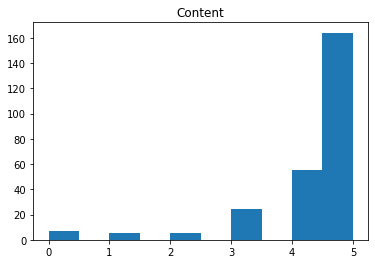

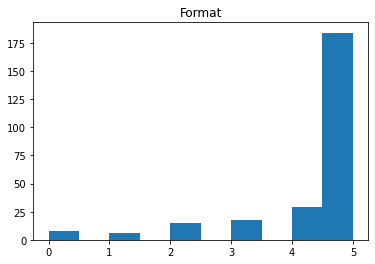

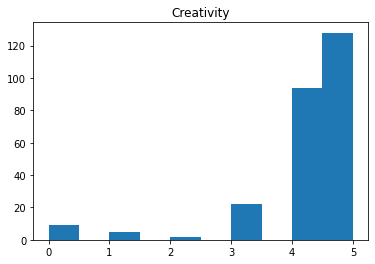

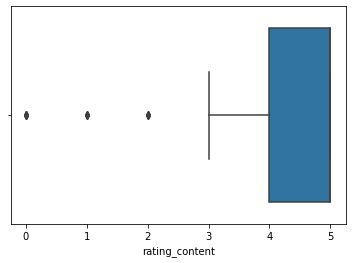

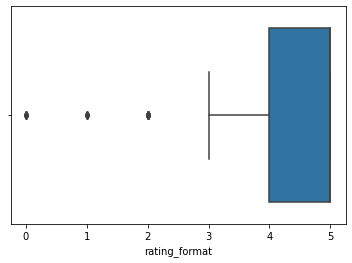

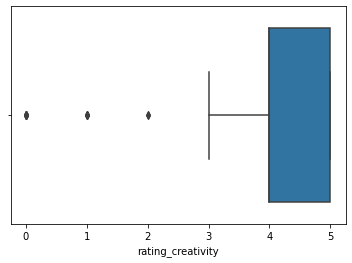

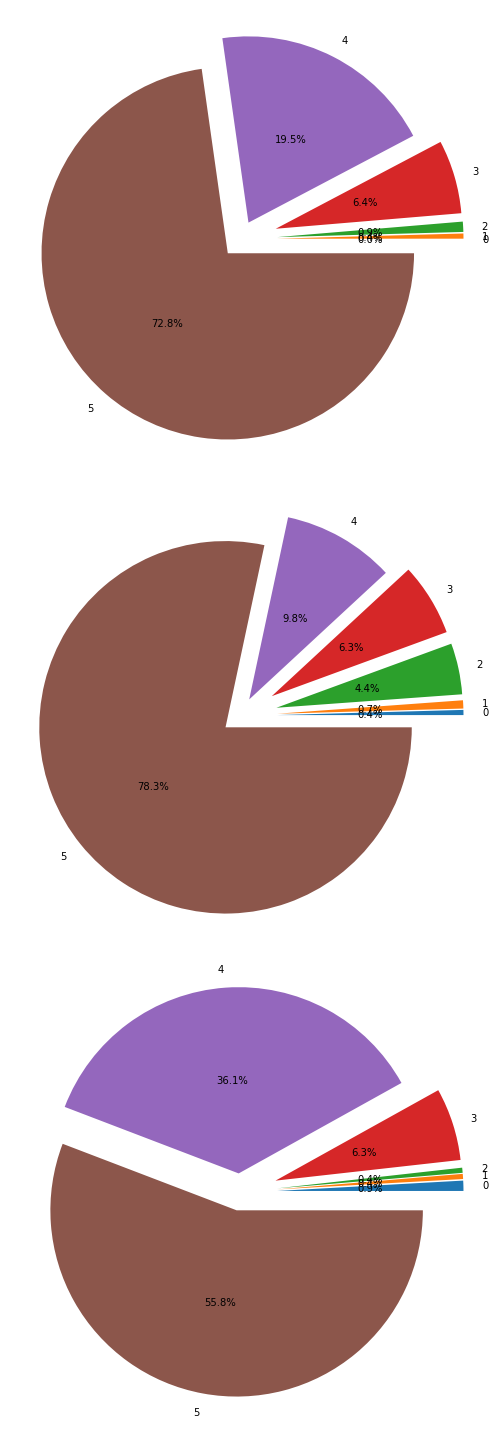

In [76]:
print("IQR75 Content Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_content"], 75)))
print("Median Content Rating: " + str(np.nanmedian(freetext["rating_content"])))
print("IQR25 Content Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_content"], 25)))
print("Mean Content Rating: " + str(np.mean(freetext["rating_content"])))
print("Std Content Rating: " + str(np.std(freetext["rating_content"])))
print("")

print("IQR75 format Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_format"], 75)))
print("Median format Rating: " + str(np.nanmedian(freetext["rating_format"])))
print("IQR25 format Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_format"], 25)))
print("Mean format Rating: " + str(np.mean(freetext["rating_format"])))
print("Std format Rating: " + str(np.std(freetext["rating_format"])))
print("")

print("IQR75 creativity Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_creativity"], 75)))
print("Median creativity Rating: " + str(np.nanmedian(freetext["rating_creativity"])))
print("IQR25 creativity Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_creativity"], 25)))
print("Mean creativity Rating: " + str(np.mean(freetext["rating_creativity"])))
print("Std creativity Rating: " + str(np.std(freetext["rating_creativity"])))
print("")
# TODO: der median muss hier noch falsch sein, der ist 4.0, obwohl es 5 sind


plt.hist(freetext["rating_content"])
plt.title("Content")
plt.show()
plt.hist(freetext["rating_format"])
plt.title("Format")
plt.show()
plt.hist(freetext["rating_creativity"])
plt.title("Creativity")
plt.show()


#boxplots bringen eig nichts!
sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_content"])
plt.show()
sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_format"])
plt.show()
sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_creativity"])
plt.show()


# Pie charts
content_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_content")["rating_content"].sum()
format_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_format")["rating_content"].sum()
creativity_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_creativity")["rating_content"].sum()
labels = ["0", "1", "2", "3", "4", "5"]
#content_labels = freetext[freetext["evaluation"] != "pending"]["rating_content"].unique()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[10,20])

ax1.pie(x=content_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
ax2.pie(x=format_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
ax3.pie(x=creativity_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
plt.tight_layout()
plt.show()

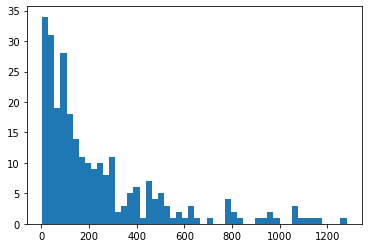

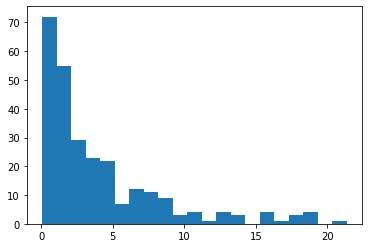

In [77]:
# durations
plt.hist(freetext["duration"], bins=50)
plt.show()

plt.hist(freetext["duration"]/60, bins=int(np.max(freetext["duration"])/60))
plt.show()

In [78]:
# Welche Antworten haben besonders lange gebraucht?
freetext[freetext["duration"] > 700][["pupilId", "classId", "taskId", "duration", "state", "number words in answer"]]

,pupilId,classId,taskId,duration,state,number words in answer
133,Kd6FuRsrq6QvPrkKp,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,979,"Künstliche Intelligenz heißt, dass ein Roboter...",55.0
139,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,968,"Künstliche Intelligenz bedeutet, dass ein Robo...",58.0
146,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc,AI-4-v2-1-3,932,KI (Künstliche Intelligenz) unterscheidet man ...,108.0
172,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc,Clustering-2-1-1,845,Das 1. Cluster repräsentiert am Besten eine Ma...,96.0
374,hn2oJ5p2CwPfG44wx,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,818,Bei Künstlichen Intelligenzen wird durch das D...,34.0
389,hn2oJ5p2CwPfG44wx,qFEyvypMn4sAwLwtc,ML-2-1-2,786,"Maschinelles Lernen wird auch ""deep learning"" ...",60.0
407,hn2oJ5p2CwPfG44wx,qFEyvypMn4sAwLwtc,Clustering-2-1-1,770,"Das Beauty, Vlogs repräsentiert am ehesten ein...",75.0
428,dotjrftFetJme4iPH,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,1063,"Meiner Meinung nach, künstliche Intelligenz is...",34.0
461,dotjrftFetJme4iPH,qFEyvypMn4sAwLwtc,Clustering-2-1-1,1154,Die Clusternummer 1 wäre für die Make-Up-Marke...,76.0
463,TLqNCrX4jaYixjtv7,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,1125,Künstliche Intelligenz ist wenn Programme durc...,66.0


In [79]:
# Bei welchen Aufgaben sind die antworten besonders lang?
freetext[freetext["duration"] > 700]["taskId"].value_counts()

AI-1-v2-1-2         9
AI-4-v2-1-3         4
Clustering-2-1-1    3
ML-1-1-1            3
ML-2-1-2            1
Name: taskId, dtype: int64

In [80]:
# sind das die schüler, die dann auch nciht weit gekommen sind?
slow_freetext_pupils = freetext[freetext["duration"] > 700]["pupilId"].unique()

In [81]:
#for pupilId in freetext[freetext["duration"] > 700]["pupilId"].unique():
#    print(pupil_performance_df[pupil_performance_df["pupilId"] == pupilId])

pupil_performance_df[pupil_performance_df["pupilId"].isin(slow_freetext_pupils)]

'''
manche nicht weit gekommen
die anderen sind eher langsame arbeiter, glaube ich
'''


'\nmanche nicht weit gekommen\ndie anderen sind eher langsame arbeiter, glaube ich\n'

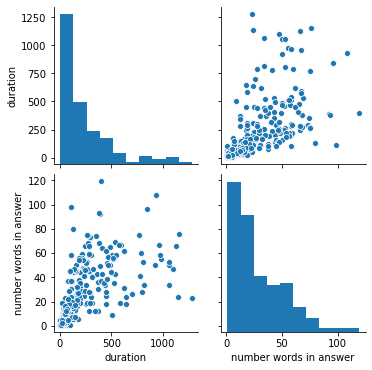

In [82]:
sns.pairplot(freetext[["duration", 'number words in answer']])

In [83]:
# correlation mit kategorischen daten für ["duration", 'number words in answer', "rating_content", 'rating_format', 'rating_creativity']
rho1, p1 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['duration'], freetext[freetext["evaluation"] != "pending"]['rating_content'])
rho2, p2 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['duration'], freetext[freetext["evaluation"] != "pending"]['rating_format'])
rho3, p3 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['duration'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])
rho4, p4 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['number words in answer'], freetext[freetext["evaluation"] != "pending"]['rating_content'])
rho5, p5 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['number words in answer'], freetext[freetext["evaluation"] != "pending"]['rating_format'])
rho6, p6 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['number words in answer'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])

print("spearman coeff duration+content: " + str(rho1) + " p-value: " + str(p1))
print("spearman coeff duration+format: " + str(rho2) + " p-value: " + str(p2))
print("spearman coeff duration+creativity: " + str(rho3) + " p-value: " + str(p3))
print("spearman coeff answerlength+content: " + str(rho4) + " p-value: " + str(p4))
print("spearman coeff answerlength+format: " + str(rho5) + " p-value: " + str(p5))
print("spearman coeff answerlength+creativity: " + str(rho6) + " p-value: " + str(p6))

#unter 0.05 ist signifikant
# für coefficients nochmal nachschauen, ab wann wie stark

spearman coeff duration+content: -0.05774405609854682 p-value: 0.3537279037095544
spearman coeff duration+format: 0.07490480132060759 p-value: 0.22871495516461926
spearman coeff duration+creativity: -0.09021440397121602 p-value: 0.14688738819038427
spearman coeff answerlength+content: 0.006235424482870653 p-value: 0.9202969154973344
spearman coeff answerlength+format: 0.10091941779472066 p-value: 0.10446472334223415
spearman coeff answerlength+creativity: -0.07882070157663901 p-value: 0.20522913355889036


In [84]:
rho7, p7 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['rating_content'], freetext[freetext["evaluation"] != "pending"]['rating_format'])
rho8, p8 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['rating_content'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])
rho9, p9 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['rating_format'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])

print("spearman coeff content+format: " + str(rho7) + " p-value: " + str(p7))
print("spearman coeff content+creat: " + str(rho8) + " p-value: " + str(p8))
print("spearman coeff format+creat: " + str(rho9) + " p-value: " + str(p9))

spearman coeff content+format: 0.6898912018686403 p-value: 4.5102844236676357e-38
spearman coeff content+creat: 0.6847138328329063 p-value: 2.5890141237812365e-37
spearman coeff format+creat: 0.5501659435236037 p-value: 5.675264570471399e-22


In [85]:
freetext[["duration", 'number words in answer', "rating_content", 'rating_format', 'rating_creativity']].corr()

,number words in answer,rating_content,rating_format,rating_creativity
number words in answer,1.000000,0.145638,0.186290,0.115849
rating_content,0.145638,1.000000,0.790204,0.808266
rating_format,0.186290,0.790204,1.000000,0.740557
rating_creativity,0.115849,0.808266,0.740557,1.000000


<AxesSubplot:>

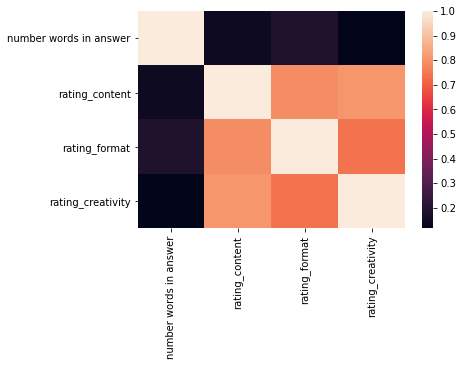

In [86]:
sns.heatmap(freetext[["duration", 'number words in answer', "rating_content", 'rating_format', 'rating_creativity']].corr())

# Durations

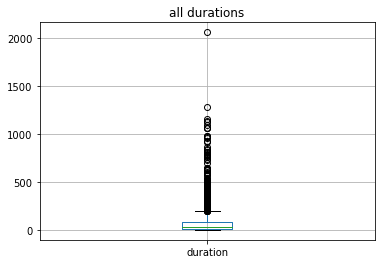

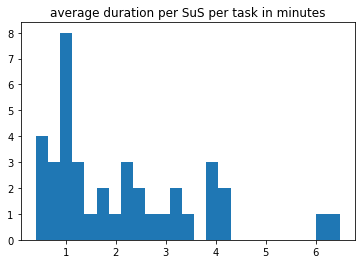

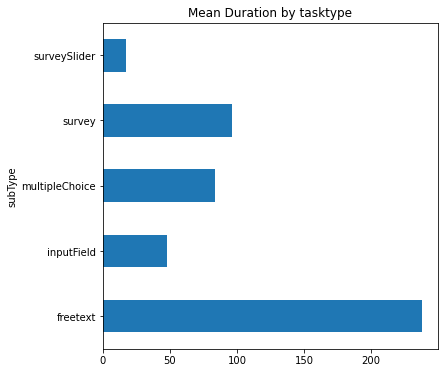

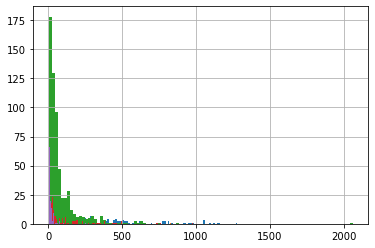

In [248]:
# All durations
df.boxplot(column=['duration'])
plt.title("all durations")
plt.show()
# Es gibt ein paar sehr krasse ausreißen! maximum sind über 30 minuten für eine MC. Kann inhaltlich nicht sein --> vermutlich idle time

# Per Student
plt.hist(pupil_performance_df["average duration per task in minutes"], bins=int(np.max(pupil_performance_df["average duration per task in minutes"])/0.25))
plt.title("average duration per SuS per task in minutes")
plt.show()

# Per Subtype
df.groupby("subType")["duration"].mean().plot(kind='barh', figsize=(6,6))
plt.title("Mean Duration by tasktype")
plt.show()

df.groupby("subType")["duration"].hist(bins=100)
plt.show()
# TODO: vllt als 3d histogram? https://matplotlib.org/stable/gallery/mplot3d/hist3d.html

#for subType in df.groupby("subType"):
    #print(subType["duration"])
    #subType["duration"].hist()
    #plt.show()
    
#groupby("taskId")
#groupby("pupilId")

# Hints taken

In [10]:
df[df["hints"] == df["hints"]].head()

,pupilId,classId,taskId,taskSeriesId,duration,state,subType,evaluation,falseAttempts,hintsTaken,...,answers,minLabel,maxLabel,hints,sampleSolution,number words in answer,numberFalseAttempts,rating_content,rating_format,rating_creativity
3,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-2-v2-1-1,AI-2-v2,94,"[True, True, False, True]",multipleChoice,correct,NaN,NaN,...,[{'de': 'Der Newsfeed eines Social Network nut...,NaN,NaN,"Denk an die Beispiele, die wir uns am Anfang a...","[True, True, False, True]",NaN,NaN,NaN,NaN,NaN
4,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-3-v2-1-1,AI-3-v2,43,"[False, False, False]",multipleChoice,correct,NaN,NaN,...,"[{'de': 'Die Anwendung, die den Facebook-Feed ...",NaN,NaN,"Kann überhaupt eine dieser Anwendungen etwas, ...","[False, False, False]",NaN,NaN,NaN,NaN,NaN
5,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-3-v2-1-2,AI-3-v2,42,"[True, False, True]",multipleChoice,correct,NaN,NaN,...,[{'de': 'Empfehlungssysteme gehören zur spezif...,NaN,NaN,Welche Anwendung kann nur eine Sache gut und w...,"[True, False, True]",NaN,NaN,NaN,NaN,NaN
6,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-4-v2-1-1,AI-4-v2,61,"[False, True, True, False]",multipleChoice,correct,NaN,NaN,...,[{'de': 'KI-Anwendungen sind allgemein intelli...,NaN,NaN,Denk an den Unterschied zwischen intelligentem...,"[False, True, True, False]",NaN,NaN,NaN,NaN,NaN
7,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-4-v2-1-2,AI-4-v2,118,"[True, True, False, True, True, False, True]",multipleChoice,correct,NaN,NaN,...,[{'de': 'KI-Anwendungen treffen eigenständige ...,NaN,NaN,Lies die Antworten ganz genau.,"[True, True, False, True, True, False, True]",NaN,NaN,NaN,NaN,NaN


In [11]:
nr_no_hints = 0
nr_one_hint = 0
nr_two_hints = 0
nr_tasks_with_hints = len(df[df["hints"] == df["hints"]])

for index, task in df[df["hints"] == df["hints"]].iterrows():
    if task["hintsTaken"] ==1:
        nr_one_hint +=1
    elif task["hintsTaken"] ==2:
        nr_two_hints +=1
    else:
        nr_no_hints +=1

print("von " + str(nr_tasks_with_hints) + " gemachten aufgaben wurde:")
print(str(nr_no_hints) + " kein hint angefragt. In Prozent: " + str((nr_no_hints/nr_tasks_with_hints)*100))
print(str(nr_one_hint) + " kein hint angefragt. In Prozent: " + str((nr_one_hint/nr_tasks_with_hints)*100))
print(str(nr_two_hints) + " kein hint angefragt. In Prozent: " + str((nr_two_hints/nr_tasks_with_hints)*100))


von 448 gemachten aufgaben wurde:
180 kein hint angefragt. In Prozent: 40.17857142857143
257 kein hint angefragt. In Prozent: 57.36607142857143
11 kein hint angefragt. In Prozent: 2.455357142857143


Wenn es hints gibt:
* in 40% der fälle nehmen die SuS keinen hint
* in 57.5% nehmen sie einen hint
* in 2.5% nehmen sie zwei hints


In [12]:
# nach aufgabentyp?!

nr_no_hints_mc = 0
nr_one_hint_mc = 0
nr_two_hints_mc = 0
nr_tasks_with_hints_mc = len(df[(df["hints"] == df["hints"]) & (df["subType"] == "multipleChoice")])

for index, task in df[(df["hints"] == df["hints"]) & (df["subType"] == "multipleChoice")].iterrows():
    if task["hintsTaken"] ==1:
        nr_one_hint_mc +=1
    elif task["hintsTaken"] ==2:
        nr_two_hints_mc +=1
    else:
        nr_no_hints_mc +=1

print("von " + str(nr_tasks_with_hints_mc) + " gemachten MC aufgaben wurde:")
print(str(nr_no_hints_mc) + " kein hint angefragt. In Prozent: " + str((nr_no_hints_mc/nr_tasks_with_hints_mc)*100))
print(str(nr_one_hint_mc) + " ein hint angefragt. In Prozent: " + str((nr_one_hint_mc/nr_tasks_with_hints_mc)*100))
print(str(nr_two_hints_mc) + " kein hint angefragt. In Prozent: " + str((nr_two_hints_mc/nr_tasks_with_hints_mc)*100))


von 398 gemachten MC aufgaben wurde:
156 kein hint angefragt. In Prozent: 39.19597989949749
231 ein hint angefragt. In Prozent: 58.040201005025125
11 kein hint angefragt. In Prozent: 2.763819095477387


#### werden hints direkt genommen oder erst versucht, die aufgaben zu lösen?

In [13]:
hints_directly_taken = 0
hints_not_directly_taken = 0

for index, task in df[df["hints"] == df["hints"]].iterrows():
    #hints taken = 1 und len(falseattempts) = 0
    # hints taken >=1 und false attempts >= 0
    
    if((task["hintsTaken"] == task["hintsTaken"]) & (task["falseAttempts"]!=task["falseAttempts"])):
        hints_directly_taken += 1
    elif((task["hintsTaken"] == task["hintsTaken"]) & (task["falseAttempts"]==task["falseAttempts"])):
        hints_not_directly_taken +=1
            
print("in so vielen fällen wurde ein hint angefragt, ohne es vorher versucht zu haben: " + str(hints_directly_taken))
print("in so vielen fällen wurde entweder der hint erst nach einem falschen versuch angefragt oder direkt angefragt ohne zu helfen: " + str(hints_not_directly_taken))

in so vielen fällen wurde ein hint angefragt, ohne es vorher versucht zu haben: 20
in so vielen fällen wurde entweder der hint erst nach einem falschen versuch angefragt oder direkt angefragt ohne zu helfen: 248


In [15]:
# Das sind die Fälle, bei denen direkt ein hint angefragt wurde:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]!=df["falseAttempts"])].head() #ohne .head() zeigt er alle

,pupilId,classId,taskId,taskSeriesId,duration,state,subType,evaluation,falseAttempts,hintsTaken,...,answers,minLabel,maxLabel,hints,sampleSolution,number words in answer,numberFalseAttempts,rating_content,rating_format,rating_creativity
33,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,Classification-2-1-8,Classification-2,49,"[True, False, True]",multipleChoice,correct,NaN,1,...,"[{'de': 'Ein Algorithmus, der dir basierend au...",NaN,NaN,"Denk daran, dass wir beim überwachten Lernen L...","[True, False, True]",NaN,NaN,NaN,NaN,NaN
135,Kd6FuRsrq6QvPrkKp,qFEyvypMn4sAwLwtc,AI-2-v2-1-1,AI-2-v2,379,"[True, True, False, True]",multipleChoice,correct,NaN,1,...,[{'de': 'Der Newsfeed eines Social Network nut...,NaN,NaN,"Denk an die Beispiele, die wir uns am Anfang a...","[True, True, False, True]",NaN,NaN,NaN,NaN,NaN
136,Kd6FuRsrq6QvPrkKp,qFEyvypMn4sAwLwtc,AI-3-v2-1-1,AI-3-v2,256,"[False, False, False]",multipleChoice,correct,NaN,1,...,"[{'de': 'Die Anwendung, die den Facebook-Feed ...",NaN,NaN,"Kann überhaupt eine dieser Anwendungen etwas, ...","[False, False, False]",NaN,NaN,NaN,NaN,NaN
142,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc,AI-3-v2-1-1,AI-3-v2,223,"[False, False, False]",multipleChoice,correct,NaN,1,...,"[{'de': 'Die Anwendung, die den Facebook-Feed ...",NaN,NaN,"Kann überhaupt eine dieser Anwendungen etwas, ...","[False, False, False]",NaN,NaN,NaN,NaN,NaN
144,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc,AI-4-v2-1-1,AI-4-v2,254,"[False, True, True, False]",multipleChoice,correct,NaN,1,...,[{'de': 'KI-Anwendungen sind allgemein intelli...,NaN,NaN,Denk an den Unterschied zwischen intelligentem...,"[False, True, True, False]",NaN,NaN,NaN,NaN,NaN


#### Gibt es eine besondere Häufung der hints?
#### bei Schülern?

<AxesSubplot:>

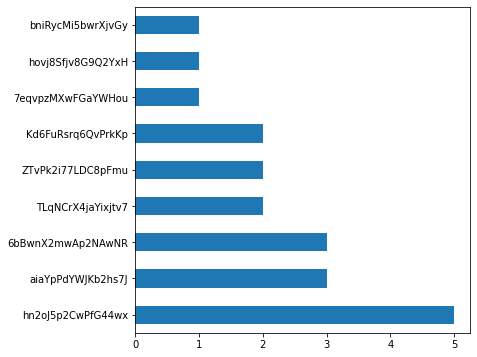

In [16]:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]!=df["falseAttempts"])]["pupilId"].value_counts().plot(kind='barh', figsize=(6,6))

#### Bei Aufgaben?

<AxesSubplot:>

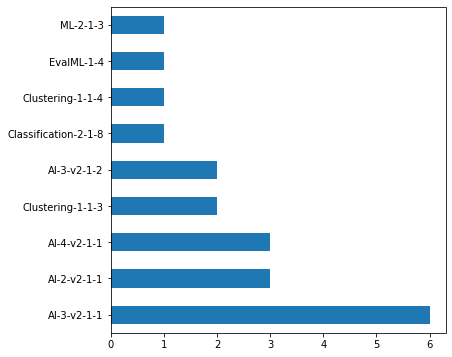

In [17]:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]!=df["falseAttempts"])]["taskId"].value_counts().plot(kind='barh', figsize=(6,6))

In [14]:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]!=df["falseAttempts"])][["taskId", "pupilId"]].value_counts()

taskId                pupilId          
ML-2-1-3              aiaYpPdYWJKb2hs7J    1
EvalML-1-4            hn2oJ5p2CwPfG44wx    1
AI-2-v2-1-1           Kd6FuRsrq6QvPrkKp    1
                      TLqNCrX4jaYixjtv7    1
AI-3-v2-1-1           6bBwnX2mwAp2NAwNR    1
                      Kd6FuRsrq6QvPrkKp    1
                      TLqNCrX4jaYixjtv7    1
                      aiaYpPdYWJKb2hs7J    1
                      hn2oJ5p2CwPfG44wx    1
                      hovj8Sfjv8G9Q2YxH    1
AI-3-v2-1-2           aiaYpPdYWJKb2hs7J    1
                      hn2oJ5p2CwPfG44wx    1
AI-4-v2-1-1           6bBwnX2mwAp2NAwNR    1
                      ZTvPk2i77LDC8pFmu    1
                      hn2oJ5p2CwPfG44wx    1
Classification-2-1-8  bniRycMi5bwrXjvGy    1
Clustering-1-1-3      6bBwnX2mwAp2NAwNR    1
                      ZTvPk2i77LDC8pFmu    1
Clustering-1-1-4      hn2oJ5p2CwPfG44wx    1
AI-2-v2-1-1           7eqvpzMXwFGaYWHou    1
dtype: int64

In [15]:
#df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]!=df["falseAttempts"])][["pupilId", "taskId", "question"]].value_counts()

Es scheint eine leichte Häufung zu geben, sowohl bei SuS, als auch bei Aufgaben

Aufgaben:
* va AI-3-v2-1-1

#### Helfen hints? --> gibt es viele fälle, in denen hints angefragt wurden, die aufgabe aber trotzdem nicht erledigt wurde?

In [19]:
hints_helped = 0
hints_not_helped = 0


for index, task in df[df["hints"] == df["hints"]].iterrows():
    # hints taken, false attempts, aber eval richtig
    if((task["hintsTaken"] == task["hintsTaken"]) & (task["falseAttempts"]==task["falseAttempts"]) & (task["evaluation"] == "correct")):
        hints_helped += 1
    # vs hints taken, false attempts, aber eval nicht correct
    elif((task["hintsTaken"] == task["hintsTaken"]) & (task["falseAttempts"]==task["falseAttempts"])& (task["evaluation"] == "false")):
        hints_not_helped +=1
            
print("nr cases where hints where taken and eval is correct --> they helped: " + str(hints_helped))
print("nr cases where hints where taken and eval is false --> didnt help: " + str(hints_not_helped))
print("percent of cases where hints helped: " + str(hints_helped/(hints_not_helped+hints_helped)))

nr cases where hints where taken and eval is correct --> they helped: 87
nr cases where hints where taken and eval is false --> didnt help: 161
percent of cases where hints helped: 0.35080645161290325


#### --> Our hints dont seem to help
#### Gibt es ballungen, wo sie besonders wenig geholfen haben?

In [20]:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]==df["falseAttempts"])& (df["evaluation"] == "false")].head()

,pupilId,classId,taskId,taskSeriesId,duration,state,subType,evaluation,falseAttempts,hintsTaken,...,answers,minLabel,maxLabel,hints,sampleSolution,number words in answer,numberFalseAttempts,rating_content,rating_format,rating_creativity
156,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc,ML-3-1-1,ML-3,293,"[True, True, True, False]",multipleChoice,false,"[[True, False, True, False]]",1,...,[{'de': 'Maschinelles Lernen ist ein Teilberei...,NaN,NaN,Lies die Antworten ganz genau durch.,"[True, True, True, False]",NaN,NaN,NaN,NaN,NaN
180,ZTvPk2i77LDC8pFmu,qFEyvypMn4sAwLwtc,AI-4-v2-1-2,AI-4-v2,234,"[True, True, False, True, True, False, True]",multipleChoice,false,"[[True, False, False, False, True, False, True...",1,...,[{'de': 'KI-Anwendungen treffen eigenständige ...,NaN,NaN,Lies die Antworten ganz genau.,"[True, True, False, True, True, False, True]",NaN,NaN,NaN,NaN,NaN
257,rsATbrReo6odn6oXD,qFEyvypMn4sAwLwtc,ML-3-1-1,ML-3,422,"[True, True, True, False]",multipleChoice,false,"[[False, False, False, False], [False, False, ...",1,...,[{'de': 'Maschinelles Lernen ist ein Teilberei...,NaN,NaN,Lies die Antworten ganz genau durch.,"[True, True, True, False]",NaN,NaN,NaN,NaN,NaN
271,rsATbrReo6odn6oXD,qFEyvypMn4sAwLwtc,Classification-2-1-7,Classification-2,106,"[False, False, True, False, False]",multipleChoice,false,"[[False, False, False, False, True], [False, F...",1,...,"[{'de': 'James Bond', 'en-US': 'James Bond'}, ...",NaN,NaN,Welchen Film hat Mahmud zuletzt geschaut?,"[False, False, True, False, False]",NaN,NaN,NaN,NaN,NaN
272,rsATbrReo6odn6oXD,qFEyvypMn4sAwLwtc,Classification-2-1-8,Classification-2,56,"[True, False, True]",multipleChoice,false,"[[True, True, True], [True, True, False]]",1,...,"[{'de': 'Ein Algorithmus, der dir basierend au...",NaN,NaN,"Denk daran, dass wir beim überwachten Lernen L...","[True, False, True]",NaN,NaN,NaN,NaN,NaN


In [21]:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]==df["falseAttempts"])& (df["evaluation"] == "false")][["taskId", "subType"]].value_counts()

taskId                subType       
AI-4-v2-1-2           multipleChoice    18
AI-3-v2-1-1           multipleChoice    16
Impact-4-1-1          multipleChoice    13
ML-3-1-1              multipleChoice    12
AI-3-v2-1-2           multipleChoice    12
AI-2-v2-1-1           multipleChoice    12
Clustering-1-1-1      multipleChoice     9
AI-4-v2-1-1           multipleChoice     9
Clustering-1-1-3      inputField         8
ML-2-1-3              multipleChoice     8
Clustering-1-1-4      inputField         8
Impact-3-1-2          multipleChoice     8
Classification-2-1-8  multipleChoice     8
Classification-2-1-7  multipleChoice     7
Classification-1-1-1  multipleChoice     6
EvalML-1-4            multipleChoice     4
Classification-2-1-6  multipleChoice     3
dtype: int64

Hints besonders schlecht bei:
* AI-4-v2-1-2             18
* AI-3-v2-1-1             16
* Impact-4-1-1            13
* AI-2-v2-1-1             12
* AI-3-v2-1-2             12
* ML-3-1-1                12

#### Bei MC (meiste hints) werden die Antworten bei der zweiten falschen Abgabe besser!
Die hints scheinen also zu helfen, oder ein genaueres Nachlesen scheint gut zu sein

## Hilfeanfragen

In [242]:
for classroom in classrooms:
    if(classroom["helpRequests"]):
        print(classroom["helpRequests"][0]["taskSeriesId"])
        print(classroom["helpRequests"][0]["question"])
        for message in classroom["helpRequests"][0]["chat"]["messages"]:
            if(message["message"] != "joinedChat"):
                print(message["message"])
        print("")

For-1
fsdfdgfdgdgfh

If-3
wir haben irgendwo einen Fehler gemacht aber wir leider es nicht wissen...:(?

Algorithmic-1-v2
veVDA`WSfasfasfaff
penis
gigh

AlgorithmicAlltag-2-v2
Das ist zu kompliziert...
tut mir Leid

Algorithmic-1-v2
Hilfe wie geht das?
hey

Algorithmic-2-v2
Keine Ahnung

Algorithmic-3-v2
Wie geht das hier?

LoopsVergleich-2-v2
hilfe ich komme nicht weiter kann mir jemnd helfen?



* In den meisten Klassen wurde noch nie Hilfe gestellt. Gibt nur 8 Hilfeanfragen überhaupt. Alle sind im Algorithmen-Paket
  * zwei haben gibberish als Frage
  * zwei sind keine fragen udn stellen nur fest, dass es nicht geht
  * 4 Fragen um Hilfe (Niemand fragt um verständnis)
* gibt nur 4 antworten (gibberish, penis, hey, tut mir Leid)

# Revisions

In [247]:
nr_accepted_revisions = 0
nr_unaccepted_revisions = 0

for pupil in pupils:
    #print(pupil.keys())
    if("revisions" in pupil.keys()):
        if (pupil["revisions"]):
            if (pupil["revisions"][0]["accepted"]):
                nr_accepted_revisions +=1
            else:
                nr_unaccepted_revisions += 1

print("nr accepted: " + str(nr_accepted_revisions) + " nr unaccepted: " + str(nr_unaccepted_revisions))

nr accepted: 33 nr unaccepted: 470


Weißt nicht, wie revision gerade eingestellt sind, aber die SuS scheinen sie nicht anzunehmen

# Chat

In [258]:
print(chat_df["sentBy"].value_counts())
print()
# Wie nutzen Lehrer der Chat?
print(chat_df[chat_df["sentBy"] != "auto"]["message"])
# Hier sind auch noch unsere Nachrichten drinne, glaube ich?! Und lehrer nachrichten!

# Nutzen SuS den Chat?
print("\nmessages by SuS")
chat_df[np.where(chat_df["sentBy"].isin(set(df["pupilId"])), True, False)]


auto                 266
sWm4d454H7CgZk7xP     26
eFfWFEEHYrGie6TWY     15
vPkj9gw4uYahqDz2b      2
wxkuvgoD5tbZyvyFy      1
FZTuuyvpvJBGhnCgk      1
GHpnNu3Yss7Qz8Tm4      1
Name: sentBy, dtype: int64

0      Hier könnt ihr euch individuell aber auch mir ...
12     Hier könnt ihr euch individuell aber auch mir ...
24     Hier könnt ihr euch individuell aber auch mir ...
26     Hier könnt ihr euch individuell aber auch mir ...
31     Hier könnt ihr euch individuell aber auch mir ...
43     Hier könnt ihr euch individuell aber auch mir ...
48                                                    HI
49     Hier könnt ihr euch individuell aber auch mir ...
50                                             ok, danke
55     Hier könnt ihr euch individuell aber auch mir ...
65     Hier könnt ihr euch individuell aber auch mir ...
74     Hier könnt ihr euch individuell aber auch mir ...
79     Hier könnt ihr euch individuell aber auch mir ...
87     Hier könnt ihr euch individuell aber auch mir ...

,0,sentBy,message,request


# Verwendete Methoden

## Wilcoxon signed-rank test

the signed-rank test is designed for paired comparisons on non-normal data. 

The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.

To compute an effect size for the signed-rank test, one can use the rank-biserial correlation. If the test statistic W is reported, the rank correlation r is equal to the test statistic W divided by the total rank sum S, or r = W/S. [8] Using the above example, the test statistic is W = 9. The sample size of 9 has a total rank sum of S = (1 + 2 + 3 + 4 + 5 + 6 + 7 + 8 + 9) = 45. Hence, the rank correlation is 9/45, so r = 0.20. 

## Mann-Whitney-U test

The preferred non-parametric method for unpaired samples is the Mann-Whitney non parametric hypothesis test or Mann-Whitney test (it is also called as Wilcoxon Rank Sum Test or the Mann Whitney Wilcoxon Test) and thus the non parametric solution to evaluating two independent datasets comparable to the Student’s T test.

Mann-Whitney test is a non-parametric test that is to compare two sample means that may come from the same population, and used to test whether two sample means are equal or not. 

Null Hypotheses H0: Two populations are equal

https://sixsigmastudyguide.com/mann-whitney-non-parametric-hypothesis-test/

## paired T-Test

In [73]:
# dann trotzdem t-test machen, weil ich genügend SuS haben werde
(t_stat0_05, p0_05) = stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["AI-4-v2-1-4"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["AI-1-v2-1-1"])
(t_stat05_1, p05_1) = stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["EvalML-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["AI-4-v2-1-4"])
(t_stat0_1, p0_1) = stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["EvalML-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["AI-1-v2-1-1"])

print(t_stat0_05, p0_05)
print(t_stat05_1, p05_1)
print(t_stat0_1, p0_1)

2.9525670234171146 0.009881733755346747
-2.457500582414377 0.026645707133842324
0.46741342885340026 0.6469221833851113


Ergebnis:
* T0-05: Sicher, dass gelernt wurde
* T05-1: Sicher, dass nichts gelernt wurde
* t0-1: keine SIgnifikanz

#### t- Manuell und logisch

In [21]:
# 1. zweiten Wert vom ersten subtrahieren, um gepaarte Differenzen zu erhalten --> schon gemacht

# 2. mittelwert und std für differenzen verechnen
mean0_05 = np.mean(differences_0_05)
std0_05 = np.std(differences_0_05)
mean05_1 = np.mean(differences_05_1)
std05_1 = np.std(differences_05_1)
mean0_1 = np.mean(differences_0_1)
std0_1 = np.std(differences_0_1)

# 3. Standardfehler berechnen
ste0_05 = std0_05/np.sqrt(len(differences_0_05))
ste05_1 = std05_1/np.sqrt(len(differences_0_05))
ste0_1 = std0_1/np.sqrt(len(differences_0_1))

# 4. Den Mittelwert der gepaarten Differenzen durch den Standardfehler teilen:
prüfgröße0_05 = mean0_05/ste0_05
prüfgröße05_1 = mean05_1/ste05_1
prüfgröße0_1 = mean0_1/ste0_1
print(prüfgröße0_05)
print(prüfgröße05_1)
print(prüfgröße0_1)

2.0596699514747843
-3.589409344187835
0.48274251353144654


wir schauen, welche signifikanz wir wollen (95%) und vergleichen den nötigen wert mit unserem:
--> t-value bei 95% 1.753. Messung-0-05 größer, 05-1 negativ aber größer und 0-1 kleiner

testen, ob jeweils beide ergebnisse von der gleichen verteilung kommen, mit nullhypothese: kommt von der gleichen
* T0 zu T0.5  --> sicher, dass sie gelernt haben
* T0.5 zu T1 --> sicher, dass sie weniger wissen, als vorher
* T0 zu T1 --> nicht sicher, dass sie was gelernt haben

bedenken:
* erste einschätzung muss nicht richtig sein. wobei eine klasse schon etwas gemacht zu haben scheint
* trotzdem hat erster teil einen effekt. der zweite zu ML hat keinen mehr. außerdem primacy und recency bedenken!

## Korrelation selbsteinschätzungen und Ratings

Ordinale Werte bei Ratings --> use Spearman rho and/or Kendall Tau
* Spearman's rho can be understood as a rank-based version of Pearson's correlation coefficient. Assumptions:
  * The Spearman correlation itself only assumes that both variables are at least ordinal variables. This excludes all but nominal variables.
  * The statistical significance test for a Spearman correlation assumes independent observations or -precisely- independent and identically distributed variables.
* Like Spearman's rho, Kendall's tau measures the degree of a monotone relationship between variables. Roughly speaking, Kendall's tau distinguishes itself from Spearman's rho by stronger penalization of non-sequential (in context of the ranked variables) dislocations.

In [115]:
pupil_performance_df[["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1']].corr()

,AI-1-v2-1-1,AI-4-v2-1-4,EvalML-1-1
AI-1-v2-1-1,1.000000,0.348581,0.349789
AI-4-v2-1-4,0.348581,1.000000,0.483606
EvalML-1-1,0.349789,0.483606,1.000000


In [116]:
pupil_performance_df[["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1']].corr(method='spearman')

,AI-1-v2-1-1,AI-4-v2-1-4,EvalML-1-1
AI-1-v2-1-1,1.000000,0.393998,0.40233
AI-4-v2-1-4,0.393998,1.000000,0.52424
EvalML-1-1,0.402330,0.524240,1.00000


In [37]:
print(stats.spearmanr(pupil_performance_df[["AI-1-v2-1-1", "AI-1-v2-1-2_rating_content"]]))
print(stats.spearmanr(pupil_performance_df.dropna(subset=["AI-4-v2-1-4", "AI-4-v2-1-3_rating_content"])[["AI-4-v2-1-4", "AI-4-v2-1-3_rating_content"]]))

# Returns:
# correlation: Spearman correlation matrix or correlation coefficient
# pvalue: two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated

SpearmanrResult(correlation=-0.1303687090731695, pvalue=0.42266343052381106)
SpearmanrResult(correlation=0.13258968290067855, pvalue=0.48489047949594666)


Results:
* gibt eine leichte bis moderate Korrelation zwischen selbsteinsch bei T0 und den späteren Zeitpunkten (0.38 bzw 0.42). Stärkster zusammenhang zwischen t1 und t0.5 (0.52)
* zwischen der selbsteinschätzung und dem content_rating beim ersten gibt es kaum zusammenhang (-0.130)
* zwischen der selbsteinschätzung und dem content_rating beim letzten gibt es kaum zusammenhang (0.132)

p-values:
* ca 0.5 --> data is likely with a true null --> cant reject null hypothesis that observed difference in the sample does not reflect a true difference between populations